# Melanoma Detection with the ResNet-50 Model

This code was used in the Hoffman2 Linux Compute Cluster, making use of UCLA's high performance cloud computing resources like the Tesla P4 - GPU (6.1 Compute Capability, 2560 CUDA Cores, 8GB) with additional 32GB RAM.

## Load Libraries

In [1]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample, shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pickle

## Exploratory Data Analysis

General histograms and bar charts for frequencies

Proportion of positives: 0.017589052123163616


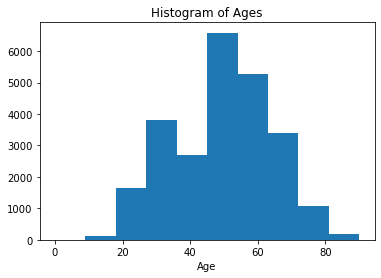

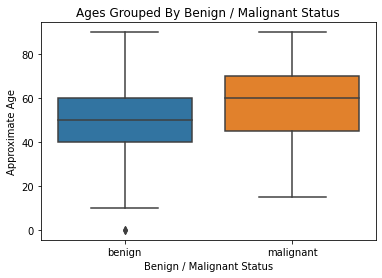

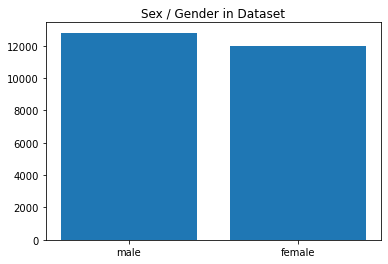

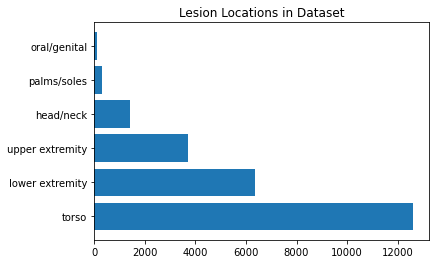

In [2]:
mel_df = pd.read_csv(os.path.join('train_data', 'train.csv'))
gt = mel_df['target']
isic_id = mel_df['image_name']

# proportion of postives
print("Proportion of positives:", np.mean(gt))

plt.hist(mel_df['age_approx'])
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.show()

sns.boxplot(x = mel_df['benign_malignant'],
            y = mel_df['age_approx'])
plt.title('Ages Grouped By Benign / Malignant Status')
plt.xlabel('Benign / Malignant Status')
plt.ylabel('Approximate Age')
plt.show()


plt.bar(mel_df.sex.value_counts().index,  mel_df.sex.value_counts().values)
plt.title('Sex / Gender in Dataset')
plt.show()

plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, mel_df.anatom_site_general_challenge.value_counts().values)
plt.title('Lesion Locations in Dataset')
plt.show()

Tests to find potential correlation between target variables and other categorical variables such as sex/gender or lesion location. 

******************* TARGET W/ SEX INDEPENDENCE TESTS *******************
benign_malignant  benign  malignant
sex                                
female             11824        170
male               12535        267
Chi-Squared test of independence (P-value): 7.87631386486258e-05 



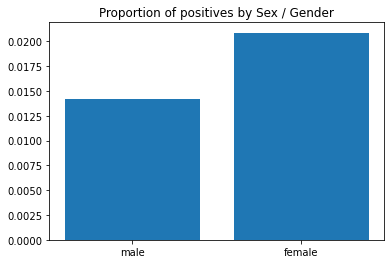



******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************
anatom_site_general_challenge  head/neck  lower extremity  oral/genital  \
sex                                                                       
female                               629             3363            33   
male                                 767             2966            57   

anatom_site_general_challenge  palms/soles  torso  upper extremity  
sex                                                                 
female                                 111   5683             2001  
male                                   169   6926             1698  
Chi-Squared test of independence (P-value): 3.917186815096256e-37 



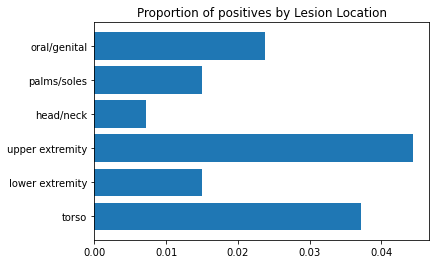

In [3]:
print("******************* TARGET W/ SEX INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['benign_malignant'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df1 = mel_df.groupby(['sex']).mean()
plt.bar(mel_df.sex.value_counts().index,  g_df1['target'].values)
plt.title("Proportion of positives by Sex / Gender")
plt.show()


print("\n\n******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['anatom_site_general_challenge'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df2 = mel_df.groupby(['anatom_site_general_challenge']).mean() 
plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, g_df2['target'].values)
plt.title("Proportion of positives by Lesion Location")
plt.show()


## ResNet-50 (Feature Extraction)

Set device as CPU, or GPU if available. Code will have to change if using multiple GPUs (cuda:0, cuda:1, ...).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    n_workers = os.cpu_count()
else:
    n_workers = torch.cuda.device_count()

# If on a CUDA machine, this should print a CUDA device:
print("Device:", device)
print("Number of devices:", n_workers)


Device: cpu
Number of devices: 36


We create a custom dataset loader class to use the ID and target information from the CSV to properly load our training and testing data.

In [5]:
# Create custom dataset to load in with the benign 
# and malignant images in the same directory
class ISICDatasetImages(Dataset):
    
    def __init__(self, img_dir, patientfile, num_samples=100, start_ind=0, up_sample=False, transform=None):
        self.img_dir = img_dir
        
        mel_df = pd.read_csv(patientfile) 
        
        if up_sample:
            
            # Separate majority and minority classes
            df_benign = mel_df[mel_df['target']==0]
            df_malignant = mel_df[mel_df['target']==1]
            

            # sample minority class
            df_benign_sampled = resample(df_benign, 
                                         replace=True,     # sample with replacement
                                         n_samples=num_samples//2)
            

            # Upsample minority class
            df_malignant_upsampled = resample(df_malignant, 
                                              replace=True,     # sample with replacement
                                              n_samples=num_samples//2)
            
            # Combine majority class with upsampled minority class
            mel_df = pd.concat([df_benign_sampled, df_malignant_upsampled])
            
            # randomly mix them up (not necessary due to shuffling in dataloader)
            mel_df = shuffle(mel_df)
            
        else:
            
            self.start_ind = start_ind
            self.end_ind = start_ind+num_samples

            if self.end_ind > len(mel_df):
                self.end_ind = len(mel_df)
        
            mel_df = mel_df[self.start_ind:self.end_ind]
            
        self.gt = mel_df['target'].reset_index(drop=True)
        self.isic_id = mel_df['image_name'].reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_id)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, f"{self.isic_id[idx]}.jpg")
        img = read_image(img_path).float()
        class_id = torch.tensor([self.gt[idx]])
        
        if self.transform:
            img = self.transform(img)
    
        
        return img, class_id


We create a custom collate function to pad lower resolution images with zeros to maintain a constant high resolution of 3x4000x6000 for the CNN to use.

In [6]:
# recall that a CNN needs the inputs to be the same dimension so we 
# custom collate function to pad small res images with 0s if they are not 3x4000x6000
def pad_collate2d(batch):
    
    # init lists
    image_list, label_list = [], []
   
    for _image, _label in batch:
        
        image_list.append(torch.unsqueeze(_image, dim=0))
        label_list.append(_label)
        

    image_out = torch.cat(image_list, dim=0) 
    label_out = torch.tensor(label_list, dtype=torch.int64)
   
    return image_out, label_out


In [7]:
testing = False

# set our batch size
batch_size = 16

tr_transf = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomVerticalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2))]), p=0.2),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
     transforms.RandomErasing(scale=(0.02, 0.05), p=0.2)
    ])

val_transf = transforms.Compose(
    [transforms.Resize(224),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    ])

train_dataset = ISICDatasetImages(img_dir=os.path.join("train_data256x256", "jpgs"), 
                            patientfile=os.path.join("train_data256x256", "train.csv"), 
                            num_samples=5*2*24408, up_sample=True, start_ind=0, transform=tr_transf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  collate_fn=pad_collate2d, 
                          num_workers=n_workers)


val_dataset = ISICDatasetImages(img_dir=os.path.join("train_data256x256", "jpgs"), 
                            patientfile=os.path.join("train_data256x256", "val.csv"), 
                            num_samples=2*100, up_sample=True, start_ind=0, transform=val_transf)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=pad_collate2d, 
                        num_workers=n_workers)



# test DataLoader with custom settings
if testing:
    for imgs, labels in train_loader:
        print("Batch of images has shape: ",imgs.shape)
        print("Batch of labels: ", labels)

In [8]:
# functions to show the image
def imshow(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))
    plt.show()

label_id = ["Benign", "Malignant"]

if testing:
    # get some random training images
    trainiter = iter(train_loader)
    images, labels = next(trainiter)
    print("Size:", images.shape)


    # show images
    imshow(images[0,])

    # print labels
    print("Label:", label_id[labels[0,]])

Sample and image from the data loader object to confirm it worked. Continue to run the cell for different images.

In [42]:
load_weights = True
create_new_weights = False
PATH = './melanoma_ResNet50.pth'

if load_weights:
    print('Loading the pre-trained CNN weights.')
    
    # network weights load
    net = torchvision.models.resnet50(pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)

    checkpoint = torch.load(PATH, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    
    # optimizer state load
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0.01)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    lr_sched.load_state_dict(checkpoint['lr_sched'])
    
    # total mini_batch state load
    mini_batch = checkpoint['mini_batch']
    
    print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
    
elif create_new_weights:
    print('Creating new ResNet-50 FC Layer weights.')
    
    net = torchvision.models.resnet50(pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)
    
    
    mini_batch = 0
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0.001)
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    
    

Loading the pre-trained CNN weights.
CUDA Memory Allocated: 0


In [43]:
learn_weights = True

print("Pre-Training CUDA Memory Allocation:", torch.cuda.max_memory_allocated())

if learn_weights:

    # set start time for cnn training
    start_time = time.time()

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)

        loss = criterion(outputs, labels.unsqueeze(-1).float())
        loss.backward()
        optimizer.step()
        lr_sched.step()


        # print statistics
        running_loss += loss.item()
        
        # update mini-batch count
        mini_batch += 1
        epoch = mini_batch // 1525

        # print every mini-batch
        print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
        print(f'[Epoch {epoch}, Batch {mini_batch % 1525}] Loss: {running_loss / (i+1)}\n')

        # save and outoput every 100 mini-batch
        if i % 100 == 0:
            print("*********** Saving network weights and optimizer state *********** \n\n")
            # save the weights and optimizer
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, PATH)
            
        # eval every 500 mini-batch
        if i % 500 == 0:
            
            print("******************************************************************")
            print("*********************** Performance Update ***********************")
            print("******************************************************************\n")
            
            net.eval()
            
            ground_truths = []
            probs = []

            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for j, valdata in enumerate(val_loader, 0):
                    image, label = valdata
                    image = image.to(device)

                    # save for analysis
                    ground_truths.append(label)

                    # calculate outputs by running images through the network 
                    outputs = net(image)
                    outputs = outputs.to("cpu")

                    # # save for analysis
                    probs.append(outputs)

            print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs))
            
            net.train()

            print("\n******************************************************************")
            print("****************** Performance Update Complete! ******************")
            print("******************************************************************\n\n")

        # save unique set of weights and optimizer for validation later
        if mini_batch % 1525 == 0:

            uPATH = f'./saved_weights3/melanoma_ResNet50_{epoch}e_{mini_batch % 1525}b.pth'
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, uPATH)

    print('*********** Finished Training this Epoch in', time.time() - start_time, 'seconds ***********')
    
    # save the weights and optimizer
    torch.save({'mini_batch': mini_batch,
                'model_state_dict': net.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                'lr_sched': lr_sched.state_dict()}, PATH)
    


Pre-Training CUDA Memory Allocation: 0
CUDA Memory Allocated: 0
[Epoch 20, Batch 514] Loss: 0.434357225894928

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8971000000000001

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 20, Batch 515] Loss: 0.33932800590991974

CUDA Memory Allocated: 0
[Epoch 20, Batch 516] Loss: 0.2845689505338669

CUDA Memory Allocated: 0
[Epoch 20, Batch 517] Loss: 0.34869641438126564

CUDA Memory Allocated: 0
[Epoch 20, Batch 518] Loss: 0.3305444806814194

CUDA Memory Allocated: 0
[Epoch 20, Batch 519] Loss: 0.33791696776946384



CUDA Memory Allocated: 0
[Epoch 20, Batch 618] Loss: 0.33580326565674373

CUDA Memory Allocated: 0
[Epoch 20, Batch 619] Loss: 0.33660800038081296

CUDA Memory Allocated: 0
[Epoch 20, Batch 620] Loss: 0.33924140871685243

CUDA Memory Allocated: 0
[Epoch 20, Batch 621] Loss: 0.3402805343546249

CUDA Memory Allocated: 0
[Epoch 20, Batch 622] Loss: 0.3403979984171894

CUDA Memory Allocated: 0
[Epoch 20, Batch 623] Loss: 0.33906391750682485

CUDA Memory Allocated: 0
[Epoch 20, Batch 624] Loss: 0.33926799463796187

CUDA Memory Allocated: 0
[Epoch 20, Batch 625] Loss: 0.33962944495890823

CUDA Memory Allocated: 0
[Epoch 20, Batch 626] Loss: 0.3397862423310238

CUDA Memory Allocated: 0
[Epoch 20, Batch 627] Loss: 0.3390412288799621

CUDA Memory Allocated: 0
[Epoch 20, Batch 628] Loss: 0.33837299606074456

CUDA Memory Allocated: 0
[Epoch 20, Batch 629] Loss: 0.3375872941366557

CUDA Memory Allocated: 0
[Epoch 20, Batch 630] Loss: 0.33614970756392193

CUDA Memory Allocated: 0
[Epoch 20, Batch 6

CUDA Memory Allocated: 0
[Epoch 20, Batch 729] Loss: 0.33646075441329565

CUDA Memory Allocated: 0
[Epoch 20, Batch 730] Loss: 0.33717059141479877

CUDA Memory Allocated: 0
[Epoch 20, Batch 731] Loss: 0.3377555420092486

CUDA Memory Allocated: 0
[Epoch 20, Batch 732] Loss: 0.3386374401719603

CUDA Memory Allocated: 0
[Epoch 20, Batch 733] Loss: 0.3379316218197346

CUDA Memory Allocated: 0
[Epoch 20, Batch 734] Loss: 0.3380278097423493

CUDA Memory Allocated: 0
[Epoch 20, Batch 735] Loss: 0.33722558221570004

CUDA Memory Allocated: 0
[Epoch 20, Batch 736] Loss: 0.337330436559536

CUDA Memory Allocated: 0
[Epoch 20, Batch 737] Loss: 0.3378371011598834

CUDA Memory Allocated: 0
[Epoch 20, Batch 738] Loss: 0.3378651358683904

CUDA Memory Allocated: 0
[Epoch 20, Batch 739] Loss: 0.3383478048232804

CUDA Memory Allocated: 0
[Epoch 20, Batch 740] Loss: 0.33845126845500545

CUDA Memory Allocated: 0
[Epoch 20, Batch 741] Loss: 0.33813917159772755

CUDA Memory Allocated: 0
[Epoch 20, Batch 742] 

CUDA Memory Allocated: 0
[Epoch 20, Batch 840] Loss: 0.33771713419791755

CUDA Memory Allocated: 0
[Epoch 20, Batch 841] Loss: 0.337653227241301

CUDA Memory Allocated: 0
[Epoch 20, Batch 842] Loss: 0.337712946180877

CUDA Memory Allocated: 0
[Epoch 20, Batch 843] Loss: 0.3389788382884228

CUDA Memory Allocated: 0
[Epoch 20, Batch 844] Loss: 0.3396362254446727

CUDA Memory Allocated: 0
[Epoch 20, Batch 845] Loss: 0.33937454914831255

CUDA Memory Allocated: 0
[Epoch 20, Batch 846] Loss: 0.33926071275819886

CUDA Memory Allocated: 0
[Epoch 20, Batch 847] Loss: 0.33956356828441164

CUDA Memory Allocated: 0
[Epoch 20, Batch 848] Loss: 0.3395895820055435

CUDA Memory Allocated: 0
[Epoch 20, Batch 849] Loss: 0.340355832395809

CUDA Memory Allocated: 0
[Epoch 20, Batch 850] Loss: 0.3406559355357988

CUDA Memory Allocated: 0
[Epoch 20, Batch 851] Loss: 0.342140899166553

CUDA Memory Allocated: 0
[Epoch 20, Batch 852] Loss: 0.3422888925293554

CUDA Memory Allocated: 0
[Epoch 20, Batch 853] Loss

CUDA Memory Allocated: 0
[Epoch 20, Batch 951] Loss: 0.3370871078818356

CUDA Memory Allocated: 0
[Epoch 20, Batch 952] Loss: 0.33756656747879904

CUDA Memory Allocated: 0
[Epoch 20, Batch 953] Loss: 0.3372985165566206

CUDA Memory Allocated: 0
[Epoch 20, Batch 954] Loss: 0.3375022936772868

CUDA Memory Allocated: 0
[Epoch 20, Batch 955] Loss: 0.3372316676364765

CUDA Memory Allocated: 0
[Epoch 20, Batch 956] Loss: 0.3372175536427487

CUDA Memory Allocated: 0
[Epoch 20, Batch 957] Loss: 0.33753350387151176

CUDA Memory Allocated: 0
[Epoch 20, Batch 958] Loss: 0.33774919479750515

CUDA Memory Allocated: 0
[Epoch 20, Batch 959] Loss: 0.3380183956080488

CUDA Memory Allocated: 0
[Epoch 20, Batch 960] Loss: 0.3378667981099229

CUDA Memory Allocated: 0
[Epoch 20, Batch 961] Loss: 0.33769654938285903

CUDA Memory Allocated: 0
[Epoch 20, Batch 962] Loss: 0.33750428604522104

CUDA Memory Allocated: 0
[Epoch 20, Batch 963] Loss: 0.3374031892418861

CUDA Memory Allocated: 0
[Epoch 20, Batch 964]

CUDA Memory Allocated: 0
[Epoch 20, Batch 1055] Loss: 0.33301112432431473

CUDA Memory Allocated: 0
[Epoch 20, Batch 1056] Loss: 0.33331494082732754

CUDA Memory Allocated: 0
[Epoch 20, Batch 1057] Loss: 0.33310928318978233

CUDA Memory Allocated: 0
[Epoch 20, Batch 1058] Loss: 0.3328576311605786

CUDA Memory Allocated: 0
[Epoch 20, Batch 1059] Loss: 0.3330055745420875

CUDA Memory Allocated: 0
[Epoch 20, Batch 1060] Loss: 0.3332124857514606

CUDA Memory Allocated: 0
[Epoch 20, Batch 1061] Loss: 0.33328434052693584

CUDA Memory Allocated: 0
[Epoch 20, Batch 1062] Loss: 0.3333312889700162

CUDA Memory Allocated: 0
[Epoch 20, Batch 1063] Loss: 0.33361954987049103

CUDA Memory Allocated: 0
[Epoch 20, Batch 1064] Loss: 0.33345977770005725

CUDA Memory Allocated: 0
[Epoch 20, Batch 1065] Loss: 0.33339206750194234

CUDA Memory Allocated: 0
[Epoch 20, Batch 1066] Loss: 0.33393019141383457

CUDA Memory Allocated: 0
[Epoch 20, Batch 1067] Loss: 0.33380043420550626

CUDA Memory Allocated: 0
[Epo

CUDA Memory Allocated: 0
[Epoch 20, Batch 1165] Loss: 0.3333218856914643

CUDA Memory Allocated: 0
[Epoch 20, Batch 1166] Loss: 0.33311929840132437

CUDA Memory Allocated: 0
[Epoch 20, Batch 1167] Loss: 0.33293861804661035

CUDA Memory Allocated: 0
[Epoch 20, Batch 1168] Loss: 0.3328976962175078

CUDA Memory Allocated: 0
[Epoch 20, Batch 1169] Loss: 0.3331632867410052

CUDA Memory Allocated: 0
[Epoch 20, Batch 1170] Loss: 0.3331521161388226

CUDA Memory Allocated: 0
[Epoch 20, Batch 1171] Loss: 0.3329867817076506

CUDA Memory Allocated: 0
[Epoch 20, Batch 1172] Loss: 0.3330667738397132

CUDA Memory Allocated: 0
[Epoch 20, Batch 1173] Loss: 0.3328300803448215

CUDA Memory Allocated: 0
[Epoch 20, Batch 1174] Loss: 0.3327896572006993

CUDA Memory Allocated: 0
[Epoch 20, Batch 1175] Loss: 0.3327295297132158

CUDA Memory Allocated: 0
[Epoch 20, Batch 1176] Loss: 0.332795621627776

CUDA Memory Allocated: 0
[Epoch 20, Batch 1177] Loss: 0.33273188491542655

CUDA Memory Allocated: 0
[Epoch 20, 

CUDA Memory Allocated: 0
[Epoch 20, Batch 1275] Loss: 0.33095419592666503

CUDA Memory Allocated: 0
[Epoch 20, Batch 1276] Loss: 0.33084442106174455

CUDA Memory Allocated: 0
[Epoch 20, Batch 1277] Loss: 0.3307618681360914

CUDA Memory Allocated: 0
[Epoch 20, Batch 1278] Loss: 0.330703089985193

CUDA Memory Allocated: 0
[Epoch 20, Batch 1279] Loss: 0.3307460088175831

CUDA Memory Allocated: 0
[Epoch 20, Batch 1280] Loss: 0.3309309376886957

CUDA Memory Allocated: 0
[Epoch 20, Batch 1281] Loss: 0.3308579761069268

CUDA Memory Allocated: 0
[Epoch 20, Batch 1282] Loss: 0.33067291211554845

CUDA Memory Allocated: 0
[Epoch 20, Batch 1283] Loss: 0.3307945388091075

CUDA Memory Allocated: 0
[Epoch 20, Batch 1284] Loss: 0.3305873194402603

CUDA Memory Allocated: 0
[Epoch 20, Batch 1285] Loss: 0.3304690974595633

CUDA Memory Allocated: 0
[Epoch 20, Batch 1286] Loss: 0.3304150535943129

CUDA Memory Allocated: 0
[Epoch 20, Batch 1287] Loss: 0.3306175178104593

CUDA Memory Allocated: 0
[Epoch 20, 

CUDA Memory Allocated: 0
[Epoch 20, Batch 1385] Loss: 0.3292434548087623

CUDA Memory Allocated: 0
[Epoch 20, Batch 1386] Loss: 0.3290802784528656

CUDA Memory Allocated: 0
[Epoch 20, Batch 1387] Loss: 0.32905992875792067

CUDA Memory Allocated: 0
[Epoch 20, Batch 1388] Loss: 0.3288472447395325

CUDA Memory Allocated: 0
[Epoch 20, Batch 1389] Loss: 0.32866106480019824

CUDA Memory Allocated: 0
[Epoch 20, Batch 1390] Loss: 0.3292179855442645

CUDA Memory Allocated: 0
[Epoch 20, Batch 1391] Loss: 0.3291360879304197

CUDA Memory Allocated: 0
[Epoch 20, Batch 1392] Loss: 0.32918552389798583

CUDA Memory Allocated: 0
[Epoch 20, Batch 1393] Loss: 0.32911797303029083

CUDA Memory Allocated: 0
[Epoch 20, Batch 1394] Loss: 0.32897072267654126

CUDA Memory Allocated: 0
[Epoch 20, Batch 1395] Loss: 0.3287653056672371

CUDA Memory Allocated: 0
[Epoch 20, Batch 1396] Loss: 0.328694669536124

CUDA Memory Allocated: 0
[Epoch 20, Batch 1397] Loss: 0.3288138376641597

CUDA Memory Allocated: 0
[Epoch 20

CUDA Memory Allocated: 0
[Epoch 20, Batch 1495] Loss: 0.33089660047392255

CUDA Memory Allocated: 0
[Epoch 20, Batch 1496] Loss: 0.3307657756009883

CUDA Memory Allocated: 0
[Epoch 20, Batch 1497] Loss: 0.33073626543448226

CUDA Memory Allocated: 0
[Epoch 20, Batch 1498] Loss: 0.33068919868638674

CUDA Memory Allocated: 0
[Epoch 20, Batch 1499] Loss: 0.330678120678627

CUDA Memory Allocated: 0
[Epoch 20, Batch 1500] Loss: 0.33064904356075275

CUDA Memory Allocated: 0
[Epoch 20, Batch 1501] Loss: 0.33071419328209845

CUDA Memory Allocated: 0
[Epoch 20, Batch 1502] Loss: 0.33071329074754513

CUDA Memory Allocated: 0
[Epoch 20, Batch 1503] Loss: 0.33087973329755993

CUDA Memory Allocated: 0
[Epoch 20, Batch 1504] Loss: 0.33071906058687256

CUDA Memory Allocated: 0
[Epoch 20, Batch 1505] Loss: 0.3305396816182521

CUDA Memory Allocated: 0
[Epoch 20, Batch 1506] Loss: 0.3304042870184446

CUDA Memory Allocated: 0
[Epoch 20, Batch 1507] Loss: 0.33046080414917867

CUDA Memory Allocated: 0
[Epoc

CUDA Memory Allocated: 0
[Epoch 21, Batch 76] Loss: 0.3302592498195522

CUDA Memory Allocated: 0
[Epoch 21, Batch 77] Loss: 0.3303858602780394

CUDA Memory Allocated: 0
[Epoch 21, Batch 78] Loss: 0.3303153433930983

CUDA Memory Allocated: 0
[Epoch 21, Batch 79] Loss: 0.3301794777541506

CUDA Memory Allocated: 0
[Epoch 21, Batch 80] Loss: 0.33010477127828003

CUDA Memory Allocated: 0
[Epoch 21, Batch 81] Loss: 0.3301469867423599

CUDA Memory Allocated: 0
[Epoch 21, Batch 82] Loss: 0.33004118935281657

CUDA Memory Allocated: 0
[Epoch 21, Batch 83] Loss: 0.3302376740599332

CUDA Memory Allocated: 0
[Epoch 21, Batch 84] Loss: 0.3301657608771411

CUDA Memory Allocated: 0
[Epoch 21, Batch 85] Loss: 0.33016707050659055

CUDA Memory Allocated: 0
[Epoch 21, Batch 86] Loss: 0.33039826480417306

CUDA Memory Allocated: 0
[Epoch 21, Batch 87] Loss: 0.330484182917063

CUDA Memory Allocated: 0
[Epoch 21, Batch 88] Loss: 0.330475421981378

CUDA Memory Allocated: 0
[Epoch 21, Batch 89] Loss: 0.33056168

CUDA Memory Allocated: 0
[Epoch 21, Batch 188] Loss: 0.3298841643209259

CUDA Memory Allocated: 0
[Epoch 21, Batch 189] Loss: 0.330006525863418

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 21, Batch 190] Loss: 0.32989495100078486

CUDA Memory Allocated: 0
[Epoch 21, Batch 191] Loss: 0.32978740063242784

CUDA Memory Allocated: 0
[Epoch 21, Batch 192] Loss: 0.33007903158219154

CUDA Memory Allocated: 0
[Epoch 21, Batch 193] Loss: 0.3301233160668884

CUDA Memory Allocated: 0
[Epoch 21, Batch 194] Loss: 0.3300337647250043

CUDA Memory Allocated: 0
[Epoch 21, Batch 195] Loss: 0.33013315888950423

CUDA Memory Allocated: 0
[Epoch 21, Batch 196] Loss: 0.3300418917040359

CUDA Memory Allocated: 0
[Epoch 21, Batch 197] Loss: 0.3300015322549763

CUDA Memory Allocated: 0
[Epoch 21, Batch 198] Loss: 0.3299494109493642

CUDA Memory Allocated: 0
[Epoch 21, Batch 199] Loss: 0.3299465017388617

CUDA Memory Allocated: 0
[Epoch 21, Batch 200] Loss

CUDA Memory Allocated: 0
[Epoch 21, Batch 298] Loss: 0.32974899893498605

CUDA Memory Allocated: 0
[Epoch 21, Batch 299] Loss: 0.32983908889222746

CUDA Memory Allocated: 0
[Epoch 21, Batch 300] Loss: 0.32985648390178274

CUDA Memory Allocated: 0
[Epoch 21, Batch 301] Loss: 0.32979109975234844

CUDA Memory Allocated: 0
[Epoch 21, Batch 302] Loss: 0.3298065402350832

CUDA Memory Allocated: 0
[Epoch 21, Batch 303] Loss: 0.3297415994645978

CUDA Memory Allocated: 0
[Epoch 21, Batch 304] Loss: 0.3297448031445767

CUDA Memory Allocated: 0
[Epoch 21, Batch 305] Loss: 0.32970586559404996

CUDA Memory Allocated: 0
[Epoch 21, Batch 306] Loss: 0.3299325497224588

CUDA Memory Allocated: 0
[Epoch 21, Batch 307] Loss: 0.3299261570835403

CUDA Memory Allocated: 0
[Epoch 21, Batch 308] Loss: 0.32991401221264494

CUDA Memory Allocated: 0
[Epoch 21, Batch 309] Loss: 0.3298098125031823

CUDA Memory Allocated: 0
[Epoch 21, Batch 310] Loss: 0.3299994444342136

CUDA Memory Allocated: 0
[Epoch 21, Batch 311

CUDA Memory Allocated: 0
[Epoch 21, Batch 409] Loss: 0.3297472982382288

CUDA Memory Allocated: 0
[Epoch 21, Batch 410] Loss: 0.3296815657728835

CUDA Memory Allocated: 0
[Epoch 21, Batch 411] Loss: 0.32977174293676564

CUDA Memory Allocated: 0
[Epoch 21, Batch 412] Loss: 0.3297472604226028

CUDA Memory Allocated: 0
[Epoch 21, Batch 413] Loss: 0.3296877949802499

CUDA Memory Allocated: 0
[Epoch 21, Batch 414] Loss: 0.32958521442109034

CUDA Memory Allocated: 0
[Epoch 21, Batch 415] Loss: 0.32966007232749556

CUDA Memory Allocated: 0
[Epoch 21, Batch 416] Loss: 0.3296270980095329

CUDA Memory Allocated: 0
[Epoch 21, Batch 417] Loss: 0.32966126091752207

CUDA Memory Allocated: 0
[Epoch 21, Batch 418] Loss: 0.329604868757558

CUDA Memory Allocated: 0
[Epoch 21, Batch 419] Loss: 0.3295359558820891

CUDA Memory Allocated: 0
[Epoch 21, Batch 420] Loss: 0.32947962391892627

CUDA Memory Allocated: 0
[Epoch 21, Batch 421] Loss: 0.3294280000857681

CUDA Memory Allocated: 0
[Epoch 21, Batch 422] 

CUDA Memory Allocated: 0
[Epoch 21, Batch 514] Loss: 0.3290935768642088

CUDA Memory Allocated: 0
[Epoch 21, Batch 515] Loss: 0.3291162966940242

CUDA Memory Allocated: 0
[Epoch 21, Batch 516] Loss: 0.3291846451334928

CUDA Memory Allocated: 0
[Epoch 21, Batch 517] Loss: 0.3292329193642905

CUDA Memory Allocated: 0
[Epoch 21, Batch 518] Loss: 0.3292530919991288

CUDA Memory Allocated: 0
[Epoch 21, Batch 519] Loss: 0.3292606190907885

CUDA Memory Allocated: 0
[Epoch 21, Batch 520] Loss: 0.3292441381525744

CUDA Memory Allocated: 0
[Epoch 21, Batch 521] Loss: 0.329176041332243

CUDA Memory Allocated: 0
[Epoch 21, Batch 522] Loss: 0.32907767997959914

CUDA Memory Allocated: 0
[Epoch 21, Batch 523] Loss: 0.32905149838435144

CUDA Memory Allocated: 0
[Epoch 21, Batch 524] Loss: 0.32900753132222843

CUDA Memory Allocated: 0
[Epoch 21, Batch 525] Loss: 0.3289340128740399

CUDA Memory Allocated: 0
[Epoch 21, Batch 526] Loss: 0.3290143488907535

CUDA Memory Allocated: 0
[Epoch 21, Batch 527] Lo

CUDA Memory Allocated: 0
[Epoch 21, Batch 625] Loss: 0.3288248665152924

CUDA Memory Allocated: 0
[Epoch 21, Batch 626] Loss: 0.3287347106397225

CUDA Memory Allocated: 0
[Epoch 21, Batch 627] Loss: 0.3287365663026149

CUDA Memory Allocated: 0
[Epoch 21, Batch 628] Loss: 0.3287742031874453

CUDA Memory Allocated: 0
[Epoch 21, Batch 629] Loss: 0.3287832247800467

CUDA Memory Allocated: 0
[Epoch 21, Batch 630] Loss: 0.3289018812862732

CUDA Memory Allocated: 0
[Epoch 21, Batch 631] Loss: 0.3288977541487462

CUDA Memory Allocated: 0
[Epoch 21, Batch 632] Loss: 0.3288621040210672

CUDA Memory Allocated: 0
[Epoch 21, Batch 633] Loss: 0.3288584089840799

CUDA Memory Allocated: 0
[Epoch 21, Batch 634] Loss: 0.3288325404211933

CUDA Memory Allocated: 0
[Epoch 21, Batch 635] Loss: 0.3287870103779459

CUDA Memory Allocated: 0
[Epoch 21, Batch 636] Loss: 0.32881328155223316

CUDA Memory Allocated: 0
[Epoch 21, Batch 637] Loss: 0.3288241628356382

CUDA Memory Allocated: 0
[Epoch 21, Batch 638] Los

CUDA Memory Allocated: 0
[Epoch 21, Batch 736] Loss: 0.32857528077417164

CUDA Memory Allocated: 0
[Epoch 21, Batch 737] Loss: 0.32865608734461565

CUDA Memory Allocated: 0
[Epoch 21, Batch 738] Loss: 0.32864767865623745

CUDA Memory Allocated: 0
[Epoch 21, Batch 739] Loss: 0.32890537584563245

CUDA Memory Allocated: 0
[Epoch 21, Batch 740] Loss: 0.328835074360308

CUDA Memory Allocated: 0
[Epoch 21, Batch 741] Loss: 0.32884020215942733

CUDA Memory Allocated: 0
[Epoch 21, Batch 742] Loss: 0.32885615373860744

CUDA Memory Allocated: 0
[Epoch 21, Batch 743] Loss: 0.3288954428203425

CUDA Memory Allocated: 0
[Epoch 21, Batch 744] Loss: 0.3289840438048905

CUDA Memory Allocated: 0
[Epoch 21, Batch 745] Loss: 0.3291462174805987

CUDA Memory Allocated: 0
[Epoch 21, Batch 746] Loss: 0.32906702913521907

CUDA Memory Allocated: 0
[Epoch 21, Batch 747] Loss: 0.3290257704501941

CUDA Memory Allocated: 0
[Epoch 21, Batch 748] Loss: 0.32907904013991357

CUDA Memory Allocated: 0
[Epoch 21, Batch 74

CUDA Memory Allocated: 0
[Epoch 21, Batch 847] Loss: 0.3310497931699204

CUDA Memory Allocated: 0
[Epoch 21, Batch 848] Loss: 0.33100154762787204

CUDA Memory Allocated: 0
[Epoch 21, Batch 849] Loss: 0.3309243958301278

CUDA Memory Allocated: 0
[Epoch 21, Batch 850] Loss: 0.3308918747718813

CUDA Memory Allocated: 0
[Epoch 21, Batch 851] Loss: 0.3308289223263101

CUDA Memory Allocated: 0
[Epoch 21, Batch 852] Loss: 0.3307337675147686

CUDA Memory Allocated: 0
[Epoch 21, Batch 853] Loss: 0.3306514337459135

CUDA Memory Allocated: 0
[Epoch 21, Batch 854] Loss: 0.33065492641440286

CUDA Memory Allocated: 0
[Epoch 21, Batch 855] Loss: 0.3308367902062829

CUDA Memory Allocated: 0
[Epoch 21, Batch 856] Loss: 0.33082722965029626

CUDA Memory Allocated: 0
[Epoch 21, Batch 857] Loss: 0.3307248174410698

CUDA Memory Allocated: 0
[Epoch 21, Batch 858] Loss: 0.3306819633207219

CUDA Memory Allocated: 0
[Epoch 21, Batch 859] Loss: 0.33063314912441516

CUDA Memory Allocated: 0
[Epoch 21, Batch 860] 

CUDA Memory Allocated: 0
[Epoch 21, Batch 958] Loss: 0.33151022774465194

CUDA Memory Allocated: 0
[Epoch 21, Batch 959] Loss: 0.3314467967161365

CUDA Memory Allocated: 0
[Epoch 21, Batch 960] Loss: 0.3313802233377649

CUDA Memory Allocated: 0
[Epoch 21, Batch 961] Loss: 0.3314457434917306

CUDA Memory Allocated: 0
[Epoch 21, Batch 962] Loss: 0.3314400823841583

CUDA Memory Allocated: 0
[Epoch 21, Batch 963] Loss: 0.3315577929306634

CUDA Memory Allocated: 0
[Epoch 21, Batch 964] Loss: 0.331658296415258

CUDA Memory Allocated: 0
[Epoch 21, Batch 965] Loss: 0.33160662655584366

CUDA Memory Allocated: 0
[Epoch 21, Batch 966] Loss: 0.3317674420871918

CUDA Memory Allocated: 0
[Epoch 21, Batch 967] Loss: 0.3317187861654721

CUDA Memory Allocated: 0
[Epoch 21, Batch 968] Loss: 0.33163122264574274

CUDA Memory Allocated: 0
[Epoch 21, Batch 969] Loss: 0.33159583251112823

CUDA Memory Allocated: 0
[Epoch 21, Batch 970] Loss: 0.3315565848251284

CUDA Memory Allocated: 0
[Epoch 21, Batch 971] L

CUDA Memory Allocated: 0
[Epoch 21, Batch 1062] Loss: 0.33071888855361203

CUDA Memory Allocated: 0
[Epoch 21, Batch 1063] Loss: 0.3308345651052084

CUDA Memory Allocated: 0
[Epoch 21, Batch 1064] Loss: 0.33081068642624084

CUDA Memory Allocated: 0
[Epoch 21, Batch 1065] Loss: 0.33073321777607995

CUDA Memory Allocated: 0
[Epoch 21, Batch 1066] Loss: 0.3307022008116252

CUDA Memory Allocated: 0
[Epoch 21, Batch 1067] Loss: 0.330613543360551

CUDA Memory Allocated: 0
[Epoch 21, Batch 1068] Loss: 0.3306935894374664

CUDA Memory Allocated: 0
[Epoch 21, Batch 1069] Loss: 0.3307530022853272

CUDA Memory Allocated: 0
[Epoch 21, Batch 1070] Loss: 0.3307845192701054

CUDA Memory Allocated: 0
[Epoch 21, Batch 1071] Loss: 0.3307590530116685

CUDA Memory Allocated: 0
[Epoch 21, Batch 1072] Loss: 0.3308136330742296

CUDA Memory Allocated: 0
[Epoch 21, Batch 1073] Loss: 0.3307915693993191

CUDA Memory Allocated: 0
[Epoch 21, Batch 1074] Loss: 0.33084338483394393

CUDA Memory Allocated: 0
[Epoch 21,

CUDA Memory Allocated: 0
[Epoch 21, Batch 1172] Loss: 0.33073308250624617

CUDA Memory Allocated: 0
[Epoch 21, Batch 1173] Loss: 0.3307085374672844

CUDA Memory Allocated: 0
[Epoch 21, Batch 1174] Loss: 0.33069749111062546

CUDA Memory Allocated: 0
[Epoch 21, Batch 1175] Loss: 0.33083665535828266

CUDA Memory Allocated: 0
[Epoch 21, Batch 1176] Loss: 0.3308306984889442

CUDA Memory Allocated: 0
[Epoch 21, Batch 1177] Loss: 0.33085817693574837

CUDA Memory Allocated: 0
[Epoch 21, Batch 1178] Loss: 0.330851497171132

CUDA Memory Allocated: 0
[Epoch 21, Batch 1179] Loss: 0.3309683208866024

CUDA Memory Allocated: 0
[Epoch 21, Batch 1180] Loss: 0.33092084529055077

CUDA Memory Allocated: 0
[Epoch 21, Batch 1181] Loss: 0.33084868080829083

CUDA Memory Allocated: 0
[Epoch 21, Batch 1182] Loss: 0.3308580227148674

CUDA Memory Allocated: 0
[Epoch 21, Batch 1183] Loss: 0.331024156025439

CUDA Memory Allocated: 0
[Epoch 21, Batch 1184] Loss: 0.33096778486432926

CUDA Memory Allocated: 0
[Epoch 2

CUDA Memory Allocated: 0
[Epoch 21, Batch 1282] Loss: 0.32932285853412324

CUDA Memory Allocated: 0
[Epoch 21, Batch 1283] Loss: 0.32932730195698917

CUDA Memory Allocated: 0
[Epoch 21, Batch 1284] Loss: 0.329286585545706

CUDA Memory Allocated: 0
[Epoch 21, Batch 1285] Loss: 0.32930359210613036

CUDA Memory Allocated: 0
[Epoch 21, Batch 1286] Loss: 0.3292427196696699

CUDA Memory Allocated: 0
[Epoch 21, Batch 1287] Loss: 0.3292503792625658

CUDA Memory Allocated: 0
[Epoch 21, Batch 1288] Loss: 0.3292497852574224

CUDA Memory Allocated: 0
[Epoch 21, Batch 1289] Loss: 0.3292888957798248

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 21, Batch 1290] Loss: 0.32921444948319245

CUDA Memory Allocated: 0
[Epoch 21, Batch 1291] Loss: 0.32920246500452344

CUDA Memory Allocated: 0
[Epoch 21, Batch 1292] Loss: 0.32921195848353413

CUDA Memory Allocated: 0
[Epoch 21, Batch 1293] Loss: 0.3291638658258765

CUDA Memory Allocated: 0
[Epoch 21, B

CUDA Memory Allocated: 0
[Epoch 21, Batch 1391] Loss: 0.3291089118668004

CUDA Memory Allocated: 0
[Epoch 21, Batch 1392] Loss: 0.3291906354803214

CUDA Memory Allocated: 0
[Epoch 21, Batch 1393] Loss: 0.32914872991691757

CUDA Memory Allocated: 0
[Epoch 21, Batch 1394] Loss: 0.32915061144336305

CUDA Memory Allocated: 0
[Epoch 21, Batch 1395] Loss: 0.3290885743148405

CUDA Memory Allocated: 0
[Epoch 21, Batch 1396] Loss: 0.329164230973271

CUDA Memory Allocated: 0
[Epoch 21, Batch 1397] Loss: 0.32919478006336195

CUDA Memory Allocated: 0
[Epoch 21, Batch 1398] Loss: 0.3291555468843191

CUDA Memory Allocated: 0
[Epoch 21, Batch 1399] Loss: 0.3291090837174162

CUDA Memory Allocated: 0
[Epoch 21, Batch 1400] Loss: 0.3291507624336835

CUDA Memory Allocated: 0
[Epoch 21, Batch 1401] Loss: 0.32911162904644725

CUDA Memory Allocated: 0
[Epoch 21, Batch 1402] Loss: 0.3291236767306146

CUDA Memory Allocated: 0
[Epoch 21, Batch 1403] Loss: 0.32910218984814166

CUDA Memory Allocated: 0
[Epoch 21

CUDA Memory Allocated: 0
[Epoch 21, Batch 1495] Loss: 0.3283329963458217

CUDA Memory Allocated: 0
[Epoch 21, Batch 1496] Loss: 0.3282868379706211

CUDA Memory Allocated: 0
[Epoch 21, Batch 1497] Loss: 0.3282442161194971

CUDA Memory Allocated: 0
[Epoch 21, Batch 1498] Loss: 0.3282226296416317

CUDA Memory Allocated: 0
[Epoch 21, Batch 1499] Loss: 0.3282112379631451

CUDA Memory Allocated: 0
[Epoch 21, Batch 1500] Loss: 0.3282187775512979

CUDA Memory Allocated: 0
[Epoch 21, Batch 1501] Loss: 0.3283014408132255

CUDA Memory Allocated: 0
[Epoch 21, Batch 1502] Loss: 0.3282732379251562

CUDA Memory Allocated: 0
[Epoch 21, Batch 1503] Loss: 0.32824772498005667

CUDA Memory Allocated: 0
[Epoch 21, Batch 1504] Loss: 0.3282898879700321

CUDA Memory Allocated: 0
[Epoch 21, Batch 1505] Loss: 0.32829589640331686

CUDA Memory Allocated: 0
[Epoch 21, Batch 1506] Loss: 0.3283263677590607

CUDA Memory Allocated: 0
[Epoch 21, Batch 1507] Loss: 0.32826232004492184

CUDA Memory Allocated: 0
[Epoch 21,

CUDA Memory Allocated: 0
[Epoch 22, Batch 82] Loss: 0.3282855664411543

CUDA Memory Allocated: 0
[Epoch 22, Batch 83] Loss: 0.3282591119579231

CUDA Memory Allocated: 0
[Epoch 22, Batch 84] Loss: 0.3282743568856586

CUDA Memory Allocated: 0
[Epoch 22, Batch 85] Loss: 0.32827247841202695

CUDA Memory Allocated: 0
[Epoch 22, Batch 86] Loss: 0.3283419589016031

CUDA Memory Allocated: 0
[Epoch 22, Batch 87] Loss: 0.3283560751971403

CUDA Memory Allocated: 0
[Epoch 22, Batch 88] Loss: 0.32829732399327416

CUDA Memory Allocated: 0
[Epoch 22, Batch 89] Loss: 0.32826945677637964

CUDA Memory Allocated: 0
[Epoch 22, Batch 90] Loss: 0.32823902405415556

CUDA Memory Allocated: 0
[Epoch 22, Batch 91] Loss: 0.3283073676514753

CUDA Memory Allocated: 0
[Epoch 22, Batch 92] Loss: 0.32830506728125325

CUDA Memory Allocated: 0
[Epoch 22, Batch 93] Loss: 0.3282645357652309

CUDA Memory Allocated: 0
[Epoch 22, Batch 94] Loss: 0.3283105396762269

CUDA Memory Allocated: 0
[Epoch 22, Batch 95] Loss: 0.32830

CUDA Memory Allocated: 0
[Epoch 22, Batch 193] Loss: 0.3280257588614038

CUDA Memory Allocated: 0
[Epoch 22, Batch 194] Loss: 0.32798796684826653

CUDA Memory Allocated: 0
[Epoch 22, Batch 195] Loss: 0.3280050824471309

CUDA Memory Allocated: 0
[Epoch 22, Batch 196] Loss: 0.3280087713025404

CUDA Memory Allocated: 0
[Epoch 22, Batch 197] Loss: 0.32794936362111665

CUDA Memory Allocated: 0
[Epoch 22, Batch 198] Loss: 0.32793467122196496

CUDA Memory Allocated: 0
[Epoch 22, Batch 199] Loss: 0.3279862894910818

CUDA Memory Allocated: 0
[Epoch 22, Batch 200] Loss: 0.32797716557435147

CUDA Memory Allocated: 0
[Epoch 22, Batch 201] Loss: 0.32797544886588703

CUDA Memory Allocated: 0
[Epoch 22, Batch 202] Loss: 0.3279658909390642

CUDA Memory Allocated: 0
[Epoch 22, Batch 203] Loss: 0.32797817137554613

CUDA Memory Allocated: 0
[Epoch 22, Batch 204] Loss: 0.3280486041983737

CUDA Memory Allocated: 0
[Epoch 22, Batch 205] Loss: 0.3279828209019681

CUDA Memory Allocated: 0
[Epoch 22, Batch 206

CUDA Memory Allocated: 0
[Epoch 22, Batch 304] Loss: 0.32810706326089584

CUDA Memory Allocated: 0
[Epoch 22, Batch 305] Loss: 0.3281051803125956

CUDA Memory Allocated: 0
[Epoch 22, Batch 306] Loss: 0.32812513710326224

CUDA Memory Allocated: 0
[Epoch 22, Batch 307] Loss: 0.32806949114162376

CUDA Memory Allocated: 0
[Epoch 22, Batch 308] Loss: 0.32807648322284744

CUDA Memory Allocated: 0
[Epoch 22, Batch 309] Loss: 0.3281131159417326

CUDA Memory Allocated: 0
[Epoch 22, Batch 310] Loss: 0.32811117976181625

CUDA Memory Allocated: 0
[Epoch 22, Batch 311] Loss: 0.32806524127889214

CUDA Memory Allocated: 0
[Epoch 22, Batch 312] Loss: 0.3280181235526896

CUDA Memory Allocated: 0
[Epoch 22, Batch 313] Loss: 0.3279711867842758

CUDA Memory Allocated: 0
[Epoch 22, Batch 314] Loss: 0.3279729233064889

CUDA Memory Allocated: 0
[Epoch 22, Batch 315] Loss: 0.3279672010604496

CUDA Memory Allocated: 0
[Epoch 22, Batch 316] Loss: 0.32803371807712445

CUDA Memory Allocated: 0
[Epoch 22, Batch 31

CUDA Memory Allocated: 0
[Epoch 22, Batch 415] Loss: 0.3276051850711831

CUDA Memory Allocated: 0
[Epoch 22, Batch 416] Loss: 0.32755589569438487

CUDA Memory Allocated: 0
[Epoch 22, Batch 417] Loss: 0.32756609347577664

CUDA Memory Allocated: 0
[Epoch 22, Batch 418] Loss: 0.3275721388167738

CUDA Memory Allocated: 0
[Epoch 22, Batch 419] Loss: 0.3275623225704017

CUDA Memory Allocated: 0
[Epoch 22, Batch 420] Loss: 0.32755764045443614

CUDA Memory Allocated: 0
[Epoch 22, Batch 421] Loss: 0.32754300214838866

CUDA Memory Allocated: 0
[Epoch 22, Batch 422] Loss: 0.3275160171537232

CUDA Memory Allocated: 0
[Epoch 22, Batch 423] Loss: 0.3274478562981696

CUDA Memory Allocated: 0
[Epoch 22, Batch 424] Loss: 0.3274353663086368

CUDA Memory Allocated: 0
[Epoch 22, Batch 425] Loss: 0.3274457931095969

CUDA Memory Allocated: 0
[Epoch 22, Batch 426] Loss: 0.3274609974880618

CUDA Memory Allocated: 0
[Epoch 22, Batch 427] Loss: 0.32745913254265524

CUDA Memory Allocated: 0
[Epoch 22, Batch 428]

CUDA Memory Allocated: 0
[Epoch 22, Batch 520] Loss: 0.3272659568262911

CUDA Memory Allocated: 0
[Epoch 22, Batch 521] Loss: 0.32725377646418

CUDA Memory Allocated: 0
[Epoch 22, Batch 522] Loss: 0.3272557408494394

CUDA Memory Allocated: 0
[Epoch 22, Batch 523] Loss: 0.3272824648597272

CUDA Memory Allocated: 0
[Epoch 22, Batch 524] Loss: 0.3272501338164972

CUDA Memory Allocated: 0
[Epoch 22, Batch 525] Loss: 0.32724421802277975

CUDA Memory Allocated: 0
[Epoch 22, Batch 526] Loss: 0.3272045499849195

CUDA Memory Allocated: 0
[Epoch 22, Batch 527] Loss: 0.32717978281720345

CUDA Memory Allocated: 0
[Epoch 22, Batch 528] Loss: 0.32727318833449925

CUDA Memory Allocated: 0
[Epoch 22, Batch 529] Loss: 0.3273585956283667

CUDA Memory Allocated: 0
[Epoch 22, Batch 530] Loss: 0.32733934387482067

CUDA Memory Allocated: 0
[Epoch 22, Batch 531] Loss: 0.3273340992027265

CUDA Memory Allocated: 0
[Epoch 22, Batch 532] Loss: 0.3273552098047776

CUDA Memory Allocated: 0
[Epoch 22, Batch 533] Lo

CUDA Memory Allocated: 0
[Epoch 22, Batch 631] Loss: 0.3275013674483305

CUDA Memory Allocated: 0
[Epoch 22, Batch 632] Loss: 0.3274639613265756

CUDA Memory Allocated: 0
[Epoch 22, Batch 633] Loss: 0.32746463808163484

CUDA Memory Allocated: 0
[Epoch 22, Batch 634] Loss: 0.32743018409762986

CUDA Memory Allocated: 0
[Epoch 22, Batch 635] Loss: 0.3274371524965026

CUDA Memory Allocated: 0
[Epoch 22, Batch 636] Loss: 0.32745718633831766

CUDA Memory Allocated: 0
[Epoch 22, Batch 637] Loss: 0.32742806888351517

CUDA Memory Allocated: 0
[Epoch 22, Batch 638] Loss: 0.32740140615016455

CUDA Memory Allocated: 0
[Epoch 22, Batch 639] Loss: 0.32740041294067124

CUDA Memory Allocated: 0
[Epoch 22, Batch 640] Loss: 0.3274500502808724

CUDA Memory Allocated: 0
[Epoch 22, Batch 641] Loss: 0.327484071943991

CUDA Memory Allocated: 0
[Epoch 22, Batch 642] Loss: 0.3274469273331856

CUDA Memory Allocated: 0
[Epoch 22, Batch 643] Loss: 0.32743175284667586

CUDA Memory Allocated: 0
[Epoch 22, Batch 644

CUDA Memory Allocated: 0
[Epoch 22, Batch 742] Loss: 0.3271391543810525

CUDA Memory Allocated: 0
[Epoch 22, Batch 743] Loss: 0.32713872324221016

CUDA Memory Allocated: 0
[Epoch 22, Batch 744] Loss: 0.3272087127924038

CUDA Memory Allocated: 0
[Epoch 22, Batch 745] Loss: 0.3271984964572824

CUDA Memory Allocated: 0
[Epoch 22, Batch 746] Loss: 0.32720069939902086

CUDA Memory Allocated: 0
[Epoch 22, Batch 747] Loss: 0.32719457266573204

CUDA Memory Allocated: 0
[Epoch 22, Batch 748] Loss: 0.3271908463136246

CUDA Memory Allocated: 0
[Epoch 22, Batch 749] Loss: 0.32718852555976724

CUDA Memory Allocated: 0
[Epoch 22, Batch 750] Loss: 0.32718127909713435

CUDA Memory Allocated: 0
[Epoch 22, Batch 751] Loss: 0.32723081441836344

CUDA Memory Allocated: 0
[Epoch 22, Batch 752] Loss: 0.3272402833826675

CUDA Memory Allocated: 0
[Epoch 22, Batch 753] Loss: 0.3272508385333609

CUDA Memory Allocated: 0
[Epoch 22, Batch 754] Loss: 0.3272430606704829

CUDA Memory Allocated: 0
[Epoch 22, Batch 755

CUDA Memory Allocated: 0
[Epoch 22, Batch 853] Loss: 0.32754175180794565

CUDA Memory Allocated: 0
[Epoch 22, Batch 854] Loss: 0.32749239232504274

CUDA Memory Allocated: 0
[Epoch 22, Batch 855] Loss: 0.32746591674655956

CUDA Memory Allocated: 0
[Epoch 22, Batch 856] Loss: 0.3274928704409202

CUDA Memory Allocated: 0
[Epoch 22, Batch 857] Loss: 0.327498620074148

CUDA Memory Allocated: 0
[Epoch 22, Batch 858] Loss: 0.3274959821237556

CUDA Memory Allocated: 0
[Epoch 22, Batch 859] Loss: 0.327470134504938

CUDA Memory Allocated: 0
[Epoch 22, Batch 860] Loss: 0.32747978560269003

CUDA Memory Allocated: 0
[Epoch 22, Batch 861] Loss: 0.32754006412202574

CUDA Memory Allocated: 0
[Epoch 22, Batch 862] Loss: 0.32760111966547667

CUDA Memory Allocated: 0
[Epoch 22, Batch 863] Loss: 0.32756233742131907

CUDA Memory Allocated: 0
[Epoch 22, Batch 864] Loss: 0.327552074011688

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 22, Batch 865] Los

CUDA Memory Allocated: 0
[Epoch 22, Batch 964] Loss: 0.32776573173099505

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8961

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 22, Batch 965] Loss: 0.32781725632998004

CUDA Memory Allocated: 0
[Epoch 22, Batch 966] Loss: 0.32780767885355006

CUDA Memory Allocated: 0
[Epoch 22, Batch 967] Loss: 0.3277781341037794

CUDA Memory Allocated: 0
[Epoch 22, Batch 968] Loss: 0.3277764332022374

CUDA Memory Allocated: 0
[Epoch 22, Batch 969] Loss: 0.32775315420922047

CUDA Memory Allocated: 0
[Epoch 22, Batch 970] Lo

CUDA Memory Allocated: 0
[Epoch 22, Batch 1067] Loss: 0.3277033961333591

CUDA Memory Allocated: 0
[Epoch 22, Batch 1068] Loss: 0.3276869199436349

CUDA Memory Allocated: 0
[Epoch 22, Batch 1069] Loss: 0.32762903203186694

CUDA Memory Allocated: 0
[Epoch 22, Batch 1070] Loss: 0.32760327155896757

CUDA Memory Allocated: 0
[Epoch 22, Batch 1071] Loss: 0.32757229761875123

CUDA Memory Allocated: 0
[Epoch 22, Batch 1072] Loss: 0.32758168203575055

CUDA Memory Allocated: 0
[Epoch 22, Batch 1073] Loss: 0.32756726904423944

CUDA Memory Allocated: 0
[Epoch 22, Batch 1074] Loss: 0.3275821520429805

CUDA Memory Allocated: 0
[Epoch 22, Batch 1075] Loss: 0.327579952058602

CUDA Memory Allocated: 0
[Epoch 22, Batch 1076] Loss: 0.32761036273253913

CUDA Memory Allocated: 0
[Epoch 22, Batch 1077] Loss: 0.327627115450515

CUDA Memory Allocated: 0
[Epoch 22, Batch 1078] Loss: 0.3276283357235736

CUDA Memory Allocated: 0
[Epoch 22, Batch 1079] Loss: 0.3276189293596992

CUDA Memory Allocated: 0
[Epoch 22

CUDA Memory Allocated: 0
[Epoch 22, Batch 1177] Loss: 0.32696724065173743

CUDA Memory Allocated: 0
[Epoch 22, Batch 1178] Loss: 0.32700738166013926

CUDA Memory Allocated: 0
[Epoch 22, Batch 1179] Loss: 0.3270124165367323

CUDA Memory Allocated: 0
[Epoch 22, Batch 1180] Loss: 0.32704384905582545

CUDA Memory Allocated: 0
[Epoch 22, Batch 1181] Loss: 0.32707626897603226

CUDA Memory Allocated: 0
[Epoch 22, Batch 1182] Loss: 0.3270300788427752

CUDA Memory Allocated: 0
[Epoch 22, Batch 1183] Loss: 0.3270059753449694

CUDA Memory Allocated: 0
[Epoch 22, Batch 1184] Loss: 0.32705023263657934

CUDA Memory Allocated: 0
[Epoch 22, Batch 1185] Loss: 0.32702822558489747

CUDA Memory Allocated: 0
[Epoch 22, Batch 1186] Loss: 0.3270122894645538

CUDA Memory Allocated: 0
[Epoch 22, Batch 1187] Loss: 0.32698050416229746

CUDA Memory Allocated: 0
[Epoch 22, Batch 1188] Loss: 0.3269898121668988

CUDA Memory Allocated: 0
[Epoch 22, Batch 1189] Loss: 0.3270253191991513

CUDA Memory Allocated: 0
[Epoch

CUDA Memory Allocated: 0
[Epoch 22, Batch 1287] Loss: 0.3268105926919557

CUDA Memory Allocated: 0
[Epoch 22, Batch 1288] Loss: 0.32679658285932606

CUDA Memory Allocated: 0
[Epoch 22, Batch 1289] Loss: 0.32690205128636585

CUDA Memory Allocated: 0
[Epoch 22, Batch 1290] Loss: 0.32690127987072926

CUDA Memory Allocated: 0
[Epoch 22, Batch 1291] Loss: 0.32690746806632015

CUDA Memory Allocated: 0
[Epoch 22, Batch 1292] Loss: 0.32698671847044813

CUDA Memory Allocated: 0
[Epoch 22, Batch 1293] Loss: 0.32699658080118443

CUDA Memory Allocated: 0
[Epoch 22, Batch 1294] Loss: 0.32698270798320717

CUDA Memory Allocated: 0
[Epoch 22, Batch 1295] Loss: 0.3269827926613095

CUDA Memory Allocated: 0
[Epoch 22, Batch 1296] Loss: 0.32695768989317414

CUDA Memory Allocated: 0
[Epoch 22, Batch 1297] Loss: 0.32692408139623574

CUDA Memory Allocated: 0
[Epoch 22, Batch 1298] Loss: 0.3269062951071166

CUDA Memory Allocated: 0
[Epoch 22, Batch 1299] Loss: 0.3270115437096799

CUDA Memory Allocated: 0
[Epo

CUDA Memory Allocated: 0
[Epoch 22, Batch 1397] Loss: 0.3275240210633503

CUDA Memory Allocated: 0
[Epoch 22, Batch 1398] Loss: 0.32752048012716495

CUDA Memory Allocated: 0
[Epoch 22, Batch 1399] Loss: 0.32753917955740436

CUDA Memory Allocated: 0
[Epoch 22, Batch 1400] Loss: 0.32751530030747494

CUDA Memory Allocated: 0
[Epoch 22, Batch 1401] Loss: 0.3275861449846161

CUDA Memory Allocated: 0
[Epoch 22, Batch 1402] Loss: 0.32754270028011784

CUDA Memory Allocated: 0
[Epoch 22, Batch 1403] Loss: 0.3275484209700587

CUDA Memory Allocated: 0
[Epoch 22, Batch 1404] Loss: 0.3275109120195392

CUDA Memory Allocated: 0
[Epoch 22, Batch 1405] Loss: 0.3274700020788165

CUDA Memory Allocated: 0
[Epoch 22, Batch 1406] Loss: 0.32745917284667053

CUDA Memory Allocated: 0
[Epoch 22, Batch 1407] Loss: 0.3274360425075097

CUDA Memory Allocated: 0
[Epoch 22, Batch 1408] Loss: 0.32742705305870645

CUDA Memory Allocated: 0
[Epoch 22, Batch 1409] Loss: 0.32742709093630407

CUDA Memory Allocated: 0
[Epoch

CUDA Memory Allocated: 0
[Epoch 22, Batch 1501] Loss: 0.3277557394354281

CUDA Memory Allocated: 0
[Epoch 22, Batch 1502] Loss: 0.3277558054766699

CUDA Memory Allocated: 0
[Epoch 22, Batch 1503] Loss: 0.3277739212691489

CUDA Memory Allocated: 0
[Epoch 22, Batch 1504] Loss: 0.3278297902045938

CUDA Memory Allocated: 0
[Epoch 22, Batch 1505] Loss: 0.3277854226393195

CUDA Memory Allocated: 0
[Epoch 22, Batch 1506] Loss: 0.32781100003709895

CUDA Memory Allocated: 0
[Epoch 22, Batch 1507] Loss: 0.3277976378746898

CUDA Memory Allocated: 0
[Epoch 22, Batch 1508] Loss: 0.3277740681827142

CUDA Memory Allocated: 0
[Epoch 22, Batch 1509] Loss: 0.3277335414940098

CUDA Memory Allocated: 0
[Epoch 22, Batch 1510] Loss: 0.3277239033122519

CUDA Memory Allocated: 0
[Epoch 22, Batch 1511] Loss: 0.32779489685100294

CUDA Memory Allocated: 0
[Epoch 22, Batch 1512] Loss: 0.32780546651383513

CUDA Memory Allocated: 0
[Epoch 22, Batch 1513] Loss: 0.3278298389249378

CUDA Memory Allocated: 0
[Epoch 22,

CUDA Memory Allocated: 0
[Epoch 23, Batch 88] Loss: 0.32786581691130096

CUDA Memory Allocated: 0
[Epoch 23, Batch 89] Loss: 0.3279167402188366

CUDA Memory Allocated: 0
[Epoch 23, Batch 90] Loss: 0.32794316032244636

CUDA Memory Allocated: 0
[Epoch 23, Batch 91] Loss: 0.32792271064070083

CUDA Memory Allocated: 0
[Epoch 23, Batch 92] Loss: 0.32788788246732525

CUDA Memory Allocated: 0
[Epoch 23, Batch 93] Loss: 0.3278447303925467

CUDA Memory Allocated: 0
[Epoch 23, Batch 94] Loss: 0.327886586221826

CUDA Memory Allocated: 0
[Epoch 23, Batch 95] Loss: 0.32784725303385504

CUDA Memory Allocated: 0
[Epoch 23, Batch 96] Loss: 0.3278143005467998

CUDA Memory Allocated: 0
[Epoch 23, Batch 97] Loss: 0.32779016901621827

CUDA Memory Allocated: 0
[Epoch 23, Batch 98] Loss: 0.32780116446172963

CUDA Memory Allocated: 0
[Epoch 23, Batch 99] Loss: 0.3277897879971933

CUDA Memory Allocated: 0
[Epoch 23, Batch 100] Loss: 0.3278519786690245

CUDA Memory Allocated: 0
[Epoch 23, Batch 101] Loss: 0.32

CUDA Memory Allocated: 0
[Epoch 23, Batch 199] Loss: 0.32761646026290375

CUDA Memory Allocated: 0
[Epoch 23, Batch 200] Loss: 0.32764277225757976

CUDA Memory Allocated: 0
[Epoch 23, Batch 201] Loss: 0.32768744224677643

CUDA Memory Allocated: 0
[Epoch 23, Batch 202] Loss: 0.32771380318374166

CUDA Memory Allocated: 0
[Epoch 23, Batch 203] Loss: 0.32770211301822594

CUDA Memory Allocated: 0
[Epoch 23, Batch 204] Loss: 0.3276998999319443

CUDA Memory Allocated: 0
[Epoch 23, Batch 205] Loss: 0.32773059128820964

CUDA Memory Allocated: 0
[Epoch 23, Batch 206] Loss: 0.32776369492417756

CUDA Memory Allocated: 0
[Epoch 23, Batch 207] Loss: 0.3278064681289067

CUDA Memory Allocated: 0
[Epoch 23, Batch 208] Loss: 0.32778301509468005

CUDA Memory Allocated: 0
[Epoch 23, Batch 209] Loss: 0.3277695096054057

CUDA Memory Allocated: 0
[Epoch 23, Batch 210] Loss: 0.3277527168637302

CUDA Memory Allocated: 0
[Epoch 23, Batch 211] Loss: 0.3277571009140285

CUDA Memory Allocated: 0
[Epoch 23, Batch 2

CUDA Memory Allocated: 0
[Epoch 23, Batch 310] Loss: 0.3279831500388239

CUDA Memory Allocated: 0
[Epoch 23, Batch 311] Loss: 0.327985318164217

CUDA Memory Allocated: 0
[Epoch 23, Batch 312] Loss: 0.3279795843714386

CUDA Memory Allocated: 0
[Epoch 23, Batch 313] Loss: 0.3279907552719116

CUDA Memory Allocated: 0
[Epoch 23, Batch 314] Loss: 0.3279644019724682

CUDA Memory Allocated: 0
[Epoch 23, Batch 315] Loss: 0.32798549451865044

CUDA Memory Allocated: 0
[Epoch 23, Batch 316] Loss: 0.3279797784088953

CUDA Memory Allocated: 0
[Epoch 23, Batch 317] Loss: 0.3280051941399597

CUDA Memory Allocated: 0
[Epoch 23, Batch 318] Loss: 0.3279794513192623

CUDA Memory Allocated: 0
[Epoch 23, Batch 319] Loss: 0.3280046533413114

CUDA Memory Allocated: 0
[Epoch 23, Batch 320] Loss: 0.32801305330585856

CUDA Memory Allocated: 0
[Epoch 23, Batch 321] Loss: 0.3280718577029143

CUDA Memory Allocated: 0
[Epoch 23, Batch 322] Loss: 0.32809371389380665

CUDA Memory Allocated: 0
[Epoch 23, Batch 323] Lo

CUDA Memory Allocated: 0
[Epoch 23, Batch 421] Loss: 0.3281873907597236

CUDA Memory Allocated: 0
[Epoch 23, Batch 422] Loss: 0.3281776217027608

CUDA Memory Allocated: 0
[Epoch 23, Batch 423] Loss: 0.3281607052421357

CUDA Memory Allocated: 0
[Epoch 23, Batch 424] Loss: 0.32818098479862784

CUDA Memory Allocated: 0
[Epoch 23, Batch 425] Loss: 0.3281848689203728

CUDA Memory Allocated: 0
[Epoch 23, Batch 426] Loss: 0.3281641005838884

CUDA Memory Allocated: 0
[Epoch 23, Batch 427] Loss: 0.328144913471656

CUDA Memory Allocated: 0
[Epoch 23, Batch 428] Loss: 0.32813789527572873

CUDA Memory Allocated: 0
[Epoch 23, Batch 429] Loss: 0.3281343471291229

CUDA Memory Allocated: 0
[Epoch 23, Batch 430] Loss: 0.32819720884106673

CUDA Memory Allocated: 0
[Epoch 23, Batch 431] Loss: 0.3281677704086395

CUDA Memory Allocated: 0
[Epoch 23, Batch 432] Loss: 0.3282043838340492

CUDA Memory Allocated: 0
[Epoch 23, Batch 433] Loss: 0.32819356164823515

CUDA Memory Allocated: 0
[Epoch 23, Batch 434] L

CUDA Memory Allocated: 0
[Epoch 23, Batch 526] Loss: 0.3285256645073034

CUDA Memory Allocated: 0
[Epoch 23, Batch 527] Loss: 0.3285086613110297

CUDA Memory Allocated: 0
[Epoch 23, Batch 528] Loss: 0.3285370348520528

CUDA Memory Allocated: 0
[Epoch 23, Batch 529] Loss: 0.32853757182878235

CUDA Memory Allocated: 0
[Epoch 23, Batch 530] Loss: 0.3285248648141631

CUDA Memory Allocated: 0
[Epoch 23, Batch 531] Loss: 0.3285272307977836

CUDA Memory Allocated: 0
[Epoch 23, Batch 532] Loss: 0.3285087184298542

CUDA Memory Allocated: 0
[Epoch 23, Batch 533] Loss: 0.3284881388142267

CUDA Memory Allocated: 0
[Epoch 23, Batch 534] Loss: 0.32846210173309315

CUDA Memory Allocated: 0
[Epoch 23, Batch 535] Loss: 0.32847463226925167

CUDA Memory Allocated: 0
[Epoch 23, Batch 536] Loss: 0.3284382222332919

CUDA Memory Allocated: 0
[Epoch 23, Batch 537] Loss: 0.32843797651159423

CUDA Memory Allocated: 0
[Epoch 23, Batch 538] Loss: 0.328403192334201

CUDA Memory Allocated: 0
[Epoch 23, Batch 539] L

CUDA Memory Allocated: 0
[Epoch 23, Batch 637] Loss: 0.3283762470391944

CUDA Memory Allocated: 0
[Epoch 23, Batch 638] Loss: 0.3283786068286033

CUDA Memory Allocated: 0
[Epoch 23, Batch 639] Loss: 0.3283931602222872

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 23, Batch 640] Loss: 0.32837318403068777

CUDA Memory Allocated: 0
[Epoch 23, Batch 641] Loss: 0.32833619422730603

CUDA Memory Allocated: 0
[Epoch 23, Batch 642] Loss: 0.3283424981692362

CUDA Memory Allocated: 0
[Epoch 23, Batch 643] Loss: 0.3283855207129822

CUDA Memory Allocated: 0
[Epoch 23, Batch 644] Loss: 0.32840035406455453

CUDA Memory Allocated: 0
[Epoch 23, Batch 645] Loss: 0.32841910709297933

CUDA Memory Allocated: 0
[Epoch 23, Batch 646] Loss: 0.32844530880615785

CUDA Memory Allocated: 0
[Epoch 23, Batch 647] Loss: 0.32845032866035556

CUDA Memory Allocated: 0
[Epoch 23, Batch 648] Loss: 0.3284482005390392

CUDA Memory Allocated: 0
[Epoch 23, Batch 649] L

CUDA Memory Allocated: 0
[Epoch 23, Batch 747] Loss: 0.32861890771652263

CUDA Memory Allocated: 0
[Epoch 23, Batch 748] Loss: 0.3286103518428029

CUDA Memory Allocated: 0
[Epoch 23, Batch 749] Loss: 0.3286169314862685

CUDA Memory Allocated: 0
[Epoch 23, Batch 750] Loss: 0.328589253638525

CUDA Memory Allocated: 0
[Epoch 23, Batch 751] Loss: 0.3286061564113255

CUDA Memory Allocated: 0
[Epoch 23, Batch 752] Loss: 0.3286106963628399

CUDA Memory Allocated: 0
[Epoch 23, Batch 753] Loss: 0.32860758634804443

CUDA Memory Allocated: 0
[Epoch 23, Batch 754] Loss: 0.3286137670012457

CUDA Memory Allocated: 0
[Epoch 23, Batch 755] Loss: 0.3285878704114898

CUDA Memory Allocated: 0
[Epoch 23, Batch 756] Loss: 0.32856145798665154

CUDA Memory Allocated: 0
[Epoch 23, Batch 757] Loss: 0.32858754397304407

CUDA Memory Allocated: 0
[Epoch 23, Batch 758] Loss: 0.32858792018469934

CUDA Memory Allocated: 0
[Epoch 23, Batch 759] Loss: 0.3286044242853842

CUDA Memory Allocated: 0
[Epoch 23, Batch 760] 

CUDA Memory Allocated: 0
[Epoch 23, Batch 858] Loss: 0.328557842876005

CUDA Memory Allocated: 0
[Epoch 23, Batch 859] Loss: 0.3285434658699127

CUDA Memory Allocated: 0
[Epoch 23, Batch 860] Loss: 0.32853838170158434

CUDA Memory Allocated: 0
[Epoch 23, Batch 861] Loss: 0.3285209092272023

CUDA Memory Allocated: 0
[Epoch 23, Batch 862] Loss: 0.32852726828558093

CUDA Memory Allocated: 0
[Epoch 23, Batch 863] Loss: 0.32853122860647094

CUDA Memory Allocated: 0
[Epoch 23, Batch 864] Loss: 0.32853819965904824

CUDA Memory Allocated: 0
[Epoch 23, Batch 865] Loss: 0.3285404009620147

CUDA Memory Allocated: 0
[Epoch 23, Batch 866] Loss: 0.3285297465982375

CUDA Memory Allocated: 0
[Epoch 23, Batch 867] Loss: 0.32852922809561746

CUDA Memory Allocated: 0
[Epoch 23, Batch 868] Loss: 0.32850196806763055

CUDA Memory Allocated: 0
[Epoch 23, Batch 869] Loss: 0.3285464871107408

CUDA Memory Allocated: 0
[Epoch 23, Batch 870] Loss: 0.32856226115149884

CUDA Memory Allocated: 0
[Epoch 23, Batch 871

CUDA Memory Allocated: 0
[Epoch 23, Batch 963] Loss: 0.3288613951977213

CUDA Memory Allocated: 0
[Epoch 23, Batch 964] Loss: 0.3288401324247109

CUDA Memory Allocated: 0
[Epoch 23, Batch 965] Loss: 0.32886956046109933

CUDA Memory Allocated: 0
[Epoch 23, Batch 966] Loss: 0.32890391332010666

CUDA Memory Allocated: 0
[Epoch 23, Batch 967] Loss: 0.3288932637929869

CUDA Memory Allocated: 0
[Epoch 23, Batch 968] Loss: 0.32889529098691805

CUDA Memory Allocated: 0
[Epoch 23, Batch 969] Loss: 0.3288800449535781

CUDA Memory Allocated: 0
[Epoch 23, Batch 970] Loss: 0.3289297436717868

CUDA Memory Allocated: 0
[Epoch 23, Batch 971] Loss: 0.3289276648948616

CUDA Memory Allocated: 0
[Epoch 23, Batch 972] Loss: 0.32892865031945784

CUDA Memory Allocated: 0
[Epoch 23, Batch 973] Loss: 0.32895245225924363

CUDA Memory Allocated: 0
[Epoch 23, Batch 974] Loss: 0.3289209676165255

CUDA Memory Allocated: 0
[Epoch 23, Batch 975] Loss: 0.32892145080677165

CUDA Memory Allocated: 0
[Epoch 23, Batch 976

CUDA Memory Allocated: 0
[Epoch 23, Batch 1073] Loss: 0.32911915310750106

CUDA Memory Allocated: 0
[Epoch 23, Batch 1074] Loss: 0.32909005663337365

CUDA Memory Allocated: 0
[Epoch 23, Batch 1075] Loss: 0.32905822332113754

CUDA Memory Allocated: 0
[Epoch 23, Batch 1076] Loss: 0.3290398160583688

CUDA Memory Allocated: 0
[Epoch 23, Batch 1077] Loss: 0.3290984150436189

CUDA Memory Allocated: 0
[Epoch 23, Batch 1078] Loss: 0.3290814723312159

CUDA Memory Allocated: 0
[Epoch 23, Batch 1079] Loss: 0.3290885954405449

CUDA Memory Allocated: 0
[Epoch 23, Batch 1080] Loss: 0.3290728246601163

CUDA Memory Allocated: 0
[Epoch 23, Batch 1081] Loss: 0.32906312513288855

CUDA Memory Allocated: 0
[Epoch 23, Batch 1082] Loss: 0.32906894088312866

CUDA Memory Allocated: 0
[Epoch 23, Batch 1083] Loss: 0.32906375942992516

CUDA Memory Allocated: 0
[Epoch 23, Batch 1084] Loss: 0.3290583308405372

CUDA Memory Allocated: 0
[Epoch 23, Batch 1085] Loss: 0.329042166813105

CUDA Memory Allocated: 0
[Epoch 2

CUDA Memory Allocated: 0
[Epoch 23, Batch 1183] Loss: 0.3288506428665838

CUDA Memory Allocated: 0
[Epoch 23, Batch 1184] Loss: 0.32885064922622537

CUDA Memory Allocated: 0
[Epoch 23, Batch 1185] Loss: 0.32881518717047964

CUDA Memory Allocated: 0
[Epoch 23, Batch 1186] Loss: 0.3288858794215385

CUDA Memory Allocated: 0
[Epoch 23, Batch 1187] Loss: 0.32888421266674883

CUDA Memory Allocated: 0
[Epoch 23, Batch 1188] Loss: 0.32886625691822596

CUDA Memory Allocated: 0
[Epoch 23, Batch 1189] Loss: 0.32888372088359485

CUDA Memory Allocated: 0
[Epoch 23, Batch 1190] Loss: 0.32890164944068767

CUDA Memory Allocated: 0
[Epoch 23, Batch 1191] Loss: 0.3289281955258678

CUDA Memory Allocated: 0
[Epoch 23, Batch 1192] Loss: 0.32894809509485357

CUDA Memory Allocated: 0
[Epoch 23, Batch 1193] Loss: 0.32896256826243775

CUDA Memory Allocated: 0
[Epoch 23, Batch 1194] Loss: 0.3289694388423971

CUDA Memory Allocated: 0
[Epoch 23, Batch 1195] Loss: 0.3289608532980592

CUDA Memory Allocated: 0
[Epoc

CUDA Memory Allocated: 0
[Epoch 23, Batch 1293] Loss: 0.3292702022720786

CUDA Memory Allocated: 0
[Epoch 23, Batch 1294] Loss: 0.3292324649611011

CUDA Memory Allocated: 0
[Epoch 23, Batch 1295] Loss: 0.3292527295035704

CUDA Memory Allocated: 0
[Epoch 23, Batch 1296] Loss: 0.32924022400121095

CUDA Memory Allocated: 0
[Epoch 23, Batch 1297] Loss: 0.3292376782594276

CUDA Memory Allocated: 0
[Epoch 23, Batch 1298] Loss: 0.32923532986262843

CUDA Memory Allocated: 0
[Epoch 23, Batch 1299] Loss: 0.3292359592776271

CUDA Memory Allocated: 0
[Epoch 23, Batch 1300] Loss: 0.32924204401141094

CUDA Memory Allocated: 0
[Epoch 23, Batch 1301] Loss: 0.32922977301893497

CUDA Memory Allocated: 0
[Epoch 23, Batch 1302] Loss: 0.3292090378223872

CUDA Memory Allocated: 0
[Epoch 23, Batch 1303] Loss: 0.3292189799589413

CUDA Memory Allocated: 0
[Epoch 23, Batch 1304] Loss: 0.32921949097004305

CUDA Memory Allocated: 0
[Epoch 23, Batch 1305] Loss: 0.32921303712624245

CUDA Memory Allocated: 0
[Epoch 

CUDA Memory Allocated: 0
[Epoch 23, Batch 1403] Loss: 0.3292033418317727

CUDA Memory Allocated: 0
[Epoch 23, Batch 1404] Loss: 0.3292079783548072

CUDA Memory Allocated: 0
[Epoch 23, Batch 1405] Loss: 0.3292354631897124

CUDA Memory Allocated: 0
[Epoch 23, Batch 1406] Loss: 0.3292532234991565

CUDA Memory Allocated: 0
[Epoch 23, Batch 1407] Loss: 0.32930118572474354

CUDA Memory Allocated: 0
[Epoch 23, Batch 1408] Loss: 0.3292969742847753

CUDA Memory Allocated: 0
[Epoch 23, Batch 1409] Loss: 0.32930485865268383

CUDA Memory Allocated: 0
[Epoch 23, Batch 1410] Loss: 0.3293671111538135

CUDA Memory Allocated: 0
[Epoch 23, Batch 1411] Loss: 0.32935581951870596

CUDA Memory Allocated: 0
[Epoch 23, Batch 1412] Loss: 0.329350726248184

CUDA Memory Allocated: 0
[Epoch 23, Batch 1413] Loss: 0.3293273996381455

CUDA Memory Allocated: 0
[Epoch 23, Batch 1414] Loss: 0.329343058136234

CUDA Memory Allocated: 0
[Epoch 23, Batch 1415] Loss: 0.329359773809683

CUDA Memory Allocated: 0
[Epoch 23, Ba

CUDA Memory Allocated: 0
[Epoch 23, Batch 1507] Loss: 0.3292697471864006

CUDA Memory Allocated: 0
[Epoch 23, Batch 1508] Loss: 0.3292376298905489

CUDA Memory Allocated: 0
[Epoch 23, Batch 1509] Loss: 0.329248617946021

CUDA Memory Allocated: 0
[Epoch 23, Batch 1510] Loss: 0.32923685105976147

CUDA Memory Allocated: 0
[Epoch 23, Batch 1511] Loss: 0.32922135244820333

CUDA Memory Allocated: 0
[Epoch 23, Batch 1512] Loss: 0.32920745682675734

CUDA Memory Allocated: 0
[Epoch 23, Batch 1513] Loss: 0.3292144649525929

CUDA Memory Allocated: 0
[Epoch 23, Batch 1514] Loss: 0.32920296961866546

CUDA Memory Allocated: 0
[Epoch 23, Batch 1515] Loss: 0.3292136477279432

CUDA Memory Allocated: 0
[Epoch 23, Batch 1516] Loss: 0.3292095815170491

CUDA Memory Allocated: 0
[Epoch 23, Batch 1517] Loss: 0.3291881166520053

CUDA Memory Allocated: 0
[Epoch 23, Batch 1518] Loss: 0.3291706427718149

CUDA Memory Allocated: 0
[Epoch 23, Batch 1519] Loss: 0.3291627234764113

CUDA Memory Allocated: 0
[Epoch 23,

CUDA Memory Allocated: 0
[Epoch 24, Batch 94] Loss: 0.32894303485858695

CUDA Memory Allocated: 0
[Epoch 24, Batch 95] Loss: 0.32893855042889353

CUDA Memory Allocated: 0
[Epoch 24, Batch 96] Loss: 0.3289433534839047

CUDA Memory Allocated: 0
[Epoch 24, Batch 97] Loss: 0.32896810937030563

CUDA Memory Allocated: 0
[Epoch 24, Batch 98] Loss: 0.3289491244440238

CUDA Memory Allocated: 0
[Epoch 24, Batch 99] Loss: 0.328937572553214

CUDA Memory Allocated: 0
[Epoch 24, Batch 100] Loss: 0.3289822182798713

CUDA Memory Allocated: 0
[Epoch 24, Batch 101] Loss: 0.3289707702664467

CUDA Memory Allocated: 0
[Epoch 24, Batch 102] Loss: 0.3289904828743391

CUDA Memory Allocated: 0
[Epoch 24, Batch 103] Loss: 0.3289874892347936

CUDA Memory Allocated: 0
[Epoch 24, Batch 104] Loss: 0.32899076612694067

CUDA Memory Allocated: 0
[Epoch 24, Batch 105] Loss: 0.3289882881502743

CUDA Memory Allocated: 0
[Epoch 24, Batch 106] Loss: 0.32903708125195186

CUDA Memory Allocated: 0
[Epoch 24, Batch 107] Loss: 

CUDA Memory Allocated: 0
[Epoch 24, Batch 205] Loss: 0.3288822152461466

CUDA Memory Allocated: 0
[Epoch 24, Batch 206] Loss: 0.32889868696386615

CUDA Memory Allocated: 0
[Epoch 24, Batch 207] Loss: 0.32889257823038315

CUDA Memory Allocated: 0
[Epoch 24, Batch 208] Loss: 0.3288869156880663

CUDA Memory Allocated: 0
[Epoch 24, Batch 209] Loss: 0.3288788699472337

CUDA Memory Allocated: 0
[Epoch 24, Batch 210] Loss: 0.3288908368897105

CUDA Memory Allocated: 0
[Epoch 24, Batch 211] Loss: 0.3288808758452499

CUDA Memory Allocated: 0
[Epoch 24, Batch 212] Loss: 0.3288955265621745

CUDA Memory Allocated: 0
[Epoch 24, Batch 213] Loss: 0.3288998890591079

CUDA Memory Allocated: 0
[Epoch 24, Batch 214] Loss: 0.32891132411433177

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 24, Batch 215] Loss: 0.3288945683433203

CUDA Memory Allocated: 0
[Epoch 24, Batch 216] Loss: 0.32889396162273843

CUDA Memory Allocated: 0
[Epoch 24, Batch 217] Los

CUDA Memory Allocated: 0
[Epoch 24, Batch 315] Loss: 0.32876758206722817

CUDA Memory Allocated: 0
[Epoch 24, Batch 316] Loss: 0.32875156922348875

CUDA Memory Allocated: 0
[Epoch 24, Batch 317] Loss: 0.32872888184881954

CUDA Memory Allocated: 0
[Epoch 24, Batch 318] Loss: 0.32871946342207436

CUDA Memory Allocated: 0
[Epoch 24, Batch 319] Loss: 0.32871243624092966

CUDA Memory Allocated: 0
[Epoch 24, Batch 320] Loss: 0.32871292089778237

CUDA Memory Allocated: 0
[Epoch 24, Batch 321] Loss: 0.32871679820942573

CUDA Memory Allocated: 0
[Epoch 24, Batch 322] Loss: 0.32871202077734873

CUDA Memory Allocated: 0
[Epoch 24, Batch 323] Loss: 0.32870757070995626

CUDA Memory Allocated: 0
[Epoch 24, Batch 324] Loss: 0.32880612274068116

CUDA Memory Allocated: 0
[Epoch 24, Batch 325] Loss: 0.3287989309912041

CUDA Memory Allocated: 0
[Epoch 24, Batch 326] Loss: 0.32879416134763484

CUDA Memory Allocated: 0
[Epoch 24, Batch 327] Loss: 0.32878040410968795

CUDA Memory Allocated: 0
[Epoch 24, Bat

CUDA Memory Allocated: 0
[Epoch 24, Batch 420] Loss: 0.3289387019170349

CUDA Memory Allocated: 0
[Epoch 24, Batch 421] Loss: 0.32895416275817607

CUDA Memory Allocated: 0
[Epoch 24, Batch 422] Loss: 0.3289551907717279

CUDA Memory Allocated: 0
[Epoch 24, Batch 423] Loss: 0.32894474473253466

CUDA Memory Allocated: 0
[Epoch 24, Batch 424] Loss: 0.3289223145132671

CUDA Memory Allocated: 0
[Epoch 24, Batch 425] Loss: 0.32893790151733043

CUDA Memory Allocated: 0
[Epoch 24, Batch 426] Loss: 0.32894039167186967

CUDA Memory Allocated: 0
[Epoch 24, Batch 427] Loss: 0.3289365964199286

CUDA Memory Allocated: 0
[Epoch 24, Batch 428] Loss: 0.3289918943062883

CUDA Memory Allocated: 0
[Epoch 24, Batch 429] Loss: 0.32898292569394044

CUDA Memory Allocated: 0
[Epoch 24, Batch 430] Loss: 0.32896622948785625

CUDA Memory Allocated: 0
[Epoch 24, Batch 431] Loss: 0.3289788916370289

CUDA Memory Allocated: 0
[Epoch 24, Batch 432] Loss: 0.3289562815902122

CUDA Memory Allocated: 0
[Epoch 24, Batch 433

CUDA Memory Allocated: 0
[Epoch 24, Batch 531] Loss: 0.328934886676983

CUDA Memory Allocated: 0
[Epoch 24, Batch 532] Loss: 0.32895342333047173

CUDA Memory Allocated: 0
[Epoch 24, Batch 533] Loss: 0.3289579941580693

CUDA Memory Allocated: 0
[Epoch 24, Batch 534] Loss: 0.3289744698145366

CUDA Memory Allocated: 0
[Epoch 24, Batch 535] Loss: 0.32901894162922896

CUDA Memory Allocated: 0
[Epoch 24, Batch 536] Loss: 0.32901635913264415

CUDA Memory Allocated: 0
[Epoch 24, Batch 537] Loss: 0.32900672082093946

CUDA Memory Allocated: 0
[Epoch 24, Batch 538] Loss: 0.32901765785655196

CUDA Memory Allocated: 0
[Epoch 24, Batch 539] Loss: 0.3290342254101393

CUDA Memory Allocated: 0
[Epoch 24, Batch 540] Loss: 0.3290503706685166

CUDA Memory Allocated: 0
[Epoch 24, Batch 541] Loss: 0.3290785642671484

CUDA Memory Allocated: 0
[Epoch 24, Batch 542] Loss: 0.3291041634200078

CUDA Memory Allocated: 0
[Epoch 24, Batch 543] Loss: 0.32910621384277233

CUDA Memory Allocated: 0
[Epoch 24, Batch 544]

CUDA Memory Allocated: 0
[Epoch 24, Batch 642] Loss: 0.3292559471084823

CUDA Memory Allocated: 0
[Epoch 24, Batch 643] Loss: 0.3292855332167535

CUDA Memory Allocated: 0
[Epoch 24, Batch 644] Loss: 0.32928459175783603

CUDA Memory Allocated: 0
[Epoch 24, Batch 645] Loss: 0.32929535529101617

CUDA Memory Allocated: 0
[Epoch 24, Batch 646] Loss: 0.3292838918317403

CUDA Memory Allocated: 0
[Epoch 24, Batch 647] Loss: 0.3292784403064215

CUDA Memory Allocated: 0
[Epoch 24, Batch 648] Loss: 0.32926359562847074

CUDA Memory Allocated: 0
[Epoch 24, Batch 649] Loss: 0.32925021894051526

CUDA Memory Allocated: 0
[Epoch 24, Batch 650] Loss: 0.3292503990346429

CUDA Memory Allocated: 0
[Epoch 24, Batch 651] Loss: 0.3292353682986778

CUDA Memory Allocated: 0
[Epoch 24, Batch 652] Loss: 0.3292091454278202

CUDA Memory Allocated: 0
[Epoch 24, Batch 653] Loss: 0.32921568990852207

CUDA Memory Allocated: 0
[Epoch 24, Batch 654] Loss: 0.32920859167685096

CUDA Memory Allocated: 0
[Epoch 24, Batch 655

CUDA Memory Allocated: 0
[Epoch 24, Batch 753] Loss: 0.32922730537055045

CUDA Memory Allocated: 0
[Epoch 24, Batch 754] Loss: 0.3291999968754307

CUDA Memory Allocated: 0
[Epoch 24, Batch 755] Loss: 0.3291898345752719

CUDA Memory Allocated: 0
[Epoch 24, Batch 756] Loss: 0.3291878168226397

CUDA Memory Allocated: 0
[Epoch 24, Batch 757] Loss: 0.32916237392978365

CUDA Memory Allocated: 0
[Epoch 24, Batch 758] Loss: 0.32914046961271076

CUDA Memory Allocated: 0
[Epoch 24, Batch 759] Loss: 0.3291277241864642

CUDA Memory Allocated: 0
[Epoch 24, Batch 760] Loss: 0.3291486443093917

CUDA Memory Allocated: 0
[Epoch 24, Batch 761] Loss: 0.329131450921898

CUDA Memory Allocated: 0
[Epoch 24, Batch 762] Loss: 0.32911792504288

CUDA Memory Allocated: 0
[Epoch 24, Batch 763] Loss: 0.32911638127771886

CUDA Memory Allocated: 0
[Epoch 24, Batch 764] Loss: 0.3291005495518629

CUDA Memory Allocated: 0
[Epoch 24, Batch 765] Loss: 0.329081369993237

CUDA Memory Allocated: 0
[Epoch 24, Batch 766] Loss

CUDA Memory Allocated: 0
[Epoch 24, Batch 864] Loss: 0.32930493115722775

CUDA Memory Allocated: 0
[Epoch 24, Batch 865] Loss: 0.3293234971545346

CUDA Memory Allocated: 0
[Epoch 24, Batch 866] Loss: 0.32931798932285583

CUDA Memory Allocated: 0
[Epoch 24, Batch 867] Loss: 0.3292983426794128

CUDA Memory Allocated: 0
[Epoch 24, Batch 868] Loss: 0.32928013721009175

CUDA Memory Allocated: 0
[Epoch 24, Batch 869] Loss: 0.3292534470216566

CUDA Memory Allocated: 0
[Epoch 24, Batch 870] Loss: 0.32923215339662715

CUDA Memory Allocated: 0
[Epoch 24, Batch 871] Loss: 0.32923293044948104

CUDA Memory Allocated: 0
[Epoch 24, Batch 872] Loss: 0.32922251747477294

CUDA Memory Allocated: 0
[Epoch 24, Batch 873] Loss: 0.3292008694757249

CUDA Memory Allocated: 0
[Epoch 24, Batch 874] Loss: 0.3292055987127239

CUDA Memory Allocated: 0
[Epoch 24, Batch 875] Loss: 0.3291951564444141

CUDA Memory Allocated: 0
[Epoch 24, Batch 876] Loss: 0.3291728455396365

CUDA Memory Allocated: 0
[Epoch 24, Batch 877

CUDA Memory Allocated: 0
[Epoch 24, Batch 969] Loss: 0.3291544688841677

CUDA Memory Allocated: 0
[Epoch 24, Batch 970] Loss: 0.32915395399874003

CUDA Memory Allocated: 0
[Epoch 24, Batch 971] Loss: 0.32917471121191144

CUDA Memory Allocated: 0
[Epoch 24, Batch 972] Loss: 0.3291818560246633

CUDA Memory Allocated: 0
[Epoch 24, Batch 973] Loss: 0.32917804999004413

CUDA Memory Allocated: 0
[Epoch 24, Batch 974] Loss: 0.3291631314907472

CUDA Memory Allocated: 0
[Epoch 24, Batch 975] Loss: 0.3291485868859894

CUDA Memory Allocated: 0
[Epoch 24, Batch 976] Loss: 0.3291421290688556

CUDA Memory Allocated: 0
[Epoch 24, Batch 977] Loss: 0.32914654471974486

CUDA Memory Allocated: 0
[Epoch 24, Batch 978] Loss: 0.32919015334202695

CUDA Memory Allocated: 0
[Epoch 24, Batch 979] Loss: 0.32917816865709254

CUDA Memory Allocated: 0
[Epoch 24, Batch 980] Loss: 0.3291662635234315

CUDA Memory Allocated: 0
[Epoch 24, Batch 981] Loss: 0.3291553078303238

CUDA Memory Allocated: 0
[Epoch 24, Batch 982

CUDA Memory Allocated: 0
[Epoch 24, Batch 1079] Loss: 0.32914080272520624

CUDA Memory Allocated: 0
[Epoch 24, Batch 1080] Loss: 0.32914796543117764

CUDA Memory Allocated: 0
[Epoch 24, Batch 1081] Loss: 0.32915617686924853

CUDA Memory Allocated: 0
[Epoch 24, Batch 1082] Loss: 0.3291604863523025

CUDA Memory Allocated: 0
[Epoch 24, Batch 1083] Loss: 0.32916723249376806

CUDA Memory Allocated: 0
[Epoch 24, Batch 1084] Loss: 0.3291588434705204

CUDA Memory Allocated: 0
[Epoch 24, Batch 1085] Loss: 0.3292017443154713

CUDA Memory Allocated: 0
[Epoch 24, Batch 1086] Loss: 0.329177349598158

CUDA Memory Allocated: 0
[Epoch 24, Batch 1087] Loss: 0.32917163677788225

CUDA Memory Allocated: 0
[Epoch 24, Batch 1088] Loss: 0.32917205224546153

CUDA Memory Allocated: 0
[Epoch 24, Batch 1089] Loss: 0.32917760573037375

CUDA Memory Allocated: 0
[Epoch 24, Batch 1090] Loss: 0.32920382839263657

CUDA Memory Allocated: 0
[Epoch 24, Batch 1091] Loss: 0.3291879369358204

CUDA Memory Allocated: 0
[Epoch

CUDA Memory Allocated: 0
[Epoch 24, Batch 1189] Loss: 0.32929910821433334

CUDA Memory Allocated: 0
[Epoch 24, Batch 1190] Loss: 0.32934464404975944

CUDA Memory Allocated: 0
[Epoch 24, Batch 1191] Loss: 0.3293430992690959

CUDA Memory Allocated: 0
[Epoch 24, Batch 1192] Loss: 0.32933957048495766

CUDA Memory Allocated: 0
[Epoch 24, Batch 1193] Loss: 0.32937799163800074

CUDA Memory Allocated: 0
[Epoch 24, Batch 1194] Loss: 0.32940255702992244

CUDA Memory Allocated: 0
[Epoch 24, Batch 1195] Loss: 0.32939460582699404

CUDA Memory Allocated: 0
[Epoch 24, Batch 1196] Loss: 0.3293927692082293

CUDA Memory Allocated: 0
[Epoch 24, Batch 1197] Loss: 0.3294256817294671

CUDA Memory Allocated: 0
[Epoch 24, Batch 1198] Loss: 0.32946167287794914

CUDA Memory Allocated: 0
[Epoch 24, Batch 1199] Loss: 0.3294618450897899

CUDA Memory Allocated: 0
[Epoch 24, Batch 1200] Loss: 0.32945576968821155

CUDA Memory Allocated: 0
[Epoch 24, Batch 1201] Loss: 0.32943998809967523

CUDA Memory Allocated: 0
[Epo

CUDA Memory Allocated: 0
[Epoch 24, Batch 1299] Loss: 0.32953086465320164

CUDA Memory Allocated: 0
[Epoch 24, Batch 1300] Loss: 0.3295594450631058

CUDA Memory Allocated: 0
[Epoch 24, Batch 1301] Loss: 0.32954595838732903

CUDA Memory Allocated: 0
[Epoch 24, Batch 1302] Loss: 0.32955832644866606

CUDA Memory Allocated: 0
[Epoch 24, Batch 1303] Loss: 0.3295573319964035

CUDA Memory Allocated: 0
[Epoch 24, Batch 1304] Loss: 0.32954402455630005

CUDA Memory Allocated: 0
[Epoch 24, Batch 1305] Loss: 0.32953903066276535

CUDA Memory Allocated: 0
[Epoch 24, Batch 1306] Loss: 0.3295310387806987

CUDA Memory Allocated: 0
[Epoch 24, Batch 1307] Loss: 0.3295343615285445

CUDA Memory Allocated: 0
[Epoch 24, Batch 1308] Loss: 0.3295257325207867

CUDA Memory Allocated: 0
[Epoch 24, Batch 1309] Loss: 0.3295136727587149

CUDA Memory Allocated: 0
[Epoch 24, Batch 1310] Loss: 0.3295077498047805

CUDA Memory Allocated: 0
[Epoch 24, Batch 1311] Loss: 0.32950301096167345

CUDA Memory Allocated: 0
[Epoch 

CUDA Memory Allocated: 0
[Epoch 24, Batch 1409] Loss: 0.32942010441410535

CUDA Memory Allocated: 0
[Epoch 24, Batch 1410] Loss: 0.329397764619681

CUDA Memory Allocated: 0
[Epoch 24, Batch 1411] Loss: 0.32937775563345395

CUDA Memory Allocated: 0
[Epoch 24, Batch 1412] Loss: 0.32941436013471637

CUDA Memory Allocated: 0
[Epoch 24, Batch 1413] Loss: 0.3294266154340335

CUDA Memory Allocated: 0
[Epoch 24, Batch 1414] Loss: 0.3294480253485097

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8909

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 24, Batch 141

CUDA Memory Allocated: 0
[Epoch 24, Batch 1513] Loss: 0.32909087660237096

CUDA Memory Allocated: 0
[Epoch 24, Batch 1514] Loss: 0.32909577221429576

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 24, Batch 1515] Loss: 0.3290848165721129

CUDA Memory Allocated: 0
[Epoch 24, Batch 1516] Loss: 0.32906550480734376

CUDA Memory Allocated: 0
[Epoch 24, Batch 1517] Loss: 0.32907551344953945

CUDA Memory Allocated: 0
[Epoch 24, Batch 1518] Loss: 0.329090665126669

CUDA Memory Allocated: 0
[Epoch 24, Batch 1519] Loss: 0.32910112500643685

CUDA Memory Allocated: 0
[Epoch 24, Batch 1520] Loss: 0.32910265654757404

CUDA Memory Allocated: 0
[Epoch 24, Batch 1521] Loss: 0.32910129638806984

CUDA Memory Allocated: 0
[Epoch 24, Batch 1522] Loss: 0.32909357627830954

CUDA Memory Allocated: 0
[Epoch 24, Batch 1523] Loss: 0.3290757743345702

CUDA Memory Allocated: 0
[Epoch 24, Batch 1524] Loss: 0.3290726037560058

CUDA Memory Allocated: 0
[Epoch 25,

CUDA Memory Allocated: 0
[Epoch 25, Batch 99] Loss: 0.3291438283057008

CUDA Memory Allocated: 0
[Epoch 25, Batch 100] Loss: 0.3291884994158068

CUDA Memory Allocated: 0
[Epoch 25, Batch 101] Loss: 0.32920003087299465

CUDA Memory Allocated: 0
[Epoch 25, Batch 102] Loss: 0.32919954680193486

CUDA Memory Allocated: 0
[Epoch 25, Batch 103] Loss: 0.32919750282191107

CUDA Memory Allocated: 0
[Epoch 25, Batch 104] Loss: 0.3291941469085058

CUDA Memory Allocated: 0
[Epoch 25, Batch 105] Loss: 0.32919681611955703

CUDA Memory Allocated: 0
[Epoch 25, Batch 106] Loss: 0.3291770996446919

CUDA Memory Allocated: 0
[Epoch 25, Batch 107] Loss: 0.3291671767362285

CUDA Memory Allocated: 0
[Epoch 25, Batch 108] Loss: 0.3291419135318899

CUDA Memory Allocated: 0
[Epoch 25, Batch 109] Loss: 0.32915291066332186

CUDA Memory Allocated: 0
[Epoch 25, Batch 110] Loss: 0.3291437551647433

CUDA Memory Allocated: 0
[Epoch 25, Batch 111] Loss: 0.32912937382466406

CUDA Memory Allocated: 0
[Epoch 25, Batch 112]

CUDA Memory Allocated: 0
[Epoch 25, Batch 210] Loss: 0.3290179535213372

CUDA Memory Allocated: 0
[Epoch 25, Batch 211] Loss: 0.32903768727155264

CUDA Memory Allocated: 0
[Epoch 25, Batch 212] Loss: 0.32901213067247526

CUDA Memory Allocated: 0
[Epoch 25, Batch 213] Loss: 0.3290179155039706

CUDA Memory Allocated: 0
[Epoch 25, Batch 214] Loss: 0.32899280827886057

CUDA Memory Allocated: 0
[Epoch 25, Batch 215] Loss: 0.32898586356975024

CUDA Memory Allocated: 0
[Epoch 25, Batch 216] Loss: 0.32903269704179144

CUDA Memory Allocated: 0
[Epoch 25, Batch 217] Loss: 0.32906443823821746

CUDA Memory Allocated: 0
[Epoch 25, Batch 218] Loss: 0.3290666590913581

CUDA Memory Allocated: 0
[Epoch 25, Batch 219] Loss: 0.3290547147126953

CUDA Memory Allocated: 0
[Epoch 25, Batch 220] Loss: 0.32905758694993037

CUDA Memory Allocated: 0
[Epoch 25, Batch 221] Loss: 0.3290573270791032

CUDA Memory Allocated: 0
[Epoch 25, Batch 222] Loss: 0.32903843880805

CUDA Memory Allocated: 0
[Epoch 25, Batch 223]

CUDA Memory Allocated: 0
[Epoch 25, Batch 321] Loss: 0.3292061309385922

CUDA Memory Allocated: 0
[Epoch 25, Batch 322] Loss: 0.3291955583954101

CUDA Memory Allocated: 0
[Epoch 25, Batch 323] Loss: 0.3292085984327205

CUDA Memory Allocated: 0
[Epoch 25, Batch 324] Loss: 0.3292192070714372

CUDA Memory Allocated: 0
[Epoch 25, Batch 325] Loss: 0.32923852529387265

CUDA Memory Allocated: 0
[Epoch 25, Batch 326] Loss: 0.32925473101102526

CUDA Memory Allocated: 0
[Epoch 25, Batch 327] Loss: 0.32924276511024

CUDA Memory Allocated: 0
[Epoch 25, Batch 328] Loss: 0.329252967510813

CUDA Memory Allocated: 0
[Epoch 25, Batch 329] Loss: 0.3292375089996942

CUDA Memory Allocated: 0
[Epoch 25, Batch 330] Loss: 0.3292327905111305

CUDA Memory Allocated: 0
[Epoch 25, Batch 331] Loss: 0.3292237462959638

CUDA Memory Allocated: 0
[Epoch 25, Batch 332] Loss: 0.3292888344327075

CUDA Memory Allocated: 0
[Epoch 25, Batch 333] Loss: 0.32926741499401246

CUDA Memory Allocated: 0
[Epoch 25, Batch 334] Loss

CUDA Memory Allocated: 0
[Epoch 25, Batch 426] Loss: 0.3293198470859478

CUDA Memory Allocated: 0
[Epoch 25, Batch 427] Loss: 0.32931145954304436

CUDA Memory Allocated: 0
[Epoch 25, Batch 428] Loss: 0.3293017602626936

CUDA Memory Allocated: 0
[Epoch 25, Batch 429] Loss: 0.3292772852584864

CUDA Memory Allocated: 0
[Epoch 25, Batch 430] Loss: 0.32928064295410064

CUDA Memory Allocated: 0
[Epoch 25, Batch 431] Loss: 0.3292641315985055

CUDA Memory Allocated: 0
[Epoch 25, Batch 432] Loss: 0.3292594748279544

CUDA Memory Allocated: 0
[Epoch 25, Batch 433] Loss: 0.32925598212351775

CUDA Memory Allocated: 0
[Epoch 25, Batch 434] Loss: 0.3292698915875024

CUDA Memory Allocated: 0
[Epoch 25, Batch 435] Loss: 0.3292855905751227

CUDA Memory Allocated: 0
[Epoch 25, Batch 436] Loss: 0.3292796272166551

CUDA Memory Allocated: 0
[Epoch 25, Batch 437] Loss: 0.3292843282700438

CUDA Memory Allocated: 0
[Epoch 25, Batch 438] Loss: 0.3292917194173036

CUDA Memory Allocated: 0
[Epoch 25, Batch 439] L

CUDA Memory Allocated: 0
[Epoch 25, Batch 537] Loss: 0.3293351923886398

CUDA Memory Allocated: 0
[Epoch 25, Batch 538] Loss: 0.3293432773172466

CUDA Memory Allocated: 0
[Epoch 25, Batch 539] Loss: 0.3293376642260703

CUDA Memory Allocated: 0
[Epoch 25, Batch 540] Loss: 0.3293159545145606

CUDA Memory Allocated: 0
[Epoch 25, Batch 541] Loss: 0.3293196038959635

CUDA Memory Allocated: 0
[Epoch 25, Batch 542] Loss: 0.3293181869374388

CUDA Memory Allocated: 0
[Epoch 25, Batch 543] Loss: 0.32930834852426677

CUDA Memory Allocated: 0
[Epoch 25, Batch 544] Loss: 0.3293014314130743

CUDA Memory Allocated: 0
[Epoch 25, Batch 545] Loss: 0.3293187832558328

CUDA Memory Allocated: 0
[Epoch 25, Batch 546] Loss: 0.32930738658693637

CUDA Memory Allocated: 0
[Epoch 25, Batch 547] Loss: 0.32930763616801895

CUDA Memory Allocated: 0
[Epoch 25, Batch 548] Loss: 0.3293048775557905

CUDA Memory Allocated: 0
[Epoch 25, Batch 549] Loss: 0.32933310054523673

CUDA Memory Allocated: 0
[Epoch 25, Batch 550] 

CUDA Memory Allocated: 0
[Epoch 25, Batch 648] Loss: 0.3292767626895886

CUDA Memory Allocated: 0
[Epoch 25, Batch 649] Loss: 0.32926456754262295

CUDA Memory Allocated: 0
[Epoch 25, Batch 650] Loss: 0.32926359130139204

CUDA Memory Allocated: 0
[Epoch 25, Batch 651] Loss: 0.32924564897392145

CUDA Memory Allocated: 0
[Epoch 25, Batch 652] Loss: 0.32922157801645496

CUDA Memory Allocated: 0
[Epoch 25, Batch 653] Loss: 0.3292529234311232

CUDA Memory Allocated: 0
[Epoch 25, Batch 654] Loss: 0.3292324371135115

CUDA Memory Allocated: 0
[Epoch 25, Batch 655] Loss: 0.32923537951854415

CUDA Memory Allocated: 0
[Epoch 25, Batch 656] Loss: 0.32922458125568016

CUDA Memory Allocated: 0
[Epoch 25, Batch 657] Loss: 0.32926108065044607

CUDA Memory Allocated: 0
[Epoch 25, Batch 658] Loss: 0.32926101960922605

CUDA Memory Allocated: 0
[Epoch 25, Batch 659] Loss: 0.32929781539308844

CUDA Memory Allocated: 0
[Epoch 25, Batch 660] Loss: 0.3292882404109435

CUDA Memory Allocated: 0
[Epoch 25, Batch 

CUDA Memory Allocated: 0
[Epoch 25, Batch 759] Loss: 0.3290394605059906

CUDA Memory Allocated: 0
[Epoch 25, Batch 760] Loss: 0.32902800741442667

CUDA Memory Allocated: 0
[Epoch 25, Batch 761] Loss: 0.3290256677905426

CUDA Memory Allocated: 0
[Epoch 25, Batch 762] Loss: 0.3290246818181537

CUDA Memory Allocated: 0
[Epoch 25, Batch 763] Loss: 0.3290405756093207

CUDA Memory Allocated: 0
[Epoch 25, Batch 764] Loss: 0.32905573463620813

CUDA Memory Allocated: 0
[Epoch 25, Batch 765] Loss: 0.32906022256906375

CUDA Memory Allocated: 0
[Epoch 25, Batch 766] Loss: 0.3290630475747749

CUDA Memory Allocated: 0
[Epoch 25, Batch 767] Loss: 0.3290435447267642

CUDA Memory Allocated: 0
[Epoch 25, Batch 768] Loss: 0.3290409610914019

CUDA Memory Allocated: 0
[Epoch 25, Batch 769] Loss: 0.3290364842896397

CUDA Memory Allocated: 0
[Epoch 25, Batch 770] Loss: 0.32904614929645776

CUDA Memory Allocated: 0
[Epoch 25, Batch 771] Loss: 0.32903783609442006

CUDA Memory Allocated: 0
[Epoch 25, Batch 772]

CUDA Memory Allocated: 0
[Epoch 25, Batch 870] Loss: 0.3288808163349729

CUDA Memory Allocated: 0
[Epoch 25, Batch 871] Loss: 0.3288741379007501

CUDA Memory Allocated: 0
[Epoch 25, Batch 872] Loss: 0.32887934097826094

CUDA Memory Allocated: 0
[Epoch 25, Batch 873] Loss: 0.3288814878372304

CUDA Memory Allocated: 0
[Epoch 25, Batch 874] Loss: 0.328878993392849

CUDA Memory Allocated: 0
[Epoch 25, Batch 875] Loss: 0.3288600772621113

CUDA Memory Allocated: 0
[Epoch 25, Batch 876] Loss: 0.32884823546675396

CUDA Memory Allocated: 0
[Epoch 25, Batch 877] Loss: 0.32885467768226523

CUDA Memory Allocated: 0
[Epoch 25, Batch 878] Loss: 0.3288613590872258

CUDA Memory Allocated: 0
[Epoch 25, Batch 879] Loss: 0.32884147237487976

CUDA Memory Allocated: 0
[Epoch 25, Batch 880] Loss: 0.32883125767428745

CUDA Memory Allocated: 0
[Epoch 25, Batch 881] Loss: 0.32882627269588005

CUDA Memory Allocated: 0
[Epoch 25, Batch 882] Loss: 0.3288365973969132

CUDA Memory Allocated: 0
[Epoch 25, Batch 883]

CUDA Memory Allocated: 0
[Epoch 25, Batch 975] Loss: 0.32868386870009414

CUDA Memory Allocated: 0
[Epoch 25, Batch 976] Loss: 0.3286737793942307

CUDA Memory Allocated: 0
[Epoch 25, Batch 977] Loss: 0.3286648298552591

CUDA Memory Allocated: 0
[Epoch 25, Batch 978] Loss: 0.3286649195507298

CUDA Memory Allocated: 0
[Epoch 25, Batch 979] Loss: 0.32867148707980737

CUDA Memory Allocated: 0
[Epoch 25, Batch 980] Loss: 0.3286820268152568

CUDA Memory Allocated: 0
[Epoch 25, Batch 981] Loss: 0.32869002762222177

CUDA Memory Allocated: 0
[Epoch 25, Batch 982] Loss: 0.3286811953752474

CUDA Memory Allocated: 0
[Epoch 25, Batch 983] Loss: 0.32867446955686885

CUDA Memory Allocated: 0
[Epoch 25, Batch 984] Loss: 0.32868201533063746

CUDA Memory Allocated: 0
[Epoch 25, Batch 985] Loss: 0.32866677597976696

CUDA Memory Allocated: 0
[Epoch 25, Batch 986] Loss: 0.3286582375445331

CUDA Memory Allocated: 0
[Epoch 25, Batch 987] Loss: 0.3286657144593477

CUDA Memory Allocated: 0
[Epoch 25, Batch 988

CUDA Memory Allocated: 0
[Epoch 25, Batch 1085] Loss: 0.3284840466266247

CUDA Memory Allocated: 0
[Epoch 25, Batch 1086] Loss: 0.32848697691105233

CUDA Memory Allocated: 0
[Epoch 25, Batch 1087] Loss: 0.32849247170132184

CUDA Memory Allocated: 0
[Epoch 25, Batch 1088] Loss: 0.328498261139342

CUDA Memory Allocated: 0
[Epoch 25, Batch 1089] Loss: 0.3284961763265627

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 25, Batch 1090] Loss: 0.3284870773650137

CUDA Memory Allocated: 0
[Epoch 25, Batch 1091] Loss: 0.3284702771411979

CUDA Memory Allocated: 0
[Epoch 25, Batch 1092] Loss: 0.328457941941877

CUDA Memory Allocated: 0
[Epoch 25, Batch 1093] Loss: 0.3284664382310193

CUDA Memory Allocated: 0
[Epoch 25, Batch 1094] Loss: 0.3284718892930878

CUDA Memory Allocated: 0
[Epoch 25, Batch 1095] Loss: 0.3284869715716657

CUDA Memory Allocated: 0
[Epoch 25, Batch 1096] Loss: 0.3285028275990129

CUDA Memory Allocated: 0
[Epoch 25, Batch 

CUDA Memory Allocated: 0
[Epoch 25, Batch 1194] Loss: 0.3287202269350179

CUDA Memory Allocated: 0
[Epoch 25, Batch 1195] Loss: 0.3287072012339299

CUDA Memory Allocated: 0
[Epoch 25, Batch 1196] Loss: 0.32870208793514816

CUDA Memory Allocated: 0
[Epoch 25, Batch 1197] Loss: 0.3286839302403715

CUDA Memory Allocated: 0
[Epoch 25, Batch 1198] Loss: 0.32868996563890923

CUDA Memory Allocated: 0
[Epoch 25, Batch 1199] Loss: 0.3286809753561591

CUDA Memory Allocated: 0
[Epoch 25, Batch 1200] Loss: 0.3286673442072471

CUDA Memory Allocated: 0
[Epoch 25, Batch 1201] Loss: 0.3286622629666621

CUDA Memory Allocated: 0
[Epoch 25, Batch 1202] Loss: 0.32868526230297584

CUDA Memory Allocated: 0
[Epoch 25, Batch 1203] Loss: 0.32866991693742004

CUDA Memory Allocated: 0
[Epoch 25, Batch 1204] Loss: 0.3286909793582873

CUDA Memory Allocated: 0
[Epoch 25, Batch 1205] Loss: 0.32870967252686345

CUDA Memory Allocated: 0
[Epoch 25, Batch 1206] Loss: 0.32869854449856795

CUDA Memory Allocated: 0
[Epoch 

CUDA Memory Allocated: 0
[Epoch 25, Batch 1304] Loss: 0.32835369627522626

CUDA Memory Allocated: 0
[Epoch 25, Batch 1305] Loss: 0.32837359252527093

CUDA Memory Allocated: 0
[Epoch 25, Batch 1306] Loss: 0.32836634465788656

CUDA Memory Allocated: 0
[Epoch 25, Batch 1307] Loss: 0.32835415298875176

CUDA Memory Allocated: 0
[Epoch 25, Batch 1308] Loss: 0.3283649136549008

CUDA Memory Allocated: 0
[Epoch 25, Batch 1309] Loss: 0.32838471755058035

CUDA Memory Allocated: 0
[Epoch 25, Batch 1310] Loss: 0.32836669405939545

CUDA Memory Allocated: 0
[Epoch 25, Batch 1311] Loss: 0.3283589344237729

CUDA Memory Allocated: 0
[Epoch 25, Batch 1312] Loss: 0.3283486130363454

CUDA Memory Allocated: 0
[Epoch 25, Batch 1313] Loss: 0.3283560585117835

CUDA Memory Allocated: 0
[Epoch 25, Batch 1314] Loss: 0.32834807177928205

CUDA Memory Allocated: 0
[Epoch 25, Batch 1315] Loss: 0.32836341685239173

CUDA Memory Allocated: 0
[Epoch 25, Batch 1316] Loss: 0.32835697215695797

CUDA Memory Allocated: 0
[Epo

CUDA Memory Allocated: 0
[Epoch 25, Batch 1408] Loss: 0.3283181029472483

CUDA Memory Allocated: 0
[Epoch 25, Batch 1409] Loss: 0.3283099464231877

CUDA Memory Allocated: 0
[Epoch 25, Batch 1410] Loss: 0.328297845958943

CUDA Memory Allocated: 0
[Epoch 25, Batch 1411] Loss: 0.3282901546073732

CUDA Memory Allocated: 0
[Epoch 25, Batch 1412] Loss: 0.3282845658759299

CUDA Memory Allocated: 0
[Epoch 25, Batch 1413] Loss: 0.32828253934547696

CUDA Memory Allocated: 0
[Epoch 25, Batch 1414] Loss: 0.3282915073622358

CUDA Memory Allocated: 0
[Epoch 25, Batch 1415] Loss: 0.32827065715819015

CUDA Memory Allocated: 0
[Epoch 25, Batch 1416] Loss: 0.328262995101169

CUDA Memory Allocated: 0
[Epoch 25, Batch 1417] Loss: 0.3282575564713827

CUDA Memory Allocated: 0
[Epoch 25, Batch 1418] Loss: 0.328262620316196

CUDA Memory Allocated: 0
[Epoch 25, Batch 1419] Loss: 0.3282477392429359

CUDA Memory Allocated: 0
[Epoch 25, Batch 1420] Loss: 0.3282444664000752

CUDA Memory Allocated: 0
[Epoch 25, Bat

CUDA Memory Allocated: 0
[Epoch 25, Batch 1518] Loss: 0.32826136225879815

CUDA Memory Allocated: 0
[Epoch 25, Batch 1519] Loss: 0.3282864756149304

CUDA Memory Allocated: 0
[Epoch 25, Batch 1520] Loss: 0.3282669375834432

CUDA Memory Allocated: 0
[Epoch 25, Batch 1521] Loss: 0.32825749879427835

CUDA Memory Allocated: 0
[Epoch 25, Batch 1522] Loss: 0.3282624087116289

CUDA Memory Allocated: 0
[Epoch 25, Batch 1523] Loss: 0.3282616460632229

CUDA Memory Allocated: 0
[Epoch 25, Batch 1524] Loss: 0.3282630796285002

CUDA Memory Allocated: 0
[Epoch 26, Batch 0] Loss: 0.32829942920337857

CUDA Memory Allocated: 0
[Epoch 26, Batch 1] Loss: 0.3283035894845075

CUDA Memory Allocated: 0
[Epoch 26, Batch 2] Loss: 0.3283080518795931

CUDA Memory Allocated: 0
[Epoch 26, Batch 3] Loss: 0.32828787115178315

CUDA Memory Allocated: 0
[Epoch 26, Batch 4] Loss: 0.32829796161234015

CUDA Memory Allocated: 0
[Epoch 26, Batch 5] Loss: 0.328303229062025

CUDA Memory Allocated: 0
[Epoch 26, Batch 6] Loss: 0

CUDA Memory Allocated: 0
[Epoch 26, Batch 106] Loss: 0.3282942496650036

CUDA Memory Allocated: 0
[Epoch 26, Batch 107] Loss: 0.3283059874818765

CUDA Memory Allocated: 0
[Epoch 26, Batch 108] Loss: 0.32829689343889623

CUDA Memory Allocated: 0
[Epoch 26, Batch 109] Loss: 0.32832166544621116

CUDA Memory Allocated: 0
[Epoch 26, Batch 110] Loss: 0.32832069204111053

CUDA Memory Allocated: 0
[Epoch 26, Batch 111] Loss: 0.3283276245139359

CUDA Memory Allocated: 0
[Epoch 26, Batch 112] Loss: 0.328338063512445

CUDA Memory Allocated: 0
[Epoch 26, Batch 113] Loss: 0.3283349976156439

CUDA Memory Allocated: 0
[Epoch 26, Batch 114] Loss: 0.32832233842499337

CUDA Memory Allocated: 0
[Epoch 26, Batch 115] Loss: 0.3283481351491507

CUDA Memory Allocated: 0
[Epoch 26, Batch 116] Loss: 0.32835133194729327

CUDA Memory Allocated: 0
[Epoch 26, Batch 117] Loss: 0.32838456361876495

CUDA Memory Allocated: 0
[Epoch 26, Batch 118] Loss: 0.3283697689340361

CUDA Memory Allocated: 0
[Epoch 26, Batch 119]

CUDA Memory Allocated: 0
[Epoch 26, Batch 217] Loss: 0.3285107092912092

CUDA Memory Allocated: 0
[Epoch 26, Batch 218] Loss: 0.328502499462352

CUDA Memory Allocated: 0
[Epoch 26, Batch 219] Loss: 0.3285279065049182

CUDA Memory Allocated: 0
[Epoch 26, Batch 220] Loss: 0.3285233347327698

CUDA Memory Allocated: 0
[Epoch 26, Batch 221] Loss: 0.32852265843774614

CUDA Memory Allocated: 0
[Epoch 26, Batch 222] Loss: 0.32853926721851395

CUDA Memory Allocated: 0
[Epoch 26, Batch 223] Loss: 0.3285381367535206

CUDA Memory Allocated: 0
[Epoch 26, Batch 224] Loss: 0.3285230936653027

CUDA Memory Allocated: 0
[Epoch 26, Batch 225] Loss: 0.32854939793822757

CUDA Memory Allocated: 0
[Epoch 26, Batch 226] Loss: 0.3285354052269

CUDA Memory Allocated: 0
[Epoch 26, Batch 227] Loss: 0.3285517124265822

CUDA Memory Allocated: 0
[Epoch 26, Batch 228] Loss: 0.32853743668353563

CUDA Memory Allocated: 0
[Epoch 26, Batch 229] Loss: 0.32853884224967095

CUDA Memory Allocated: 0
[Epoch 26, Batch 230] Los

CUDA Memory Allocated: 0
[Epoch 26, Batch 328] Loss: 0.32841659838253734

CUDA Memory Allocated: 0
[Epoch 26, Batch 329] Loss: 0.3284291569388673

CUDA Memory Allocated: 0
[Epoch 26, Batch 330] Loss: 0.32842597209255314

CUDA Memory Allocated: 0
[Epoch 26, Batch 331] Loss: 0.3284441769317484

CUDA Memory Allocated: 0
[Epoch 26, Batch 332] Loss: 0.3284434479900009

CUDA Memory Allocated: 0
[Epoch 26, Batch 333] Loss: 0.32847000362897666

CUDA Memory Allocated: 0
[Epoch 26, Batch 334] Loss: 0.32846066972365173

CUDA Memory Allocated: 0
[Epoch 26, Batch 335] Loss: 0.3284440766637991

CUDA Memory Allocated: 0
[Epoch 26, Batch 336] Loss: 0.328444821939618

CUDA Memory Allocated: 0
[Epoch 26, Batch 337] Loss: 0.32844659868658505

CUDA Memory Allocated: 0
[Epoch 26, Batch 338] Loss: 0.3284379246465675

CUDA Memory Allocated: 0
[Epoch 26, Batch 339] Loss: 0.3284225957841677

CUDA Memory Allocated: 0
[Epoch 26, Batch 340] Loss: 0.32842325462013655

CUDA Memory Allocated: 0
[Epoch 26, Batch 341]

CUDA Memory Allocated: 0
[Epoch 26, Batch 433] Loss: 0.3284642639133541

CUDA Memory Allocated: 0
[Epoch 26, Batch 434] Loss: 0.32845996431049473

CUDA Memory Allocated: 0
[Epoch 26, Batch 435] Loss: 0.32844288435368757

CUDA Memory Allocated: 0
[Epoch 26, Batch 436] Loss: 0.32844636845168895

CUDA Memory Allocated: 0
[Epoch 26, Batch 437] Loss: 0.32843862757815884

CUDA Memory Allocated: 0
[Epoch 26, Batch 438] Loss: 0.328437458701206

CUDA Memory Allocated: 0
[Epoch 26, Batch 439] Loss: 0.3284279330670111

CUDA Memory Allocated: 0
[Epoch 26, Batch 440] Loss: 0.32841709883360526

CUDA Memory Allocated: 0
[Epoch 26, Batch 441] Loss: 0.3284272434705744

CUDA Memory Allocated: 0
[Epoch 26, Batch 442] Loss: 0.3284143481737179

CUDA Memory Allocated: 0
[Epoch 26, Batch 443] Loss: 0.32842210266279626

CUDA Memory Allocated: 0
[Epoch 26, Batch 444] Loss: 0.3284268998386589

CUDA Memory Allocated: 0
[Epoch 26, Batch 445] Loss: 0.3284178942735632

CUDA Memory Allocated: 0
[Epoch 26, Batch 446]

CUDA Memory Allocated: 0
[Epoch 26, Batch 544] Loss: 0.3283119959434761

CUDA Memory Allocated: 0
[Epoch 26, Batch 545] Loss: 0.3283113014424413

CUDA Memory Allocated: 0
[Epoch 26, Batch 546] Loss: 0.32832070090202004

CUDA Memory Allocated: 0
[Epoch 26, Batch 547] Loss: 0.32830951072012793

CUDA Memory Allocated: 0
[Epoch 26, Batch 548] Loss: 0.32829939469038044

CUDA Memory Allocated: 0
[Epoch 26, Batch 549] Loss: 0.3282932791807813

CUDA Memory Allocated: 0
[Epoch 26, Batch 550] Loss: 0.3283017165095175

CUDA Memory Allocated: 0
[Epoch 26, Batch 551] Loss: 0.3283099538363228

CUDA Memory Allocated: 0
[Epoch 26, Batch 552] Loss: 0.32829965551061796

CUDA Memory Allocated: 0
[Epoch 26, Batch 553] Loss: 0.3282829477239939

CUDA Memory Allocated: 0
[Epoch 26, Batch 554] Loss: 0.32830784299122395

CUDA Memory Allocated: 0
[Epoch 26, Batch 555] Loss: 0.32829720098719817

CUDA Memory Allocated: 0
[Epoch 26, Batch 556] Loss: 0.32831256388791247

CUDA Memory Allocated: 0
[Epoch 26, Batch 55

CUDA Memory Allocated: 0
[Epoch 26, Batch 655] Loss: 0.3283047894736751

CUDA Memory Allocated: 0
[Epoch 26, Batch 656] Loss: 0.32831923511205185

CUDA Memory Allocated: 0
[Epoch 26, Batch 657] Loss: 0.3283157172308818

CUDA Memory Allocated: 0
[Epoch 26, Batch 658] Loss: 0.32830811916355035

CUDA Memory Allocated: 0
[Epoch 26, Batch 659] Loss: 0.3283187456744789

CUDA Memory Allocated: 0
[Epoch 26, Batch 660] Loss: 0.32834663970250266

CUDA Memory Allocated: 0
[Epoch 26, Batch 661] Loss: 0.32833556086546145

CUDA Memory Allocated: 0
[Epoch 26, Batch 662] Loss: 0.328361226586882

CUDA Memory Allocated: 0
[Epoch 26, Batch 663] Loss: 0.32834642529087044

CUDA Memory Allocated: 0
[Epoch 26, Batch 664] Loss: 0.32835866038327755

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 26, Batch 665] Loss: 0.32834508682121977

CUDA Memory Allocated: 0
[Epoch 26, Batch 666] Loss: 0.32832739294283264

CUDA Memory Allocated: 0
[Epoch 26, Batch 667] 

CUDA Memory Allocated: 0
[Epoch 26, Batch 765] Loss: 0.3283000252126595

CUDA Memory Allocated: 0
[Epoch 26, Batch 766] Loss: 0.32828638427681356

CUDA Memory Allocated: 0
[Epoch 26, Batch 767] Loss: 0.3282943037681215

CUDA Memory Allocated: 0
[Epoch 26, Batch 768] Loss: 0.32829776791373444

CUDA Memory Allocated: 0
[Epoch 26, Batch 769] Loss: 0.3282996979511382

CUDA Memory Allocated: 0
[Epoch 26, Batch 770] Loss: 0.3282827096171

CUDA Memory Allocated: 0
[Epoch 26, Batch 771] Loss: 0.328281096069516

CUDA Memory Allocated: 0
[Epoch 26, Batch 772] Loss: 0.3282677657345565

CUDA Memory Allocated: 0
[Epoch 26, Batch 773] Loss: 0.328274721360897

CUDA Memory Allocated: 0
[Epoch 26, Batch 774] Loss: 0.3282722499601178

CUDA Memory Allocated: 0
[Epoch 26, Batch 775] Loss: 0.32825684403273153

CUDA Memory Allocated: 0
[Epoch 26, Batch 776] Loss: 0.328246991496866

CUDA Memory Allocated: 0
[Epoch 26, Batch 777] Loss: 0.3282329706126511

CUDA Memory Allocated: 0
[Epoch 26, Batch 778] Loss: 0

CUDA Memory Allocated: 0
[Epoch 26, Batch 870] Loss: 0.32819096589124175

CUDA Memory Allocated: 0
[Epoch 26, Batch 871] Loss: 0.32819859691741565

CUDA Memory Allocated: 0
[Epoch 26, Batch 872] Loss: 0.32819400300803725

CUDA Memory Allocated: 0
[Epoch 26, Batch 873] Loss: 0.3281871902837676

CUDA Memory Allocated: 0
[Epoch 26, Batch 874] Loss: 0.32818581159731375

CUDA Memory Allocated: 0
[Epoch 26, Batch 875] Loss: 0.32816541628932455

CUDA Memory Allocated: 0
[Epoch 26, Batch 876] Loss: 0.3281593971188595

CUDA Memory Allocated: 0
[Epoch 26, Batch 877] Loss: 0.3281495673153201

CUDA Memory Allocated: 0
[Epoch 26, Batch 878] Loss: 0.32817426231727437

CUDA Memory Allocated: 0
[Epoch 26, Batch 879] Loss: 0.3281680488525982

CUDA Memory Allocated: 0
[Epoch 26, Batch 880] Loss: 0.32815011145735506

CUDA Memory Allocated: 0
[Epoch 26, Batch 881] Loss: 0.3281485299973346

CUDA Memory Allocated: 0
[Epoch 26, Batch 882] Loss: 0.3281631593949868

CUDA Memory Allocated: 0
[Epoch 26, Batch 88

CUDA Memory Allocated: 0
[Epoch 26, Batch 981] Loss: 0.3280668077453193

CUDA Memory Allocated: 0
[Epoch 26, Batch 982] Loss: 0.32805966937374037

CUDA Memory Allocated: 0
[Epoch 26, Batch 983] Loss: 0.3280820697476301

CUDA Memory Allocated: 0
[Epoch 26, Batch 984] Loss: 0.32807682115162945

CUDA Memory Allocated: 0
[Epoch 26, Batch 985] Loss: 0.3280600983540312

CUDA Memory Allocated: 0
[Epoch 26, Batch 986] Loss: 0.3280689926849177

CUDA Memory Allocated: 0
[Epoch 26, Batch 987] Loss: 0.32805712087620253

CUDA Memory Allocated: 0
[Epoch 26, Batch 988] Loss: 0.32805059211052856

CUDA Memory Allocated: 0
[Epoch 26, Batch 989] Loss: 0.32806021746409775

CUDA Memory Allocated: 0
[Epoch 26, Batch 990] Loss: 0.3280495013134235

CUDA Memory Allocated: 0
[Epoch 26, Batch 991] Loss: 0.32803529581518576

CUDA Memory Allocated: 0
[Epoch 26, Batch 992] Loss: 0.3280212697988421

CUDA Memory Allocated: 0
[Epoch 26, Batch 993] Loss: 0.328025825582406

CUDA Memory Allocated: 0
[Epoch 26, Batch 994]

CUDA Memory Allocated: 0
[Epoch 26, Batch 1091] Loss: 0.32794086746396617

CUDA Memory Allocated: 0
[Epoch 26, Batch 1092] Loss: 0.32793943108166584

CUDA Memory Allocated: 0
[Epoch 26, Batch 1093] Loss: 0.32793478444524926

CUDA Memory Allocated: 0
[Epoch 26, Batch 1094] Loss: 0.32793969113248406

CUDA Memory Allocated: 0
[Epoch 26, Batch 1095] Loss: 0.32793641603711426

CUDA Memory Allocated: 0
[Epoch 26, Batch 1096] Loss: 0.327952666300199

CUDA Memory Allocated: 0
[Epoch 26, Batch 1097] Loss: 0.32794454507568005

CUDA Memory Allocated: 0
[Epoch 26, Batch 1098] Loss: 0.3279335403961283

CUDA Memory Allocated: 0
[Epoch 26, Batch 1099] Loss: 0.32791476799504204

CUDA Memory Allocated: 0
[Epoch 26, Batch 1100] Loss: 0.32791284938970605

CUDA Memory Allocated: 0
[Epoch 26, Batch 1101] Loss: 0.3279153026876067

CUDA Memory Allocated: 0
[Epoch 26, Batch 1102] Loss: 0.32790044851510086

CUDA Memory Allocated: 0
[Epoch 26, Batch 1103] Loss: 0.327896409938437

CUDA Memory Allocated: 0
[Epoch

CUDA Memory Allocated: 0
[Epoch 26, Batch 1201] Loss: 0.3277958503262217

CUDA Memory Allocated: 0
[Epoch 26, Batch 1202] Loss: 0.3277825184544299

CUDA Memory Allocated: 0
[Epoch 26, Batch 1203] Loss: 0.32776978489965564

CUDA Memory Allocated: 0
[Epoch 26, Batch 1204] Loss: 0.327757787984139

CUDA Memory Allocated: 0
[Epoch 26, Batch 1205] Loss: 0.327754768119204

CUDA Memory Allocated: 0
[Epoch 26, Batch 1206] Loss: 0.32776835902860757

CUDA Memory Allocated: 0
[Epoch 26, Batch 1207] Loss: 0.3277916639751109

CUDA Memory Allocated: 0
[Epoch 26, Batch 1208] Loss: 0.32779238189747034

CUDA Memory Allocated: 0
[Epoch 26, Batch 1209] Loss: 0.32777904136522185

CUDA Memory Allocated: 0
[Epoch 26, Batch 1210] Loss: 0.32777101236305783

CUDA Memory Allocated: 0
[Epoch 26, Batch 1211] Loss: 0.32776561043445385

CUDA Memory Allocated: 0
[Epoch 26, Batch 1212] Loss: 0.3277715894935736

CUDA Memory Allocated: 0
[Epoch 26, Batch 1213] Loss: 0.32776912307905665

CUDA Memory Allocated: 0
[Epoch 2

CUDA Memory Allocated: 0
[Epoch 26, Batch 1311] Loss: 0.32781940157355605

CUDA Memory Allocated: 0
[Epoch 26, Batch 1312] Loss: 0.3278342778725664

CUDA Memory Allocated: 0
[Epoch 26, Batch 1313] Loss: 0.3278424485761616

CUDA Memory Allocated: 0
[Epoch 26, Batch 1314] Loss: 0.32785715360942047

CUDA Memory Allocated: 0
[Epoch 26, Batch 1315] Loss: 0.3278554784848244

CUDA Memory Allocated: 0
[Epoch 26, Batch 1316] Loss: 0.3278806133845709

CUDA Memory Allocated: 0
[Epoch 26, Batch 1317] Loss: 0.3279163913098844

CUDA Memory Allocated: 0
[Epoch 26, Batch 1318] Loss: 0.32792445344056154

CUDA Memory Allocated: 0
[Epoch 26, Batch 1319] Loss: 0.3279203634107446

CUDA Memory Allocated: 0
[Epoch 26, Batch 1320] Loss: 0.32790474452589413

CUDA Memory Allocated: 0
[Epoch 26, Batch 1321] Loss: 0.3278989863255927

CUDA Memory Allocated: 0
[Epoch 26, Batch 1322] Loss: 0.327891586769422

CUDA Memory Allocated: 0
[Epoch 26, Batch 1323] Loss: 0.3278858463934447

CUDA Memory Allocated: 0
[Epoch 26,

CUDA Memory Allocated: 0
[Epoch 26, Batch 1415] Loss: 0.32775611460425325

CUDA Memory Allocated: 0
[Epoch 26, Batch 1416] Loss: 0.3277485919109295

CUDA Memory Allocated: 0
[Epoch 26, Batch 1417] Loss: 0.3277530050413175

CUDA Memory Allocated: 0
[Epoch 26, Batch 1418] Loss: 0.32774590957541183

CUDA Memory Allocated: 0
[Epoch 26, Batch 1419] Loss: 0.3277622670025617

CUDA Memory Allocated: 0
[Epoch 26, Batch 1420] Loss: 0.32775818927409317

CUDA Memory Allocated: 0
[Epoch 26, Batch 1421] Loss: 0.32774334378299025

CUDA Memory Allocated: 0
[Epoch 26, Batch 1422] Loss: 0.3277382430091733

CUDA Memory Allocated: 0
[Epoch 26, Batch 1423] Loss: 0.3277241759468796

CUDA Memory Allocated: 0
[Epoch 26, Batch 1424] Loss: 0.32774017331996763

CUDA Memory Allocated: 0
[Epoch 26, Batch 1425] Loss: 0.32773151375683585

CUDA Memory Allocated: 0
[Epoch 26, Batch 1426] Loss: 0.3277329363319055

CUDA Memory Allocated: 0
[Epoch 26, Batch 1427] Loss: 0.3277415415969498

CUDA Memory Allocated: 0
[Epoch 

CUDA Memory Allocated: 0
[Epoch 27, Batch 0] Loss: 0.32802033925506335

CUDA Memory Allocated: 0
[Epoch 27, Batch 1] Loss: 0.3280240967928407

CUDA Memory Allocated: 0
[Epoch 27, Batch 2] Loss: 0.3280387126350616

CUDA Memory Allocated: 0
[Epoch 27, Batch 3] Loss: 0.3280488670509963

CUDA Memory Allocated: 0
[Epoch 27, Batch 4] Loss: 0.328049551717572

CUDA Memory Allocated: 0
[Epoch 27, Batch 5] Loss: 0.3280520817598164

CUDA Memory Allocated: 0
[Epoch 27, Batch 6] Loss: 0.3280569758320434

CUDA Memory Allocated: 0
[Epoch 27, Batch 7] Loss: 0.3280472656396336

CUDA Memory Allocated: 0
[Epoch 27, Batch 8] Loss: 0.3280353283115838

CUDA Memory Allocated: 0
[Epoch 27, Batch 9] Loss: 0.32803152803312935

CUDA Memory Allocated: 0
[Epoch 27, Batch 10] Loss: 0.3280447101915593

CUDA Memory Allocated: 0
[Epoch 27, Batch 11] Loss: 0.3280384998717667

CUDA Memory Allocated: 0
[Epoch 27, Batch 12] Loss: 0.32804863671097534

CUDA Memory Allocated: 0
[Epoch 27, Batch 13] Loss: 0.32803487866384684


CUDA Memory Allocated: 0
[Epoch 27, Batch 113] Loss: 0.3279512040610731

CUDA Memory Allocated: 0
[Epoch 27, Batch 114] Loss: 0.3279344724312152

CUDA Memory Allocated: 0
[Epoch 27, Batch 115] Loss: 0.3279329813582558

CUDA Memory Allocated: 0
[Epoch 27, Batch 116] Loss: 0.32792247606593244

CUDA Memory Allocated: 0
[Epoch 27, Batch 117] Loss: 0.3279328832595088

CUDA Memory Allocated: 0
[Epoch 27, Batch 118] Loss: 0.32793083835741077

CUDA Memory Allocated: 0
[Epoch 27, Batch 119] Loss: 0.32792255808602466

CUDA Memory Allocated: 0
[Epoch 27, Batch 120] Loss: 0.32791696895878386

CUDA Memory Allocated: 0
[Epoch 27, Batch 121] Loss: 0.327902179301585

CUDA Memory Allocated: 0
[Epoch 27, Batch 122] Loss: 0.3278889061056457

CUDA Memory Allocated: 0
[Epoch 27, Batch 123] Loss: 0.3278742182577879

CUDA Memory Allocated: 0
[Epoch 27, Batch 124] Loss: 0.3278596525779673

CUDA Memory Allocated: 0
[Epoch 27, Batch 125] Loss: 0.3278464699017187

CUDA Memory Allocated: 0
[Epoch 27, Batch 126] L

CUDA Memory Allocated: 0
[Epoch 27, Batch 224] Loss: 0.32788143279064996

CUDA Memory Allocated: 0
[Epoch 27, Batch 225] Loss: 0.32789039596394487

CUDA Memory Allocated: 0
[Epoch 27, Batch 226] Loss: 0.3278983791420092

CUDA Memory Allocated: 0
[Epoch 27, Batch 227] Loss: 0.3278832357946598

CUDA Memory Allocated: 0
[Epoch 27, Batch 228] Loss: 0.3278702412614522

CUDA Memory Allocated: 0
[Epoch 27, Batch 229] Loss: 0.32786301949788604

CUDA Memory Allocated: 0
[Epoch 27, Batch 230] Loss: 0.3278650371730614

CUDA Memory Allocated: 0
[Epoch 27, Batch 231] Loss: 0.32785535885353906

CUDA Memory Allocated: 0
[Epoch 27, Batch 232] Loss: 0.3278753671408766

CUDA Memory Allocated: 0
[Epoch 27, Batch 233] Loss: 0.3278833209156646

CUDA Memory Allocated: 0
[Epoch 27, Batch 234] Loss: 0.3279071411167362

CUDA Memory Allocated: 0
[Epoch 27, Batch 235] Loss: 0.32789833135483665

CUDA Memory Allocated: 0
[Epoch 27, Batch 236] Loss: 0.3278974887892922

CUDA Memory Allocated: 0
[Epoch 27, Batch 237]

CUDA Memory Allocated: 0
[Epoch 27, Batch 335] Loss: 0.32809167959607305

CUDA Memory Allocated: 0
[Epoch 27, Batch 336] Loss: 0.3281273956895499

CUDA Memory Allocated: 0
[Epoch 27, Batch 337] Loss: 0.32812919907668553

CUDA Memory Allocated: 0
[Epoch 27, Batch 338] Loss: 0.32811600027552673

CUDA Memory Allocated: 0
[Epoch 27, Batch 339] Loss: 0.3281062051565883

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8912000000000001

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 27, Batch 340] Loss: 0.3281024890596913

CUDA Memory Allocated: 0
[Epoch 27, Ba

CUDA Memory Allocated: 0
[Epoch 27, Batch 440] Loss: 0.32833676816081464

CUDA Memory Allocated: 0
[Epoch 27, Batch 441] Loss: 0.3283258181957381

CUDA Memory Allocated: 0
[Epoch 27, Batch 442] Loss: 0.3283062500556666

CUDA Memory Allocated: 0
[Epoch 27, Batch 443] Loss: 0.3282975969106338

CUDA Memory Allocated: 0
[Epoch 27, Batch 444] Loss: 0.32829248831490965

CUDA Memory Allocated: 0
[Epoch 27, Batch 445] Loss: 0.3282759183417383

CUDA Memory Allocated: 0
[Epoch 27, Batch 446] Loss: 0.3282650922323952

CUDA Memory Allocated: 0
[Epoch 27, Batch 447] Loss: 0.328254039254391

CUDA Memory Allocated: 0
[Epoch 27, Batch 448] Loss: 0.32824410839492596

CUDA Memory Allocated: 0
[Epoch 27, Batch 449] Loss: 0.3282587374323118

CUDA Memory Allocated: 0
[Epoch 27, Batch 450] Loss: 0.3282699251110054

CUDA Memory Allocated: 0
[Epoch 27, Batch 451] Loss: 0.3282527169434714

CUDA Memory Allocated: 0
[Epoch 27, Batch 452] Loss: 0.32825811430727647

CUDA Memory Allocated: 0
[Epoch 27, Batch 453] L

CUDA Memory Allocated: 0
[Epoch 27, Batch 551] Loss: 0.3281818051995221

CUDA Memory Allocated: 0
[Epoch 27, Batch 552] Loss: 0.32820022207213156

CUDA Memory Allocated: 0
[Epoch 27, Batch 553] Loss: 0.3282082043049272

CUDA Memory Allocated: 0
[Epoch 27, Batch 554] Loss: 0.3282127199634025

CUDA Memory Allocated: 0
[Epoch 27, Batch 555] Loss: 0.328201584199549

CUDA Memory Allocated: 0
[Epoch 27, Batch 556] Loss: 0.3281964443562847

CUDA Memory Allocated: 0
[Epoch 27, Batch 557] Loss: 0.3281934489260159

CUDA Memory Allocated: 0
[Epoch 27, Batch 558] Loss: 0.3282132053949328

CUDA Memory Allocated: 0
[Epoch 27, Batch 559] Loss: 0.3282265865857527

CUDA Memory Allocated: 0
[Epoch 27, Batch 560] Loss: 0.32822480031237566

CUDA Memory Allocated: 0
[Epoch 27, Batch 561] Loss: 0.328241990905755

CUDA Memory Allocated: 0
[Epoch 27, Batch 562] Loss: 0.32822729407676626

CUDA Memory Allocated: 0
[Epoch 27, Batch 563] Loss: 0.32821221003790835

CUDA Memory Allocated: 0
[Epoch 27, Batch 564] Lo

CUDA Memory Allocated: 0
[Epoch 27, Batch 662] Loss: 0.3282228039896993

CUDA Memory Allocated: 0
[Epoch 27, Batch 663] Loss: 0.3282338626424655

CUDA Memory Allocated: 0
[Epoch 27, Batch 664] Loss: 0.3282305274007998

CUDA Memory Allocated: 0
[Epoch 27, Batch 665] Loss: 0.3282135417797597

CUDA Memory Allocated: 0
[Epoch 27, Batch 666] Loss: 0.3282396609364762

CUDA Memory Allocated: 0
[Epoch 27, Batch 667] Loss: 0.32822576567622824

CUDA Memory Allocated: 0
[Epoch 27, Batch 668] Loss: 0.32821243884091783

CUDA Memory Allocated: 0
[Epoch 27, Batch 669] Loss: 0.32820902952248343

CUDA Memory Allocated: 0
[Epoch 27, Batch 670] Loss: 0.3282083899403153

CUDA Memory Allocated: 0
[Epoch 27, Batch 671] Loss: 0.3282102005033351

CUDA Memory Allocated: 0
[Epoch 27, Batch 672] Loss: 0.32820643436659497

CUDA Memory Allocated: 0
[Epoch 27, Batch 673] Loss: 0.3282070809340059

CUDA Memory Allocated: 0
[Epoch 27, Batch 674] Loss: 0.32820231461365995

CUDA Memory Allocated: 0
[Epoch 27, Batch 675]

CUDA Memory Allocated: 0
[Epoch 27, Batch 773] Loss: 0.32817079623472106

CUDA Memory Allocated: 0
[Epoch 27, Batch 774] Loss: 0.328154493483695

CUDA Memory Allocated: 0
[Epoch 27, Batch 775] Loss: 0.32814339291118033

CUDA Memory Allocated: 0
[Epoch 27, Batch 776] Loss: 0.3281527251518771

CUDA Memory Allocated: 0
[Epoch 27, Batch 777] Loss: 0.32814680969655724

CUDA Memory Allocated: 0
[Epoch 27, Batch 778] Loss: 0.3281556132486196

CUDA Memory Allocated: 0
[Epoch 27, Batch 779] Loss: 0.3281476162915397

CUDA Memory Allocated: 0
[Epoch 27, Batch 780] Loss: 0.32813708955979376

CUDA Memory Allocated: 0
[Epoch 27, Batch 781] Loss: 0.32813667495630566

CUDA Memory Allocated: 0
[Epoch 27, Batch 782] Loss: 0.3281356194036147

CUDA Memory Allocated: 0
[Epoch 27, Batch 783] Loss: 0.3281426629426818

CUDA Memory Allocated: 0
[Epoch 27, Batch 784] Loss: 0.32813697698392164

CUDA Memory Allocated: 0
[Epoch 27, Batch 785] Loss: 0.32812725424268335

CUDA Memory Allocated: 0
[Epoch 27, Batch 786

CUDA Memory Allocated: 0
[Epoch 27, Batch 878] Loss: 0.3281986228426568

CUDA Memory Allocated: 0
[Epoch 27, Batch 879] Loss: 0.3281832625638174

CUDA Memory Allocated: 0
[Epoch 27, Batch 880] Loss: 0.3281752627023783

CUDA Memory Allocated: 0
[Epoch 27, Batch 881] Loss: 0.3281734926837095

CUDA Memory Allocated: 0
[Epoch 27, Batch 882] Loss: 0.328173830979077

CUDA Memory Allocated: 0
[Epoch 27, Batch 883] Loss: 0.328179432737741

CUDA Memory Allocated: 0
[Epoch 27, Batch 884] Loss: 0.3281819505956636

CUDA Memory Allocated: 0
[Epoch 27, Batch 885] Loss: 0.32816923283444516

CUDA Memory Allocated: 0
[Epoch 27, Batch 886] Loss: 0.3281652427350618

CUDA Memory Allocated: 0
[Epoch 27, Batch 887] Loss: 0.3281756124211141

CUDA Memory Allocated: 0
[Epoch 27, Batch 888] Loss: 0.3281831013475338

CUDA Memory Allocated: 0
[Epoch 27, Batch 889] Loss: 0.3281841519298073

CUDA Memory Allocated: 0
[Epoch 27, Batch 890] Loss: 0.3281718653782129

CUDA Memory Allocated: 0
[Epoch 27, Batch 891] Loss:

CUDA Memory Allocated: 0
[Epoch 27, Batch 989] Loss: 0.3283068203187643

CUDA Memory Allocated: 0
[Epoch 27, Batch 990] Loss: 0.3282935307735318

CUDA Memory Allocated: 0
[Epoch 27, Batch 991] Loss: 0.3283029924645602

CUDA Memory Allocated: 0
[Epoch 27, Batch 992] Loss: 0.3283195429482735

CUDA Memory Allocated: 0
[Epoch 27, Batch 993] Loss: 0.32832882942465696

CUDA Memory Allocated: 0
[Epoch 27, Batch 994] Loss: 0.3283135529177436

CUDA Memory Allocated: 0
[Epoch 27, Batch 995] Loss: 0.32832292167382543

CUDA Memory Allocated: 0
[Epoch 27, Batch 996] Loss: 0.3283199165427069

CUDA Memory Allocated: 0
[Epoch 27, Batch 997] Loss: 0.3283230657438478

CUDA Memory Allocated: 0
[Epoch 27, Batch 998] Loss: 0.32833157732989304

CUDA Memory Allocated: 0
[Epoch 27, Batch 999] Loss: 0.3283171269469562

CUDA Memory Allocated: 0
[Epoch 27, Batch 1000] Loss: 0.32833290509872914

CUDA Memory Allocated: 0
[Epoch 27, Batch 1001] Loss: 0.3283184596393192

CUDA Memory Allocated: 0
[Epoch 27, Batch 100

CUDA Memory Allocated: 0
[Epoch 27, Batch 1099] Loss: 0.32835993951391806

CUDA Memory Allocated: 0
[Epoch 27, Batch 1100] Loss: 0.3283493803376426

CUDA Memory Allocated: 0
[Epoch 27, Batch 1101] Loss: 0.3283533027102392

CUDA Memory Allocated: 0
[Epoch 27, Batch 1102] Loss: 0.3283602471287436

CUDA Memory Allocated: 0
[Epoch 27, Batch 1103] Loss: 0.32834892899882673

CUDA Memory Allocated: 0
[Epoch 27, Batch 1104] Loss: 0.32835186916799775

CUDA Memory Allocated: 0
[Epoch 27, Batch 1105] Loss: 0.32834737636152234

CUDA Memory Allocated: 0
[Epoch 27, Batch 1106] Loss: 0.3283399787728493

CUDA Memory Allocated: 0
[Epoch 27, Batch 1107] Loss: 0.3283364948036349

CUDA Memory Allocated: 0
[Epoch 27, Batch 1108] Loss: 0.32833879047999787

CUDA Memory Allocated: 0
[Epoch 27, Batch 1109] Loss: 0.32832692818100245

CUDA Memory Allocated: 0
[Epoch 27, Batch 1110] Loss: 0.3283188016159821

CUDA Memory Allocated: 0
[Epoch 27, Batch 1111] Loss: 0.32831945445180033

CUDA Memory Allocated: 0
[Epoch

CUDA Memory Allocated: 0
[Epoch 27, Batch 1209] Loss: 0.328209017332086

CUDA Memory Allocated: 0
[Epoch 27, Batch 1210] Loss: 0.3281944463009194

CUDA Memory Allocated: 0
[Epoch 27, Batch 1211] Loss: 0.3282028953438749

CUDA Memory Allocated: 0
[Epoch 27, Batch 1212] Loss: 0.3282165903134947

CUDA Memory Allocated: 0
[Epoch 27, Batch 1213] Loss: 0.32821941353200557

CUDA Memory Allocated: 0
[Epoch 27, Batch 1214] Loss: 0.3282108598306209

CUDA Memory Allocated: 0
[Epoch 27, Batch 1215] Loss: 0.3282011078661289

CUDA Memory Allocated: 0
[Epoch 27, Batch 1216] Loss: 0.32819139439593636

CUDA Memory Allocated: 0
[Epoch 27, Batch 1217] Loss: 0.3281879382646192

CUDA Memory Allocated: 0
[Epoch 27, Batch 1218] Loss: 0.32819452065522725

CUDA Memory Allocated: 0
[Epoch 27, Batch 1219] Loss: 0.3281892772723706

CUDA Memory Allocated: 0
[Epoch 27, Batch 1220] Loss: 0.3281825552624949

CUDA Memory Allocated: 0
[Epoch 27, Batch 1221] Loss: 0.32817189702666794

CUDA Memory Allocated: 0
[Epoch 27,

CUDA Memory Allocated: 0
[Epoch 27, Batch 1319] Loss: 0.3282357868926262

CUDA Memory Allocated: 0
[Epoch 27, Batch 1320] Loss: 0.328245431706478

CUDA Memory Allocated: 0
[Epoch 27, Batch 1321] Loss: 0.3282449041770371

CUDA Memory Allocated: 0
[Epoch 27, Batch 1322] Loss: 0.3282509613425339

CUDA Memory Allocated: 0
[Epoch 27, Batch 1323] Loss: 0.3282472867471631

CUDA Memory Allocated: 0
[Epoch 27, Batch 1324] Loss: 0.32824321611405416

CUDA Memory Allocated: 0
[Epoch 27, Batch 1325] Loss: 0.3282488497967943

CUDA Memory Allocated: 0
[Epoch 27, Batch 1326] Loss: 0.328284405218567

CUDA Memory Allocated: 0
[Epoch 27, Batch 1327] Loss: 0.3282892764890896

CUDA Memory Allocated: 0
[Epoch 27, Batch 1328] Loss: 0.3282863097594446

CUDA Memory Allocated: 0
[Epoch 27, Batch 1329] Loss: 0.3282829418592982

CUDA Memory Allocated: 0
[Epoch 27, Batch 1330] Loss: 0.32827830550627474

CUDA Memory Allocated: 0
[Epoch 27, Batch 1331] Loss: 0.3283022436296557

CUDA Memory Allocated: 0
[Epoch 27, Ba

CUDA Memory Allocated: 0
[Epoch 27, Batch 1423] Loss: 0.32838882236296524

CUDA Memory Allocated: 0
[Epoch 27, Batch 1424] Loss: 0.32839010049467277

CUDA Memory Allocated: 0
[Epoch 27, Batch 1425] Loss: 0.32838957978789796

CUDA Memory Allocated: 0
[Epoch 27, Batch 1426] Loss: 0.3283784971140071

CUDA Memory Allocated: 0
[Epoch 27, Batch 1427] Loss: 0.3283758456949349

CUDA Memory Allocated: 0
[Epoch 27, Batch 1428] Loss: 0.32840070502577

CUDA Memory Allocated: 0
[Epoch 27, Batch 1429] Loss: 0.3283948635517106

CUDA Memory Allocated: 0
[Epoch 27, Batch 1430] Loss: 0.32839469791353365

CUDA Memory Allocated: 0
[Epoch 27, Batch 1431] Loss: 0.32839476919036403

CUDA Memory Allocated: 0
[Epoch 27, Batch 1432] Loss: 0.32839781736348733

CUDA Memory Allocated: 0
[Epoch 27, Batch 1433] Loss: 0.32840858084623953

CUDA Memory Allocated: 0
[Epoch 27, Batch 1434] Loss: 0.3284325637655778

CUDA Memory Allocated: 0
[Epoch 27, Batch 1435] Loss: 0.3284687155884505

CUDA Memory Allocated: 0
[Epoch 2

CUDA Memory Allocated: 0
[Epoch 28, Batch 8] Loss: 0.3284852398440796

CUDA Memory Allocated: 0
[Epoch 28, Batch 9] Loss: 0.3284876559683913

CUDA Memory Allocated: 0
[Epoch 28, Batch 10] Loss: 0.328482399817317

CUDA Memory Allocated: 0
[Epoch 28, Batch 11] Loss: 0.32848783707920354

CUDA Memory Allocated: 0
[Epoch 28, Batch 12] Loss: 0.3284813859532232

CUDA Memory Allocated: 0
[Epoch 28, Batch 13] Loss: 0.3284835781730138

CUDA Memory Allocated: 0
[Epoch 28, Batch 14] Loss: 0.3284759109776281

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 28, Batch 15] Loss: 0.32846367033429275

CUDA Memory Allocated: 0
[Epoch 28, Batch 16] Loss: 0.3284655783122028

CUDA Memory Allocated: 0
[Epoch 28, Batch 17] Loss: 0.32845337897722476

CUDA Memory Allocated: 0
[Epoch 28, Batch 18] Loss: 0.32846919181559747

CUDA Memory Allocated: 0
[Epoch 28, Batch 19] Loss: 0.32846620838529694

CUDA Memory Allocated: 0
[Epoch 28, Batch 20] Loss: 0.3284602826

CUDA Memory Allocated: 0
[Epoch 28, Batch 120] Loss: 0.32846060437015023

CUDA Memory Allocated: 0
[Epoch 28, Batch 121] Loss: 0.3284528281648207

CUDA Memory Allocated: 0
[Epoch 28, Batch 122] Loss: 0.3284533539993089

CUDA Memory Allocated: 0
[Epoch 28, Batch 123] Loss: 0.3284577745903255

CUDA Memory Allocated: 0
[Epoch 28, Batch 124] Loss: 0.3284717745837365

CUDA Memory Allocated: 0
[Epoch 28, Batch 125] Loss: 0.3284551667278494

CUDA Memory Allocated: 0
[Epoch 28, Batch 126] Loss: 0.3284532693632166

CUDA Memory Allocated: 0
[Epoch 28, Batch 127] Loss: 0.3284779060080166

CUDA Memory Allocated: 0
[Epoch 28, Batch 128] Loss: 0.3284821951523001

CUDA Memory Allocated: 0
[Epoch 28, Batch 129] Loss: 0.32847604489353716

CUDA Memory Allocated: 0
[Epoch 28, Batch 130] Loss: 0.3284622595714133

CUDA Memory Allocated: 0
[Epoch 28, Batch 131] Loss: 0.32844802623504027

CUDA Memory Allocated: 0
[Epoch 28, Batch 132] Loss: 0.32844762160790353

CUDA Memory Allocated: 0
[Epoch 28, Batch 133] 

CUDA Memory Allocated: 0
[Epoch 28, Batch 231] Loss: 0.3285471810717814

CUDA Memory Allocated: 0
[Epoch 28, Batch 232] Loss: 0.32853905368030284

CUDA Memory Allocated: 0
[Epoch 28, Batch 233] Loss: 0.3285361211059378

CUDA Memory Allocated: 0
[Epoch 28, Batch 234] Loss: 0.3285333334127135

CUDA Memory Allocated: 0
[Epoch 28, Batch 235] Loss: 0.32853780504746677

CUDA Memory Allocated: 0
[Epoch 28, Batch 236] Loss: 0.3285227948803635

CUDA Memory Allocated: 0
[Epoch 28, Batch 237] Loss: 0.3285148583517523

CUDA Memory Allocated: 0
[Epoch 28, Batch 238] Loss: 0.32851651283305144

CUDA Memory Allocated: 0
[Epoch 28, Batch 239] Loss: 0.3285277571573506

CUDA Memory Allocated: 0
[Epoch 28, Batch 240] Loss: 0.32851685533866787

CUDA Memory Allocated: 0
[Epoch 28, Batch 241] Loss: 0.3285207575802972

CUDA Memory Allocated: 0
[Epoch 28, Batch 242] Loss: 0.3285111600484879

CUDA Memory Allocated: 0
[Epoch 28, Batch 243] Loss: 0.3285373089374461

CUDA Memory Allocated: 0
[Epoch 28, Batch 244] 

CUDA Memory Allocated: 0
[Epoch 28, Batch 336] Loss: 0.32876242005412576

CUDA Memory Allocated: 0
[Epoch 28, Batch 337] Loss: 0.32875390778867625

CUDA Memory Allocated: 0
[Epoch 28, Batch 338] Loss: 0.32874811142992827

CUDA Memory Allocated: 0
[Epoch 28, Batch 339] Loss: 0.328763264267472

CUDA Memory Allocated: 0
[Epoch 28, Batch 340] Loss: 0.3287506413420626

CUDA Memory Allocated: 0
[Epoch 28, Batch 341] Loss: 0.32875361791952806

CUDA Memory Allocated: 0
[Epoch 28, Batch 342] Loss: 0.3287500506270823

CUDA Memory Allocated: 0
[Epoch 28, Batch 343] Loss: 0.3287376175559469

CUDA Memory Allocated: 0
[Epoch 28, Batch 344] Loss: 0.32873429734033494

CUDA Memory Allocated: 0
[Epoch 28, Batch 345] Loss: 0.32872984284272494

CUDA Memory Allocated: 0
[Epoch 28, Batch 346] Loss: 0.32873925592802633

CUDA Memory Allocated: 0
[Epoch 28, Batch 347] Loss: 0.32874663721089625

CUDA Memory Allocated: 0
[Epoch 28, Batch 348] Loss: 0.32874655013986775

CUDA Memory Allocated: 0
[Epoch 28, Batch 3

CUDA Memory Allocated: 0
[Epoch 28, Batch 447] Loss: 0.3288101644448792

CUDA Memory Allocated: 0
[Epoch 28, Batch 448] Loss: 0.328819884517628

CUDA Memory Allocated: 0
[Epoch 28, Batch 449] Loss: 0.3288302996669188

CUDA Memory Allocated: 0
[Epoch 28, Batch 450] Loss: 0.328831855651819

CUDA Memory Allocated: 0
[Epoch 28, Batch 451] Loss: 0.3288274776711655

CUDA Memory Allocated: 0
[Epoch 28, Batch 452] Loss: 0.32882425181161967

CUDA Memory Allocated: 0
[Epoch 28, Batch 453] Loss: 0.32882764876330706

CUDA Memory Allocated: 0
[Epoch 28, Batch 454] Loss: 0.3288261599604925

CUDA Memory Allocated: 0
[Epoch 28, Batch 455] Loss: 0.32883180436369736

CUDA Memory Allocated: 0
[Epoch 28, Batch 456] Loss: 0.32883146862206974

CUDA Memory Allocated: 0
[Epoch 28, Batch 457] Loss: 0.32883737194296636

CUDA Memory Allocated: 0
[Epoch 28, Batch 458] Loss: 0.32883354955467486

CUDA Memory Allocated: 0
[Epoch 28, Batch 459] Loss: 0.3288315709121495

CUDA Memory Allocated: 0
[Epoch 28, Batch 460] 

CUDA Memory Allocated: 0
[Epoch 28, Batch 558] Loss: 0.3288501527624356

CUDA Memory Allocated: 0
[Epoch 28, Batch 559] Loss: 0.3288419034569925

CUDA Memory Allocated: 0
[Epoch 28, Batch 560] Loss: 0.3288569801195092

CUDA Memory Allocated: 0
[Epoch 28, Batch 561] Loss: 0.3288544463547303

CUDA Memory Allocated: 0
[Epoch 28, Batch 562] Loss: 0.32884601166938526

CUDA Memory Allocated: 0
[Epoch 28, Batch 563] Loss: 0.32884147204063374

CUDA Memory Allocated: 0
[Epoch 28, Batch 564] Loss: 0.3288398611709523

CUDA Memory Allocated: 0
[Epoch 28, Batch 565] Loss: 0.32883762901115565

CUDA Memory Allocated: 0
[Epoch 28, Batch 566] Loss: 0.32882284109815035

CUDA Memory Allocated: 0
[Epoch 28, Batch 567] Loss: 0.32882867127861226

CUDA Memory Allocated: 0
[Epoch 28, Batch 568] Loss: 0.3288360625772951

CUDA Memory Allocated: 0
[Epoch 28, Batch 569] Loss: 0.32883009690591974

CUDA Memory Allocated: 0
[Epoch 28, Batch 570] Loss: 0.328820227870323

CUDA Memory Allocated: 0
[Epoch 28, Batch 571]

CUDA Memory Allocated: 0
[Epoch 28, Batch 669] Loss: 0.3286406612141295

CUDA Memory Allocated: 0
[Epoch 28, Batch 670] Loss: 0.32864612382349384

CUDA Memory Allocated: 0
[Epoch 28, Batch 671] Loss: 0.32865267047584107

CUDA Memory Allocated: 0
[Epoch 28, Batch 672] Loss: 0.3286688584306545

CUDA Memory Allocated: 0
[Epoch 28, Batch 673] Loss: 0.3286585320263474

CUDA Memory Allocated: 0
[Epoch 28, Batch 674] Loss: 0.32866141190723

CUDA Memory Allocated: 0
[Epoch 28, Batch 675] Loss: 0.32865848224155053

CUDA Memory Allocated: 0
[Epoch 28, Batch 676] Loss: 0.3286574064852408

CUDA Memory Allocated: 0
[Epoch 28, Batch 677] Loss: 0.3286498844345163

CUDA Memory Allocated: 0
[Epoch 28, Batch 678] Loss: 0.32865426149015914

CUDA Memory Allocated: 0
[Epoch 28, Batch 679] Loss: 0.3286397003815887

CUDA Memory Allocated: 0
[Epoch 28, Batch 680] Loss: 0.3286572694410944

CUDA Memory Allocated: 0
[Epoch 28, Batch 681] Loss: 0.3286474875347956

CUDA Memory Allocated: 0
[Epoch 28, Batch 682] Lo

CUDA Memory Allocated: 0
[Epoch 28, Batch 780] Loss: 0.3286092437781633

CUDA Memory Allocated: 0
[Epoch 28, Batch 781] Loss: 0.32860753117120245

CUDA Memory Allocated: 0
[Epoch 28, Batch 782] Loss: 0.32861103802412683

CUDA Memory Allocated: 0
[Epoch 28, Batch 783] Loss: 0.3286038929621936

CUDA Memory Allocated: 0
[Epoch 28, Batch 784] Loss: 0.32859904020929115

CUDA Memory Allocated: 0
[Epoch 28, Batch 785] Loss: 0.32860443190593247

CUDA Memory Allocated: 0
[Epoch 28, Batch 786] Loss: 0.3286180797064447

CUDA Memory Allocated: 0
[Epoch 28, Batch 787] Loss: 0.3286142361983334

CUDA Memory Allocated: 0
[Epoch 28, Batch 788] Loss: 0.3286192660968385

CUDA Memory Allocated: 0
[Epoch 28, Batch 789] Loss: 0.3286233514543765

CUDA Memory Allocated: 0
[Epoch 28, Batch 790] Loss: 0.3286166791464882

CUDA Memory Allocated: 0
[Epoch 28, Batch 791] Loss: 0.3286214203023389

CUDA Memory Allocated: 0
[Epoch 28, Batch 792] Loss: 0.32863151272161045

CUDA Memory Allocated: 0
[Epoch 28, Batch 793]

CUDA Memory Allocated: 0
[Epoch 28, Batch 885] Loss: 0.328534515857853

CUDA Memory Allocated: 0
[Epoch 28, Batch 886] Loss: 0.32852367679948863

CUDA Memory Allocated: 0
[Epoch 28, Batch 887] Loss: 0.32852729795616475

CUDA Memory Allocated: 0
[Epoch 28, Batch 888] Loss: 0.32852627455062466

CUDA Memory Allocated: 0
[Epoch 28, Batch 889] Loss: 0.32852757104753066

CUDA Memory Allocated: 0
[Epoch 28, Batch 890] Loss: 0.3285319163288734

CUDA Memory Allocated: 0
[Epoch 28, Batch 891] Loss: 0.3285296739331251

CUDA Memory Allocated: 0
[Epoch 28, Batch 892] Loss: 0.328530530842639

CUDA Memory Allocated: 0
[Epoch 28, Batch 893] Loss: 0.32853233821998057

CUDA Memory Allocated: 0
[Epoch 28, Batch 894] Loss: 0.3285237982473553

CUDA Memory Allocated: 0
[Epoch 28, Batch 895] Loss: 0.3285115618288915

CUDA Memory Allocated: 0
[Epoch 28, Batch 896] Loss: 0.3285078266742858

CUDA Memory Allocated: 0
[Epoch 28, Batch 897] Loss: 0.32851401066439534

CUDA Memory Allocated: 0
[Epoch 28, Batch 898] 

CUDA Memory Allocated: 0
[Epoch 28, Batch 996] Loss: 0.3283757224765935

CUDA Memory Allocated: 0
[Epoch 28, Batch 997] Loss: 0.3283642336205752

CUDA Memory Allocated: 0
[Epoch 28, Batch 998] Loss: 0.3283612623857756

CUDA Memory Allocated: 0
[Epoch 28, Batch 999] Loss: 0.32835098361353027

CUDA Memory Allocated: 0
[Epoch 28, Batch 1000] Loss: 0.32834666440560106

CUDA Memory Allocated: 0
[Epoch 28, Batch 1001] Loss: 0.32833645081095875

CUDA Memory Allocated: 0
[Epoch 28, Batch 1002] Loss: 0.3283293116031851

CUDA Memory Allocated: 0
[Epoch 28, Batch 1003] Loss: 0.3283322531803327

CUDA Memory Allocated: 0
[Epoch 28, Batch 1004] Loss: 0.3283213239112378

CUDA Memory Allocated: 0
[Epoch 28, Batch 1005] Loss: 0.32832957452513556

CUDA Memory Allocated: 0
[Epoch 28, Batch 1006] Loss: 0.32832835811144595

CUDA Memory Allocated: 0
[Epoch 28, Batch 1007] Loss: 0.32834337281548304

CUDA Memory Allocated: 0
[Epoch 28, Batch 1008] Loss: 0.32834795779449916

CUDA Memory Allocated: 0
[Epoch 28,

CUDA Memory Allocated: 0
[Epoch 28, Batch 1106] Loss: 0.3283579902845589

CUDA Memory Allocated: 0
[Epoch 28, Batch 1107] Loss: 0.32834902761496193

CUDA Memory Allocated: 0
[Epoch 28, Batch 1108] Loss: 0.32835408477414724

CUDA Memory Allocated: 0
[Epoch 28, Batch 1109] Loss: 0.3283648069007028

CUDA Memory Allocated: 0
[Epoch 28, Batch 1110] Loss: 0.3283698832686221

CUDA Memory Allocated: 0
[Epoch 28, Batch 1111] Loss: 0.3283631044176104

CUDA Memory Allocated: 0
[Epoch 28, Batch 1112] Loss: 0.32838113565052923

CUDA Memory Allocated: 0
[Epoch 28, Batch 1113] Loss: 0.32838978387590034

CUDA Memory Allocated: 0
[Epoch 28, Batch 1114] Loss: 0.3283918342745804

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 28, Batch 1115] Loss: 0.3283919266671981

CUDA Memory Allocated: 0
[Epoch 28, Batch 1116] Loss: 0.3283806153658423

CUDA Memory Allocated: 0
[Epoch 28, Batch 1117] Loss: 0.3283817512965163

CUDA Memory Allocated: 0
[Epoch 28, Ba

CUDA Memory Allocated: 0
[Epoch 28, Batch 1215] Loss: 0.32836300469074503

CUDA Memory Allocated: 0
[Epoch 28, Batch 1216] Loss: 0.3283485493930996

CUDA Memory Allocated: 0
[Epoch 28, Batch 1217] Loss: 0.3283597763693589

CUDA Memory Allocated: 0
[Epoch 28, Batch 1218] Loss: 0.3283605455584371

CUDA Memory Allocated: 0
[Epoch 28, Batch 1219] Loss: 0.3283806844660197

CUDA Memory Allocated: 0
[Epoch 28, Batch 1220] Loss: 0.32837014006090137

CUDA Memory Allocated: 0
[Epoch 28, Batch 1221] Loss: 0.32836494895825546

CUDA Memory Allocated: 0
[Epoch 28, Batch 1222] Loss: 0.32837592031454926

CUDA Memory Allocated: 0
[Epoch 28, Batch 1223] Loss: 0.32837378555067653

CUDA Memory Allocated: 0
[Epoch 28, Batch 1224] Loss: 0.3283650109691694

CUDA Memory Allocated: 0
[Epoch 28, Batch 1225] Loss: 0.32836828585379424

CUDA Memory Allocated: 0
[Epoch 28, Batch 1226] Loss: 0.32836745772561254

CUDA Memory Allocated: 0
[Epoch 28, Batch 1227] Loss: 0.32837984515407403

CUDA Memory Allocated: 0
[Epoc

CUDA Memory Allocated: 0
[Epoch 28, Batch 1319] Loss: 0.32841733512377697

CUDA Memory Allocated: 0
[Epoch 28, Batch 1320] Loss: 0.32840223103289673

CUDA Memory Allocated: 0
[Epoch 28, Batch 1321] Loss: 0.32839867556559293

CUDA Memory Allocated: 0
[Epoch 28, Batch 1322] Loss: 0.3283893849589867

CUDA Memory Allocated: 0
[Epoch 28, Batch 1323] Loss: 0.32840162043808335

CUDA Memory Allocated: 0
[Epoch 28, Batch 1324] Loss: 0.32839453864068735

CUDA Memory Allocated: 0
[Epoch 28, Batch 1325] Loss: 0.3284154294955934

CUDA Memory Allocated: 0
[Epoch 28, Batch 1326] Loss: 0.3284191988327836

CUDA Memory Allocated: 0
[Epoch 28, Batch 1327] Loss: 0.32841534213271306

CUDA Memory Allocated: 0
[Epoch 28, Batch 1328] Loss: 0.3284243654670094

CUDA Memory Allocated: 0
[Epoch 28, Batch 1329] Loss: 0.3284198224788375

CUDA Memory Allocated: 0
[Epoch 28, Batch 1330] Loss: 0.3284286438939144

CUDA Memory Allocated: 0
[Epoch 28, Batch 1331] Loss: 0.32842745070993434

CUDA Memory Allocated: 0
[Epoch

CUDA Memory Allocated: 0
[Epoch 28, Batch 1429] Loss: 0.32839027196839204

CUDA Memory Allocated: 0
[Epoch 28, Batch 1430] Loss: 0.32839270621842614

CUDA Memory Allocated: 0
[Epoch 28, Batch 1431] Loss: 0.3284033688302401

CUDA Memory Allocated: 0
[Epoch 28, Batch 1432] Loss: 0.3283965480068406

CUDA Memory Allocated: 0
[Epoch 28, Batch 1433] Loss: 0.3283902237276978

CUDA Memory Allocated: 0
[Epoch 28, Batch 1434] Loss: 0.32838106668549205

CUDA Memory Allocated: 0
[Epoch 28, Batch 1435] Loss: 0.3283962996191385

CUDA Memory Allocated: 0
[Epoch 28, Batch 1436] Loss: 0.3283941682289307

CUDA Memory Allocated: 0
[Epoch 28, Batch 1437] Loss: 0.32838639444213147

CUDA Memory Allocated: 0
[Epoch 28, Batch 1438] Loss: 0.32838879638229096

CUDA Memory Allocated: 0
[Epoch 28, Batch 1439] Loss: 0.3283859505476329

CUDA Memory Allocated: 0
[Epoch 28, Batch 1440] Loss: 0.3283829500141997

CUDA Memory Allocated: 0
[Epoch 28, Batch 1441] Loss: 0.3283917122048886

CUDA Memory Allocated: 0
[Epoch 2

CUDA Memory Allocated: 0
[Epoch 29, Batch 14] Loss: 0.32836109326844515

CUDA Memory Allocated: 0
[Epoch 29, Batch 15] Loss: 0.3283515313566024

CUDA Memory Allocated: 0
[Epoch 29, Batch 16] Loss: 0.32834301897672985

CUDA Memory Allocated: 0
[Epoch 29, Batch 17] Loss: 0.32835831855164604

CUDA Memory Allocated: 0
[Epoch 29, Batch 18] Loss: 0.3283653957857972

CUDA Memory Allocated: 0
[Epoch 29, Batch 19] Loss: 0.3283589041540073

CUDA Memory Allocated: 0
[Epoch 29, Batch 20] Loss: 0.3283556155728665

CUDA Memory Allocated: 0
[Epoch 29, Batch 21] Loss: 0.3283588068892939

CUDA Memory Allocated: 0
[Epoch 29, Batch 22] Loss: 0.3283556474146705

CUDA Memory Allocated: 0
[Epoch 29, Batch 23] Loss: 0.3283540130624196

CUDA Memory Allocated: 0
[Epoch 29, Batch 24] Loss: 0.32834957699393014

CUDA Memory Allocated: 0
[Epoch 29, Batch 25] Loss: 0.3283424441399212

CUDA Memory Allocated: 0
[Epoch 29, Batch 26] Loss: 0.328335742962979

CUDA Memory Allocated: 0
[Epoch 29, Batch 27] Loss: 0.3283281

CUDA Memory Allocated: 0
[Epoch 29, Batch 126] Loss: 0.328331744579593

CUDA Memory Allocated: 0
[Epoch 29, Batch 127] Loss: 0.3283405366127964

CUDA Memory Allocated: 0
[Epoch 29, Batch 128] Loss: 0.32833636512720155

CUDA Memory Allocated: 0
[Epoch 29, Batch 129] Loss: 0.32832979383745003

CUDA Memory Allocated: 0
[Epoch 29, Batch 130] Loss: 0.32832284465883377

CUDA Memory Allocated: 0
[Epoch 29, Batch 131] Loss: 0.32831307762373446

CUDA Memory Allocated: 0
[Epoch 29, Batch 132] Loss: 0.3283239204634195

CUDA Memory Allocated: 0
[Epoch 29, Batch 133] Loss: 0.32833770023845205

CUDA Memory Allocated: 0
[Epoch 29, Batch 134] Loss: 0.3283262023623828

CUDA Memory Allocated: 0
[Epoch 29, Batch 135] Loss: 0.3283233150846504

CUDA Memory Allocated: 0
[Epoch 29, Batch 136] Loss: 0.32831359742355

CUDA Memory Allocated: 0
[Epoch 29, Batch 137] Loss: 0.3283091010519544

CUDA Memory Allocated: 0
[Epoch 29, Batch 138] Loss: 0.32830586307671633

CUDA Memory Allocated: 0
[Epoch 29, Batch 139] L

CUDA Memory Allocated: 0
[Epoch 29, Batch 237] Loss: 0.32822844711457744

CUDA Memory Allocated: 0
[Epoch 29, Batch 238] Loss: 0.3282537826978806

CUDA Memory Allocated: 0
[Epoch 29, Batch 239] Loss: 0.32824761771442773

CUDA Memory Allocated: 0
[Epoch 29, Batch 240] Loss: 0.3282448267810647

CUDA Memory Allocated: 0
[Epoch 29, Batch 241] Loss: 0.3282563519000006

CUDA Memory Allocated: 0
[Epoch 29, Batch 242] Loss: 0.3282624811783568

CUDA Memory Allocated: 0
[Epoch 29, Batch 243] Loss: 0.32827410702754556

CUDA Memory Allocated: 0
[Epoch 29, Batch 244] Loss: 0.3282794680564878

CUDA Memory Allocated: 0
[Epoch 29, Batch 245] Loss: 0.3282703287457121

CUDA Memory Allocated: 0
[Epoch 29, Batch 246] Loss: 0.328262282582768

CUDA Memory Allocated: 0
[Epoch 29, Batch 247] Loss: 0.32826986258405394

CUDA Memory Allocated: 0
[Epoch 29, Batch 248] Loss: 0.3282644746877685

CUDA Memory Allocated: 0
[Epoch 29, Batch 249] Loss: 0.3282563009807653

CUDA Memory Allocated: 0
[Epoch 29, Batch 250] L

CUDA Memory Allocated: 0
[Epoch 29, Batch 342] Loss: 0.3283030224637778

CUDA Memory Allocated: 0
[Epoch 29, Batch 343] Loss: 0.328316383812424

CUDA Memory Allocated: 0
[Epoch 29, Batch 344] Loss: 0.3283103218323566

CUDA Memory Allocated: 0
[Epoch 29, Batch 345] Loss: 0.32830483072341926

CUDA Memory Allocated: 0
[Epoch 29, Batch 346] Loss: 0.3283023169418891

CUDA Memory Allocated: 0
[Epoch 29, Batch 347] Loss: 0.3283039264348512

CUDA Memory Allocated: 0
[Epoch 29, Batch 348] Loss: 0.32829863857148234

CUDA Memory Allocated: 0
[Epoch 29, Batch 349] Loss: 0.3282929709606023

CUDA Memory Allocated: 0
[Epoch 29, Batch 350] Loss: 0.32829696502299754

CUDA Memory Allocated: 0
[Epoch 29, Batch 351] Loss: 0.3282937886592896

CUDA Memory Allocated: 0
[Epoch 29, Batch 352] Loss: 0.3282899517935089

CUDA Memory Allocated: 0
[Epoch 29, Batch 353] Loss: 0.32827815517557973

CUDA Memory Allocated: 0
[Epoch 29, Batch 354] Loss: 0.3282801656130183

CUDA Memory Allocated: 0
[Epoch 29, Batch 355] L

CUDA Memory Allocated: 0
[Epoch 29, Batch 453] Loss: 0.3282728100979978

CUDA Memory Allocated: 0
[Epoch 29, Batch 454] Loss: 0.32828912010764494

CUDA Memory Allocated: 0
[Epoch 29, Batch 455] Loss: 0.3282986056655722

CUDA Memory Allocated: 0
[Epoch 29, Batch 456] Loss: 0.3282887748670719

CUDA Memory Allocated: 0
[Epoch 29, Batch 457] Loss: 0.32829278873914564

CUDA Memory Allocated: 0
[Epoch 29, Batch 458] Loss: 0.32828434319252414

CUDA Memory Allocated: 0
[Epoch 29, Batch 459] Loss: 0.32829480291025476

CUDA Memory Allocated: 0
[Epoch 29, Batch 460] Loss: 0.32828466336620504

CUDA Memory Allocated: 0
[Epoch 29, Batch 461] Loss: 0.32827927108701754

CUDA Memory Allocated: 0
[Epoch 29, Batch 462] Loss: 0.3282908726457974

CUDA Memory Allocated: 0
[Epoch 29, Batch 463] Loss: 0.32829347021891386

CUDA Memory Allocated: 0
[Epoch 29, Batch 464] Loss: 0.3282884969118613

CUDA Memory Allocated: 0
[Epoch 29, Batch 465] Loss: 0.32829016198932476

CUDA Memory Allocated: 0
[Epoch 29, Batch 4

CUDA Memory Allocated: 0
[Epoch 29, Batch 564] Loss: 0.3284574728237376

CUDA Memory Allocated: 0
[Epoch 29, Batch 565] Loss: 0.3284460687760415

CUDA Memory Allocated: 0
[Epoch 29, Batch 566] Loss: 0.3284390341771161

CUDA Memory Allocated: 0
[Epoch 29, Batch 567] Loss: 0.32843963203986726

CUDA Memory Allocated: 0
[Epoch 29, Batch 568] Loss: 0.32843458638060163

CUDA Memory Allocated: 0
[Epoch 29, Batch 569] Loss: 0.3284268735791531

CUDA Memory Allocated: 0
[Epoch 29, Batch 570] Loss: 0.328429632068887

CUDA Memory Allocated: 0
[Epoch 29, Batch 571] Loss: 0.3284299892907797

CUDA Memory Allocated: 0
[Epoch 29, Batch 572] Loss: 0.3284446244629114

CUDA Memory Allocated: 0
[Epoch 29, Batch 573] Loss: 0.3284397691709865

CUDA Memory Allocated: 0
[Epoch 29, Batch 574] Loss: 0.32844278034069757

CUDA Memory Allocated: 0
[Epoch 29, Batch 575] Loss: 0.3284358641474114

CUDA Memory Allocated: 0
[Epoch 29, Batch 576] Loss: 0.3284323734696279

CUDA Memory Allocated: 0
[Epoch 29, Batch 577] Lo

CUDA Memory Allocated: 0
[Epoch 29, Batch 675] Loss: 0.328428624742269

CUDA Memory Allocated: 0
[Epoch 29, Batch 676] Loss: 0.3284191084217735

CUDA Memory Allocated: 0
[Epoch 29, Batch 677] Loss: 0.32841272858624

CUDA Memory Allocated: 0
[Epoch 29, Batch 678] Loss: 0.3284143004075626

CUDA Memory Allocated: 0
[Epoch 29, Batch 679] Loss: 0.3284209171918434

CUDA Memory Allocated: 0
[Epoch 29, Batch 680] Loss: 0.328426269080684

CUDA Memory Allocated: 0
[Epoch 29, Batch 681] Loss: 0.328427871093524

CUDA Memory Allocated: 0
[Epoch 29, Batch 682] Loss: 0.32844685738936025

CUDA Memory Allocated: 0
[Epoch 29, Batch 683] Loss: 0.32844289603176285

CUDA Memory Allocated: 0
[Epoch 29, Batch 684] Loss: 0.328453808777875

CUDA Memory Allocated: 0
[Epoch 29, Batch 685] Loss: 0.32845840575556157

CUDA Memory Allocated: 0
[Epoch 29, Batch 686] Loss: 0.32845841050480384

CUDA Memory Allocated: 0
[Epoch 29, Batch 687] Loss: 0.32845135973954737

CUDA Memory Allocated: 0
[Epoch 29, Batch 688] Loss:

CUDA Memory Allocated: 0
[Epoch 29, Batch 786] Loss: 0.3284950475569733

CUDA Memory Allocated: 0
[Epoch 29, Batch 787] Loss: 0.3284944873041055

CUDA Memory Allocated: 0
[Epoch 29, Batch 788] Loss: 0.32850445274316836

CUDA Memory Allocated: 0
[Epoch 29, Batch 789] Loss: 0.32851446530108586

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8971

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 29, Batch 790] Loss: 0.3285155650640646

CUDA Memory Allocated: 0
[Epoch 29, Batch 791] Loss: 0.32850964935268323

CUDA Memory Allocated: 0
[Epoch 29, Batch 792] Los

CUDA Memory Allocated: 0
[Epoch 29, Batch 890] Loss: 0.32854249023578386

CUDA Memory Allocated: 0
[Epoch 29, Batch 891] Loss: 0.3285428600659575

CUDA Memory Allocated: 0
[Epoch 29, Batch 892] Loss: 0.32854651443615884

CUDA Memory Allocated: 0
[Epoch 29, Batch 893] Loss: 0.3285568645795116

CUDA Memory Allocated: 0
[Epoch 29, Batch 894] Loss: 0.3285674551536466

CUDA Memory Allocated: 0
[Epoch 29, Batch 895] Loss: 0.3285724647866553

CUDA Memory Allocated: 0
[Epoch 29, Batch 896] Loss: 0.3285725419257741

CUDA Memory Allocated: 0
[Epoch 29, Batch 897] Loss: 0.32856977658115394

CUDA Memory Allocated: 0
[Epoch 29, Batch 898] Loss: 0.32856515658284063

CUDA Memory Allocated: 0
[Epoch 29, Batch 899] Loss: 0.32856143421933226

CUDA Memory Allocated: 0
[Epoch 29, Batch 900] Loss: 0.32856244394131207

CUDA Memory Allocated: 0
[Epoch 29, Batch 901] Loss: 0.32856626134538164

CUDA Memory Allocated: 0
[Epoch 29, Batch 902] Loss: 0.328561346886097

CUDA Memory Allocated: 0
[Epoch 29, Batch 903

CUDA Memory Allocated: 0
[Epoch 29, Batch 1001] Loss: 0.32861836196881317

CUDA Memory Allocated: 0
[Epoch 29, Batch 1002] Loss: 0.3286157415397974

CUDA Memory Allocated: 0
[Epoch 29, Batch 1003] Loss: 0.3286185741492698

CUDA Memory Allocated: 0
[Epoch 29, Batch 1004] Loss: 0.32860966691916066

CUDA Memory Allocated: 0
[Epoch 29, Batch 1005] Loss: 0.3286019027303348

CUDA Memory Allocated: 0
[Epoch 29, Batch 1006] Loss: 0.3285968268544576

CUDA Memory Allocated: 0
[Epoch 29, Batch 1007] Loss: 0.3285959142484455

CUDA Memory Allocated: 0
[Epoch 29, Batch 1008] Loss: 0.32859368982309617

CUDA Memory Allocated: 0
[Epoch 29, Batch 1009] Loss: 0.32858172661403034

CUDA Memory Allocated: 0
[Epoch 29, Batch 1010] Loss: 0.328577555254502

CUDA Memory Allocated: 0
[Epoch 29, Batch 1011] Loss: 0.3285691110929432

CUDA Memory Allocated: 0
[Epoch 29, Batch 1012] Loss: 0.3285610138164169

CUDA Memory Allocated: 0
[Epoch 29, Batch 1013] Loss: 0.32856564274624067

CUDA Memory Allocated: 0
[Epoch 29

CUDA Memory Allocated: 0
[Epoch 29, Batch 1111] Loss: 0.32856550005137203

CUDA Memory Allocated: 0
[Epoch 29, Batch 1112] Loss: 0.3285622854374559

CUDA Memory Allocated: 0
[Epoch 29, Batch 1113] Loss: 0.32854937897874836

CUDA Memory Allocated: 0
[Epoch 29, Batch 1114] Loss: 0.32854718822971846

CUDA Memory Allocated: 0
[Epoch 29, Batch 1115] Loss: 0.32853675981886166

CUDA Memory Allocated: 0
[Epoch 29, Batch 1116] Loss: 0.3285378152421363

CUDA Memory Allocated: 0
[Epoch 29, Batch 1117] Loss: 0.32853721559798527

CUDA Memory Allocated: 0
[Epoch 29, Batch 1118] Loss: 0.3285465245152676

CUDA Memory Allocated: 0
[Epoch 29, Batch 1119] Loss: 0.32856111990888504

CUDA Memory Allocated: 0
[Epoch 29, Batch 1120] Loss: 0.3285512373193437

CUDA Memory Allocated: 0
[Epoch 29, Batch 1121] Loss: 0.32854883179150696

CUDA Memory Allocated: 0
[Epoch 29, Batch 1122] Loss: 0.32855387756870486

CUDA Memory Allocated: 0
[Epoch 29, Batch 1123] Loss: 0.32854460266447666

CUDA Memory Allocated: 0
[Epo

CUDA Memory Allocated: 0
[Epoch 29, Batch 1221] Loss: 0.32853409977237324

CUDA Memory Allocated: 0
[Epoch 29, Batch 1222] Loss: 0.3285285066232525

CUDA Memory Allocated: 0
[Epoch 29, Batch 1223] Loss: 0.3285338398485932

CUDA Memory Allocated: 0
[Epoch 29, Batch 1224] Loss: 0.3285436570003369

CUDA Memory Allocated: 0
[Epoch 29, Batch 1225] Loss: 0.32855191700639935

CUDA Memory Allocated: 0
[Epoch 29, Batch 1226] Loss: 0.3285460734869168

CUDA Memory Allocated: 0
[Epoch 29, Batch 1227] Loss: 0.32853536709211184

CUDA Memory Allocated: 0
[Epoch 29, Batch 1228] Loss: 0.3285284460400982

CUDA Memory Allocated: 0
[Epoch 29, Batch 1229] Loss: 0.32853246779054596

CUDA Memory Allocated: 0
[Epoch 29, Batch 1230] Loss: 0.32853232764131707

CUDA Memory Allocated: 0
[Epoch 29, Batch 1231] Loss: 0.3285332378849902

CUDA Memory Allocated: 0
[Epoch 29, Batch 1232] Loss: 0.3285311570515373

CUDA Memory Allocated: 0
[Epoch 29, Batch 1233] Loss: 0.32853622803198257

CUDA Memory Allocated: 0
[Epoch 

CUDA Memory Allocated: 0
[Epoch 29, Batch 1325] Loss: 0.3285395437292255

CUDA Memory Allocated: 0
[Epoch 29, Batch 1326] Loss: 0.32854104939474577

CUDA Memory Allocated: 0
[Epoch 29, Batch 1327] Loss: 0.328529590486238

CUDA Memory Allocated: 0
[Epoch 29, Batch 1328] Loss: 0.3285281350387791

CUDA Memory Allocated: 0
[Epoch 29, Batch 1329] Loss: 0.3285270758481992

CUDA Memory Allocated: 0
[Epoch 29, Batch 1330] Loss: 0.3285139833030429

CUDA Memory Allocated: 0
[Epoch 29, Batch 1331] Loss: 0.3285176429247164

CUDA Memory Allocated: 0
[Epoch 29, Batch 1332] Loss: 0.328513191139471

CUDA Memory Allocated: 0
[Epoch 29, Batch 1333] Loss: 0.3285218886567498

CUDA Memory Allocated: 0
[Epoch 29, Batch 1334] Loss: 0.3285217154435593

CUDA Memory Allocated: 0
[Epoch 29, Batch 1335] Loss: 0.32851564217899937

CUDA Memory Allocated: 0
[Epoch 29, Batch 1336] Loss: 0.3285119797653399

CUDA Memory Allocated: 0
[Epoch 29, Batch 1337] Loss: 0.3285105413697669

CUDA Memory Allocated: 0
[Epoch 29, Ba

CUDA Memory Allocated: 0
[Epoch 29, Batch 1435] Loss: 0.3285455771384202

CUDA Memory Allocated: 0
[Epoch 29, Batch 1436] Loss: 0.32854573340076343

CUDA Memory Allocated: 0
[Epoch 29, Batch 1437] Loss: 0.3285445576535328

CUDA Memory Allocated: 0
[Epoch 29, Batch 1438] Loss: 0.3285428782875424

CUDA Memory Allocated: 0
[Epoch 29, Batch 1439] Loss: 0.32855286921218313

CUDA Memory Allocated: 0
[Epoch 29, Batch 1440] Loss: 0.3285520953710267

CUDA Memory Allocated: 0
[Epoch 29, Batch 1441] Loss: 0.32855228098024325

CUDA Memory Allocated: 0
[Epoch 29, Batch 1442] Loss: 0.32855929198945727

CUDA Memory Allocated: 0
[Epoch 29, Batch 1443] Loss: 0.3285693038383347

CUDA Memory Allocated: 0
[Epoch 29, Batch 1444] Loss: 0.32855917438793536

CUDA Memory Allocated: 0
[Epoch 29, Batch 1445] Loss: 0.3285478094857403

CUDA Memory Allocated: 0
[Epoch 29, Batch 1446] Loss: 0.32854221930539546

CUDA Memory Allocated: 0
[Epoch 29, Batch 1447] Loss: 0.3285335531816963

CUDA Memory Allocated: 0
[Epoch 

CUDA Memory Allocated: 0
[Epoch 30, Batch 20] Loss: 0.32860407315281953

CUDA Memory Allocated: 0
[Epoch 30, Batch 21] Loss: 0.3285965830383504

CUDA Memory Allocated: 0
[Epoch 30, Batch 22] Loss: 0.3285933993981414

CUDA Memory Allocated: 0
[Epoch 30, Batch 23] Loss: 0.3285852064936344

CUDA Memory Allocated: 0
[Epoch 30, Batch 24] Loss: 0.32860600817553615

CUDA Memory Allocated: 0
[Epoch 30, Batch 25] Loss: 0.32860721170532803

CUDA Memory Allocated: 0
[Epoch 30, Batch 26] Loss: 0.3286029618809534

CUDA Memory Allocated: 0
[Epoch 30, Batch 27] Loss: 0.32860263538819623

CUDA Memory Allocated: 0
[Epoch 30, Batch 28] Loss: 0.32860122800246766

CUDA Memory Allocated: 0
[Epoch 30, Batch 29] Loss: 0.3286031939858273

CUDA Memory Allocated: 0
[Epoch 30, Batch 30] Loss: 0.32859594805269937

CUDA Memory Allocated: 0
[Epoch 30, Batch 31] Loss: 0.3285939514638002

CUDA Memory Allocated: 0
[Epoch 30, Batch 32] Loss: 0.3285995507319599

CUDA Memory Allocated: 0
[Epoch 30, Batch 33] Loss: 0.3285

CUDA Memory Allocated: 0
[Epoch 30, Batch 132] Loss: 0.32853853379197284

CUDA Memory Allocated: 0
[Epoch 30, Batch 133] Loss: 0.32853228989099204

CUDA Memory Allocated: 0
[Epoch 30, Batch 134] Loss: 0.32852746305430985

CUDA Memory Allocated: 0
[Epoch 30, Batch 135] Loss: 0.32853466526401287

CUDA Memory Allocated: 0
[Epoch 30, Batch 136] Loss: 0.32853390595485005

CUDA Memory Allocated: 0
[Epoch 30, Batch 137] Loss: 0.32854070433743443

CUDA Memory Allocated: 0
[Epoch 30, Batch 138] Loss: 0.3285359467293034

CUDA Memory Allocated: 0
[Epoch 30, Batch 139] Loss: 0.32853986937868224

CUDA Memory Allocated: 0
[Epoch 30, Batch 140] Loss: 0.32853189857416576

CUDA Memory Allocated: 0
[Epoch 30, Batch 141] Loss: 0.3285289879536249

CUDA Memory Allocated: 0
[Epoch 30, Batch 142] Loss: 0.32852432914982077

CUDA Memory Allocated: 0
[Epoch 30, Batch 143] Loss: 0.3285178585533774

CUDA Memory Allocated: 0
[Epoch 30, Batch 144] Loss: 0.3285143099178006

CUDA Memory Allocated: 0
[Epoch 30, Batch 

CUDA Memory Allocated: 0
[Epoch 30, Batch 243] Loss: 0.3285776415573699

CUDA Memory Allocated: 0
[Epoch 30, Batch 244] Loss: 0.3285832158725329

CUDA Memory Allocated: 0
[Epoch 30, Batch 245] Loss: 0.3285794171880512

CUDA Memory Allocated: 0
[Epoch 30, Batch 246] Loss: 0.3285834961087516

CUDA Memory Allocated: 0
[Epoch 30, Batch 247] Loss: 0.3285799589275606

CUDA Memory Allocated: 0
[Epoch 30, Batch 248] Loss: 0.32857861681693706

CUDA Memory Allocated: 0
[Epoch 30, Batch 249] Loss: 0.3285913852708538

CUDA Memory Allocated: 0
[Epoch 30, Batch 250] Loss: 0.3285901935691193

CUDA Memory Allocated: 0
[Epoch 30, Batch 251] Loss: 0.32858877810534

CUDA Memory Allocated: 0
[Epoch 30, Batch 252] Loss: 0.32860561955338186

CUDA Memory Allocated: 0
[Epoch 30, Batch 253] Loss: 0.32859542773585465

CUDA Memory Allocated: 0
[Epoch 30, Batch 254] Loss: 0.32859213738941734

CUDA Memory Allocated: 0
[Epoch 30, Batch 255] Loss: 0.3285959030525399

CUDA Memory Allocated: 0
[Epoch 30, Batch 256] Lo

CUDA Memory Allocated: 0
[Epoch 30, Batch 348] Loss: 0.3287350636855988

CUDA Memory Allocated: 0
[Epoch 30, Batch 349] Loss: 0.32873449118638265

CUDA Memory Allocated: 0
[Epoch 30, Batch 350] Loss: 0.3287400381515275

CUDA Memory Allocated: 0
[Epoch 30, Batch 351] Loss: 0.3287472489600051

CUDA Memory Allocated: 0
[Epoch 30, Batch 352] Loss: 0.3287427870350437

CUDA Memory Allocated: 0
[Epoch 30, Batch 353] Loss: 0.3287386400655969

CUDA Memory Allocated: 0
[Epoch 30, Batch 354] Loss: 0.3287362293451659

CUDA Memory Allocated: 0
[Epoch 30, Batch 355] Loss: 0.3287471002824318

CUDA Memory Allocated: 0
[Epoch 30, Batch 356] Loss: 0.3287344521451745

CUDA Memory Allocated: 0
[Epoch 30, Batch 357] Loss: 0.3287352125391283

CUDA Memory Allocated: 0
[Epoch 30, Batch 358] Loss: 0.3287234722003316

CUDA Memory Allocated: 0
[Epoch 30, Batch 359] Loss: 0.32872504311321066

CUDA Memory Allocated: 0
[Epoch 30, Batch 360] Loss: 0.3287274465300456

CUDA Memory Allocated: 0
[Epoch 30, Batch 361] Lo

CUDA Memory Allocated: 0
[Epoch 30, Batch 459] Loss: 0.3287176974367808

CUDA Memory Allocated: 0
[Epoch 30, Batch 460] Loss: 0.3287145243187307

CUDA Memory Allocated: 0
[Epoch 30, Batch 461] Loss: 0.3287117236884217

CUDA Memory Allocated: 0
[Epoch 30, Batch 462] Loss: 0.3287150316674213

CUDA Memory Allocated: 0
[Epoch 30, Batch 463] Loss: 0.3287212270875706

CUDA Memory Allocated: 0
[Epoch 30, Batch 464] Loss: 0.32873015303690883

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 30, Batch 465] Loss: 0.32873461149420224

CUDA Memory Allocated: 0
[Epoch 30, Batch 466] Loss: 0.328731872877451

CUDA Memory Allocated: 0
[Epoch 30, Batch 467] Loss: 0.32874423347244963

CUDA Memory Allocated: 0
[Epoch 30, Batch 468] Loss: 0.32876239754198333

CUDA Memory Allocated: 0
[Epoch 30, Batch 469] Loss: 0.3287626322455372

CUDA Memory Allocated: 0
[Epoch 30, Batch 470] Loss: 0.3287521667066603

CUDA Memory Allocated: 0
[Epoch 30, Batch 471] Loss

# Formally test performance on our test set

First, let us see what the convolutional neural network thinks of a few examples:

In [44]:
batch_size = 32

test_dataset = ISICDatasetImages(img_dir=os.path.join("train_data256x256", "jpgs"), 
                            patientfile=os.path.join("train_data256x256", "val.csv"), 
                            num_samples=8281, up_sample=False, start_ind=0, transform=val_transf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate2d, 
                         num_workers=n_workers)



testiter = iter(test_loader)
images, labels = next(testiter)

# print images
print('GroundTruth: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

GroundTruth:  Benign Benign Benign Benign Benign Benign Benign Benign Malignant Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign


In [ ]:
if load_weights | create_new_weights:
    
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

Fortunately, we saved weights off at different epoch/batch values. Here is the list of saved weights:

In [49]:
os.listdir('./saved_weights3/')

['melanoma_ResNet50_10e_0b.pth',
 'melanoma_ResNet50_2e_0b.pth',
 'melanoma_ResNet50_3e_0b.pth',
 'melanoma_ResNet50_4e_0b.pth',
 'melanoma_ResNet50_5e_0b.pth',
 'melanoma_ResNet50_1e_0b.pth',
 'melanoma_ResNet50_6e_0b.pth',
 'melanoma_ResNet50_7e_0b.pth',
 'melanoma_ResNet50_8e_0b.pth',
 'melanoma_ResNet50_9e_0b.pth',
 'melanoma_ResNet50_11e_0b.pth',
 'melanoma_ResNet50_12e_0b.pth',
 'melanoma_ResNet50_13e_0b.pth',
 'melanoma_ResNet50_14e_0b.pth',
 'melanoma_ResNet50_15e_0b.pth',
 'melanoma_ResNet50_16e_0b.pth',
 'melanoma_ResNet50_17e_0b.pth',
 'melanoma_ResNet50_18e_0b.pth',
 'melanoma_ResNet50_19e_0b.pth',
 'melanoma_ResNet50_20e_0b.pth',
 'melanoma_ResNet50_21e_0b.pth',
 'melanoma_ResNet50_22e_0b.pth',
 'melanoma_ResNet50_23e_0b.pth',
 'melanoma_ResNet50_24e_0b.pth',
 'melanoma_ResNet50_25e_0b.pth',
 'melanoma_ResNet50_26e_0b.pth',
 'melanoma_ResNet50_27e_0b.pth',
 'melanoma_ResNet50_28e_0b.pth',
 'melanoma_ResNet50_29e_0b.pth',
 'melanoma_ResNet50_30e_0b.pth']

Loading: melanoma_ResNet50_22e_0b.pth

	 Processing Batch #0 ... Running Time 3.1229822635650635
	 Current Testing Loss: 0.2180425524711609

	 Processing Batch #10 ... Running Time 6.390270709991455
	 Current Testing Loss: 0.2567623664032329

	 Processing Batch #20 ... Running Time 9.668898820877075
	 Current Testing Loss: 0.2600921016363871

	 Processing Batch #30 ... Running Time 13.383598327636719
	 Current Testing Loss: 0.25621281516167427

	 Processing Batch #40 ... Running Time 17.582876920700073
	 Current Testing Loss: 0.2620270426680402

	 Processing Batch #50 ... Running Time 21.257492780685425
	 Current Testing Loss: 0.265476974494317

	 Processing Batch #60 ... Running Time 24.897810220718384
	 Current Testing Loss: 0.26385827777815646

	 Processing Batch #70 ... Running Time 28.20353412628174
	 Current Testing Loss: 0.2664304323179621

	 Processing Batch #80 ... Running Time 32.036911725997925
	 Current Testing Loss: 0.2689184899683352

	 Processing Batch #90 ... Running Ti

******* Final Testing Loss: 0.24076163426444336 *******

Loading: melanoma_ResNet50_28e_0b.pth

	 Processing Batch #0 ... Running Time 2.9310150146484375
	 Current Testing Loss: 0.23320090770721436

	 Processing Batch #10 ... Running Time 6.884751558303833
	 Current Testing Loss: 0.27523701705715875

	 Processing Batch #20 ... Running Time 10.069297790527344
	 Current Testing Loss: 0.27777826218377977

	 Processing Batch #30 ... Running Time 13.588273763656616
	 Current Testing Loss: 0.2741760145271978

	 Processing Batch #40 ... Running Time 17.05518865585327
	 Current Testing Loss: 0.2798778080358738

	 Processing Batch #50 ... Running Time 20.772919178009033
	 Current Testing Loss: 0.2830998558624118

	 Processing Batch #60 ... Running Time 23.928083419799805
	 Current Testing Loss: 0.2811310542900054

	 Processing Batch #70 ... Running Time 27.363563299179077
	 Current Testing Loss: 0.2841773289190212

	 Processing Batch #80 ... Running Time 31.182796239852905
	 Current Testing Los

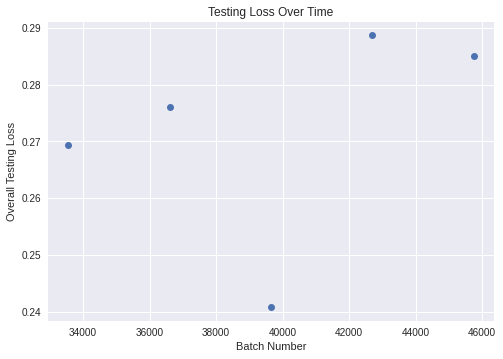

In [50]:
weight_fnames = os.listdir('./saved_weights3/')
#weight_fnames.sort() # isnt perfectly sorted, but too lazy to add the code (not important)
batch_sizes = []
losses = []

for fname in weight_fnames[21::2]:
    
    print(f'Loading: {fname}\n')

    checkpoint = torch.load(f'./saved_weights3/{fname}', map_location=device)
    
    # network weights load
    net = torchvision.models.resnet50(pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)

    net.load_state_dict(checkpoint['model_state_dict'])  
    criterion = nn.BCELoss()
    
    net.eval()
    
    # set start time for cnn training
    start_time = time.time()
    
    ground_truths = []
    probs = []

    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, testdata in enumerate(test_loader, 0):
            
            image, label = testdata
            image, label = image.to(device), label.to(device)

            # calculate outputs by running images through the network 
            outputs = net(image)
            
            loss = criterion(outputs, label.unsqueeze(-1).float())
            running_loss += loss.item()
        
            # everything saved should be on RAM
            #outputs = outputs.to("cpu")
            #label = label.to("cpu")
            
            # save for analysis
            ground_truths.append(label)
            
            # # save for analysis
            probs += outputs.squeeze(-1).tolist()

            if i % 10 == 0:
                print(f"\t Processing Batch #{i} ... Running Time {time.time() - start_time}")
                print(f'\t Current Testing Loss: {running_loss / (i+1)}\n')

                
    print(f'******* Final Testing Loss: {running_loss / (i+1)} *******\n')

    batch_sizes.append(checkpoint['mini_batch'])
    losses.append(running_loss / (i+1))
                
    # Save ground-truths and probability results¶
    res = {}
    res["ground_truths"] = ground_truths
    res["probs"] = probs
    res["num_batches"] = checkpoint['mini_batch']
    res["testing_loss"] = running_loss / (i+1)

    pkl_f_name = f'./saved_results3/results_ResNet50_{checkpoint["mini_batch"]}b.pkl'
    with open(pkl_f_name, 'wb') as f:
        pickle.dump(res, f)

        
plt.plot(batch_sizes, losses, 'o')
plt.title("Testing Loss Over Time")
plt.xlabel("Batch Number")
plt.ylabel("Overall Testing Loss")
plt.show()

## Choose the results from the best performing model (training size)

[Batch 15250] Size Area Under the ROC Curve: 0.884967608877827 

[Batch 3050] Size Area Under the ROC Curve: 0.871584630901783 

[Batch 6100] Size Area Under the ROC Curve: 0.8809908522051555 

[Batch 9150] Size Area Under the ROC Curve: 0.883370215556102 

[Batch 12200] Size Area Under the ROC Curve: 0.8864596244202131 

[Batch 18300] Size Area Under the ROC Curve: 0.885618274848666 

[Batch 21350] Size Area Under the ROC Curve: 0.8871136357173802 

[Batch 24400] Size Area Under the ROC Curve: 0.8875150748767665 

[Batch 27450] Size Area Under the ROC Curve: 0.8854351182321959 

[Batch 30500] Size Area Under the ROC Curve: 0.8886633581389279 

[Batch 33550] Size Area Under the ROC Curve: 0.8846991464399875 

[Batch 36600] Size Area Under the ROC Curve: 0.886565838531134 

[Batch 39650] Size Area Under the ROC Curve: 0.8822528765624765 

[Batch 42700] Size Area Under the ROC Curve: 0.8842600723594084 

[Batch 45750] Size Area Under the ROC Curve: 0.8864362071359155 



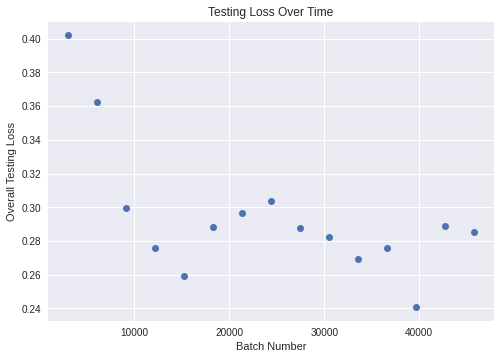

In [59]:
plt.style.use('seaborn')

# in case pkl results were calculated in batch job
# we may wont to visualize the test plot over time
recalc_loss_plot = True

if recalc_loss_plot:
    
    batch_sizes = []
    losses = []
    res_fnames = os.listdir('./saved_results3/')
    
    for fname in res_fnames:
        with open(f'./saved_results3/{fname}', 'rb') as f:
            res = pickle.load(f)
            batch_sizes.append(res["num_batches"])
            losses.append(res["testing_loss"]) 
            
            
            gt = res["ground_truths"]
            probs = np.array(res["probs"])

            # match formats (shouldve done this before, forgot to check)
            ground_truths = []
            for i in range(len(gt)):
                if gt[i].size() > torch.Size([1]):
                    ground_truths += gt[i].squeeze(-1).tolist()
                else:
                    ground_truths.append(gt[i].squeeze(-1).tolist())

            ground_truths = np.array(ground_truths)
            print(f"[Batch {res['num_batches']}] Size Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")
            
    
    plt.plot(batch_sizes, losses, 'o')
    plt.title("Testing Loss Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Overall Testing Loss")
    plt.show()

In [54]:
best_batch_size = 42700


with open(f'./saved_results3/results_ResNet50_{best_batch_size}b.pkl', 'rb') as f:
    res = pickle.load(f)
    
    
gt = res["ground_truths"]
probs = np.array(res["probs"])


# match formats (shouldve done this before, forgot to check)
ground_truths = []
for i in range(len(gt)):
    if gt[i].size() > torch.Size([1]):
        ground_truths += gt[i].squeeze(-1).tolist()
    else:
        ground_truths.append(gt[i].squeeze(-1).tolist())
        
ground_truths = np.array(ground_truths)

## Testing Results

Max F2-Score is: 0.34536891679748827
Max G-Mean is: 0.8033140411530464
Max Cohen's Kappa is: 0.22652674402477935
Area Under the ROC Curve: 0.8842600723594084 



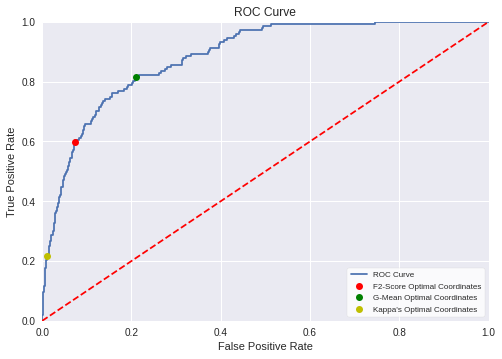


********************* USING F2-SCORE OPTIMAL THRESHOLD *************************
The confusion matrix is:
 [[7536  598]
 [  59   88]] 

Recall / Sensitivity: 0.5986394557823129
Precision: 0.1282798833819242
Specificity: 0.9264814359478731
F2-Score: 0.34536891679748827
G-Mean: 0.7447337394050645
Cohen's Kappa: 0.1875297268423325
********************************************************************************


********************** USING G-MEAN OPTIMAL THRESHOLD **************************
The confusion matrix is:
 [[6430 1704]
 [  28  119]] 

Recall / Sensitivity: 0.8163265306122449
Precision: 0.06527701590784421
Specificity: 0.790508974674207
F2-Score: 0.24678556615512232
G-Mean: 0.8033140411530464
Cohen's Kappa: 0.09094635891574943
********************************************************************************


********************** USING KAPPA OPTIMAL THRESHOLD ***************************
The confusion matrix is:
 [[8052   82]
 [ 116   31]] 

Recall / Sensitivity: 0.217687074829

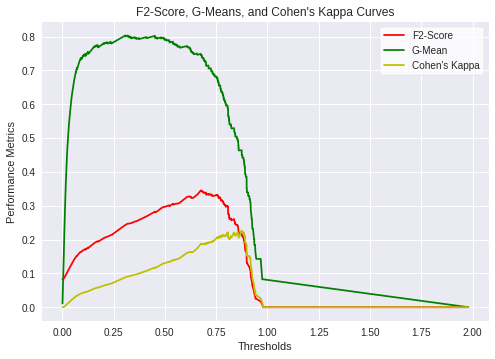

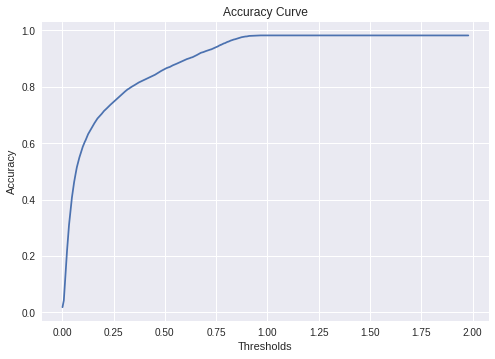

In [55]:
import warnings
warnings.filterwarnings('ignore')

fpr, tpr, thresholds = metrics.roc_curve(ground_truths, probs)
recall = tpr

# compute other metrics using the same thresholds
specificity = np.zeros_like(tpr)
precision = np.zeros_like(tpr)
fbetascores = np.zeros_like(tpr)
CKappas = np.zeros_like(tpr)

for i in range(len(thresholds)):
    preds = probs > thresholds[i]
    tn, fp, fn, tp = metrics.confusion_matrix(ground_truths, preds).ravel()
    
    specificity[i] = tn / (tn + fp)
    precision[i] = tp / (tp + fp)
    
    # more attention put on recall, such as when false negatives are more important to
    # minimize, but false positives are still important.
    fbetascores[i] = metrics.fbeta_score(ground_truths, preds, beta = 2)
    
    CKappas[i] = metrics.cohen_kappa_score(ground_truths, preds,)
    


gmeans = np.sqrt(specificity * recall)


print("Max F2-Score is:", np.nanmax(fbetascores))
print("Max G-Mean is:", np.nanmax(gmeans))
print("Max Cohen's Kappa is:", np.nanmax(CKappas))


print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")

plt.plot(fpr, tpr)
plt.plot(fpr[np.nanargmax(fbetascores)], tpr[np.nanargmax(fbetascores)], 'ro')
plt.plot(fpr[np.nanargmax(gmeans)], tpr[np.nanargmax(gmeans)], 'go')
plt.plot(fpr[np.nanargmax(CKappas)], tpr[np.nanargmax(CKappas)], 'yo')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.legend(['ROC Curve', 'F2-Score Optimal Coordinates', 'G-Mean Optimal Coordinates', 
            "Kappa's Optimal Coordinates"], loc='lower right', prop={'size': 8}, 
           frameon=True, facecolor = 'white')
plt.show()

fb_opt_thresh = thresholds[np.nanargmax(fbetascores)]
fb_opt_preds = probs > fb_opt_thresh

print('\n********************* USING F2-SCORE OPTIMAL THRESHOLD *************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, fb_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(fbetascores)] )
print("Precision:",  precision[np.nanargmax(fbetascores)] )
print("Specificity:",  specificity[np.nanargmax(fbetascores)] )
print("F2-Score:", fbetascores[np.nanargmax(fbetascores)] )
print("G-Mean:", gmeans[np.nanargmax(fbetascores)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(fbetascores)] )
print('********************************************************************************\n')

gm_opt_thresh = thresholds[np.nanargmax(gmeans)]
gm_opt_preds = probs > gm_opt_thresh

print('\n********************** USING G-MEAN OPTIMAL THRESHOLD **************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, gm_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(gmeans)] )
print("Precision:",  precision[np.nanargmax(gmeans)] )
print("Specificity:",  specificity[np.nanargmax(gmeans)] )
print("F2-Score:", fbetascores[np.nanargmax(gmeans)] )
print("G-Mean:", gmeans[np.nanargmax(gmeans)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(gmeans)] )
print('********************************************************************************\n')


ck_opt_thresh = thresholds[np.nanargmax(CKappas)]
ck_opt_preds = probs > ck_opt_thresh

print('\n********************** USING KAPPA OPTIMAL THRESHOLD ***************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, ck_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(CKappas)] )
print("Precision:",  precision[np.nanargmax(CKappas)] )
print("Specificity:",  specificity[np.nanargmax(CKappas)] )
print("F2-Score:", fbetascores[np.nanargmax(CKappas)] )
print("G-Mean:", gmeans[np.nanargmax(CKappas)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(CKappas)] )
print('********************************************************************************\n')


accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(metrics.accuracy_score(ground_truths, [m > thresh for m in probs]))



plt.plot(thresholds, fbetascores, "-r")
plt.plot(thresholds, gmeans, "-g")
plt.plot(thresholds, CKappas, "-y")
plt.title("F2-Score, G-Means, and Cohen's Kappa Curves")
plt.xlabel("Thresholds")
plt.ylabel("Performance Metrics")
plt.legend(['F2-Score', 'G-Mean', "Cohen's Kappa"], loc='upper right',
           frameon=True, facecolor = 'white')
plt.show()    
    

plt.plot(thresholds, accuracy_scores)
plt.title("Accuracy Curve")
plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.show()